In [3]:
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras import optimizers
import tensorflow as tf
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from sklearn import metrics
import seaborn as sns

In [4]:
data_path = 'data.csv'
df = pd.read_csv(data_path)

In [5]:
df.head()

,Layer-1,Layer-2,Ana-1,Ana-2,Thickness,WaveLength,Core_Real,CoreImag,TotalPower,CorePower,EffectiveArea,EML,CLoss
0,Au,TiO2,1.33,1.33,40,1500.0,1.4327,-3.380000e-09,5.240000e-10,5.230000e-10,1.940000e-11,19.9,0.12289
1,Au,TiO2,1.33,1.33,40,1520.0,1.4322,-4.400000e-09,5.030000e-10,5.010000e-10,1.660000e-11,19.9,0.15782
2,Au,TiO2,1.33,1.33,40,1540.0,1.4316,-5.840000e-09,4.960000e-10,4.940000e-10,1.570000e-11,19.9,0.20700
3,Au,TiO2,1.33,1.33,40,1560.0,1.4311,-8.070000e-09,4.930000e-10,4.920000e-10,1.650000e-11,19.9,0.28230
4,Au,TiO2,1.33,1.33,40,1580.0,1.4305,-1.190000e-08,4.630000e-10,4.620000e-10,1.990000e-11,19.9,0.41038


In [6]:
df.shape

(5527, 13)

In [7]:
dummy_fields = ["Layer-1","Layer-2"]

for each in dummy_fields:
    dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
    df = pd.concat([df,dummies], axis=1)

In [8]:
fields_to_drop = ["Layer-1","Layer-2"]
df = df.drop(fields_to_drop, axis=1)

In [9]:
df.head()

,Ana-1,Ana-2,Thickness,WaveLength,Core_Real,CoreImag,TotalPower,CorePower,EffectiveArea,EML,CLoss,Layer-1_AU,Layer-1_Au,Layer-1_Au+Ta2O5,Layer-1_TiO2,Layer-2_Au,Layer-2_TIO2,Layer-2_Ta2O5,Layer-2_TiO2
0,1.33,1.33,40,1500.0,1.4327,-3.380000e-09,5.240000e-10,5.230000e-10,1.940000e-11,19.9,0.12289,0,1,0,0,0,0,0,1
1,1.33,1.33,40,1520.0,1.4322,-4.400000e-09,5.030000e-10,5.010000e-10,1.660000e-11,19.9,0.15782,0,1,0,0,0,0,0,1
2,1.33,1.33,40,1540.0,1.4316,-5.840000e-09,4.960000e-10,4.940000e-10,1.570000e-11,19.9,0.20700,0,1,0,0,0,0,0,1
3,1.33,1.33,40,1560.0,1.4311,-8.070000e-09,4.930000e-10,4.920000e-10,1.650000e-11,19.9,0.28230,0,1,0,0,0,0,0,1
4,1.33,1.33,40,1580.0,1.4305,-1.190000e-08,4.630000e-10,4.620000e-10,1.990000e-11,19.9,0.41038,0,1,0,0,0,0,0,1


In [10]:
for each in df.columns:
  print(each,' '*(20-len(each)), df[each].isnull().values.any())

Ana-1                 False
Ana-2                 False
Thickness             False
WaveLength            False
Core_Real             False
CoreImag              False
TotalPower            False
CorePower             False
EffectiveArea         False
EML                   False
CLoss                 False
Layer-1_AU            False
Layer-1_Au            False
Layer-1_Au+Ta2O5      False
Layer-1_TiO2          False
Layer-2_Au            False
Layer-2_TIO2          False
Layer-2_Ta2O5         False
Layer-2_TiO2          False


In [11]:
tar = ['Core_Real', 'CoreImag', 'TotalPower', 'CorePower','EML', 'CLoss']
# tar = ['CLoss']
x = df[["Layer-1_Au",	"Layer-1_Au+Ta2O5",	"Layer-1_TiO2",	"Layer-2_Au",	"Layer-2_Ta2O5",	"Layer-2_TiO2","Ana-1","Ana-2","Thickness","WaveLength"]]
y = df[tar]

In [12]:
x.head()

,Layer-1_Au,Layer-1_Au+Ta2O5,Layer-1_TiO2,Layer-2_Au,Layer-2_Ta2O5,Layer-2_TiO2,Ana-1,Ana-2,Thickness,WaveLength
0,1,0,0,0,0,1,1.33,1.33,40,1500.0
1,1,0,0,0,0,1,1.33,1.33,40,1520.0
2,1,0,0,0,0,1,1.33,1.33,40,1540.0
3,1,0,0,0,0,1,1.33,1.33,40,1560.0
4,1,0,0,0,0,1,1.33,1.33,40,1580.0


In [13]:
quant_features = tar
scaled_features = {}

for each in quant_features:
    mean, std = y[each].mean(), y[each].std()
    scaled_features[each] = [mean, std]
    y.loc[:, each] = (y[each] - mean)/std 

C:\Users\Administrator\AppData\Local\Temp\ipykernel_17164\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, each] = (y[each] - mean)/std
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17164\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y.loc[:, each] = (y[each] - mean)/std
C:\Users\Administrator\AppData\Local\Temp\ipykernel_17164\3167035514.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=45)

In [15]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()

In [16]:
model = Sequential()

model.add(Dense(128, kernel_initializer='normal', input_dim = 10, activation='relu'))

model.add(Dense(64, kernel_initializer='normal', activation='relu'))

model.add(Dense(64, kernel_initializer='normal', activation='relu'))

model.add(Dense(128, kernel_initializer='normal', activation='relu'))

model.add(Dense(32, kernel_initializer='normal', activation='relu'))

model.add(Dense(6, kernel_initializer='normal', activation='linear'))


In [17]:
# schedule = tf.optimizers.schedules.PiecewiseConstantDecay(
#         [300, 14000,45000], [0.001, 0.0001,0.00001,0.000001])
ada = optimizers.Adam(
    learning_rate=0.00003,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam"
)


# ada = optimizers.Adagrad(
#     learning_rate=0.01,
#     initial_accumulator_value=0.1,
#     epsilon=1e-07,
#     name='Adagrad'
# )


# ada = tf.keras.optimizers.RMSprop(
#     learning_rate=0.0001,
#     rho=0.9,
#     momentum=0.0,
#     epsilon=1e-07,
#     centered=False,
#     name='RMSprop'
# )


# ada = optimizers.Adadelta(
#     learning_rate=0.01,
#     rho=0.95,
#     epsilon=1e-07,
#     name='Adadelta'
# )

# tf.keras.optimizers.Adamax(
#     learning_rate=0.0001,
#     beta_1=0.9,
#     beta_2=0.999,
#     epsilon=1e-07,
#     name='Adamax'
# )


model.compile(loss='mse', optimizer=ada, metrics=['mae', 'mse'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               1408      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 128)               8320      
                                                                 
 dense_4 (Dense)             (None, 32)                4128      
                                                                 
 dense_5 (Dense)             (None, 6)                 198       
                                                                 
Total params: 26,470
Trainable params: 26,470
Non-traina

In [18]:
history = model.fit(
    X_train, 
    y_train, 
    epochs=10000, 
    batch_size=64, 
    validation_split = 0.2)

Epoch 1/10000
56/56 [==============================] - 1s 4ms/step - loss: 1.0130 - mae: 0.6669 - mse: 1.0130 - val_loss: 1.0517 - val_mae: 0.6626 - val_mse: 1.0517
Epoch 2/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.9935 - mae: 0.6678 - mse: 0.9935 - val_loss: 1.0480 - val_mae: 0.6665 - val_mse: 1.0480
Epoch 3/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.9910 - mae: 0.6719 - mse: 0.9910 - val_loss: 1.0472 - val_mae: 0.6692 - val_mse: 1.0472
Epoch 4/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.9904 - mae: 0.6748 - mse: 0.9904 - val_loss: 1.0470 - val_mae: 0.6724 - val_mse: 1.0470
Epoch 5/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.9898 - mae: 0.6753 - mse: 0.9898 - val_loss: 1.0464 - val_mae: 0.6721 - val_mse: 1.0464
Epoch 6/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.9894 - mae: 0.6736 - mse: 0.9894 - val_loss: 1.0461 - val_mae: 0.6706 - val_mse: 1.0461
Epoch 7/10

56/56 [==============================] - 0s 1ms/step - loss: 0.5410 - mae: 0.4611 - mse: 0.5410 - val_loss: 0.6380 - val_mae: 0.4779 - val_mse: 0.6380
Epoch 100/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.5388 - mae: 0.4595 - mse: 0.5388 - val_loss: 0.5883 - val_mae: 0.4497 - val_mse: 0.5883
Epoch 101/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.5367 - mae: 0.4570 - mse: 0.5367 - val_loss: 0.5863 - val_mae: 0.4745 - val_mse: 0.5863
Epoch 102/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.5486 - mae: 0.4679 - mse: 0.5486 - val_loss: 0.5813 - val_mae: 0.4675 - val_mse: 0.5813
Epoch 103/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.5375 - mae: 0.4575 - mse: 0.5375 - val_loss: 0.5955 - val_mae: 0.4534 - val_mse: 0.5955
Epoch 104/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.5343 - mae: 0.4568 - mse: 0.5343 - val_loss: 0.5778 - val_mae: 0.4523 - val_mse: 0.5778
Epoch 105/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.4586 - mae: 0.4062 - mse: 0.4586 - val_loss: 0.5005 - val_mae: 0.3998 - val_mse: 0.5005
Epoch 198/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4600 - mae: 0.4062 - mse: 0.4600 - val_loss: 0.4992 - val_mae: 0.4203 - val_mse: 0.4992
Epoch 199/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4639 - mae: 0.4127 - mse: 0.4639 - val_loss: 0.5402 - val_mae: 0.4071 - val_mse: 0.5402
Epoch 200/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4676 - mae: 0.4161 - mse: 0.4676 - val_loss: 0.5031 - val_mae: 0.3962 - val_mse: 0.5031
Epoch 201/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4592 - mae: 0.4083 - mse: 0.4592 - val_loss: 0.5162 - val_mae: 0.3953 - val_mse: 0.5162
Epoch 202/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4582 - mae: 0.4084 - mse: 0.4582 - val_loss: 0.5064 - val_mae: 0.3935 - val_mse: 0.5064
Epoch 203/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.4073 - mae: 0.3829 - mse: 0.4073 - val_loss: 0.4519 - val_mae: 0.3732 - val_mse: 0.4519
Epoch 296/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4075 - mae: 0.3843 - mse: 0.4075 - val_loss: 0.4682 - val_mae: 0.3785 - val_mse: 0.4682
Epoch 297/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4259 - mae: 0.3986 - mse: 0.4259 - val_loss: 0.4420 - val_mae: 0.3862 - val_mse: 0.4420
Epoch 298/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4064 - mae: 0.3830 - mse: 0.4064 - val_loss: 0.4499 - val_mae: 0.3743 - val_mse: 0.4499
Epoch 299/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4121 - mae: 0.3879 - mse: 0.4121 - val_loss: 0.4484 - val_mae: 0.3741 - val_mse: 0.4484
Epoch 300/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.4070 - mae: 0.3851 - mse: 0.4070 - val_loss: 0.4452 - val_mae: 0.3738 - val_mse: 0.4452
Epoch 301/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.3521 - mae: 0.3586 - mse: 0.3521 - val_loss: 0.3855 - val_mae: 0.3499 - val_mse: 0.3855
Epoch 394/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.3546 - mae: 0.3621 - mse: 0.3546 - val_loss: 0.3834 - val_mae: 0.3507 - val_mse: 0.3834
Epoch 395/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.3586 - mae: 0.3671 - mse: 0.3586 - val_loss: 0.3861 - val_mae: 0.3512 - val_mse: 0.3861
Epoch 396/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.3513 - mae: 0.3591 - mse: 0.3513 - val_loss: 0.3814 - val_mae: 0.3554 - val_mse: 0.3814
Epoch 397/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.3495 - mae: 0.3571 - mse: 0.3495 - val_loss: 0.3837 - val_mae: 0.3635 - val_mse: 0.3837
Epoch 398/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.3532 - mae: 0.3625 - mse: 0.3532 - val_loss: 0.3983 - val_mae: 0.3545 - val_mse: 0.3983
Epoch 399/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.2930 - mae: 0.3228 - mse: 0.2930 - val_loss: 0.3217 - val_mae: 0.3053 - val_mse: 0.3217
Epoch 492/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2855 - mae: 0.3140 - mse: 0.2855 - val_loss: 0.3398 - val_mae: 0.3180 - val_mse: 0.3398
Epoch 493/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2877 - mae: 0.3181 - mse: 0.2877 - val_loss: 0.3155 - val_mae: 0.3051 - val_mse: 0.3155
Epoch 494/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2862 - mae: 0.3136 - mse: 0.2862 - val_loss: 0.3686 - val_mae: 0.3468 - val_mse: 0.3686
Epoch 495/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2891 - mae: 0.3188 - mse: 0.2891 - val_loss: 0.3143 - val_mae: 0.3047 - val_mse: 0.3143
Epoch 496/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2836 - mae: 0.3135 - mse: 0.2836 - val_loss: 0.3138 - val_mae: 0.3046 - val_mse: 0.3138
Epoch 497/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.2384 - mae: 0.2883 - mse: 0.2384 - val_loss: 0.3113 - val_mae: 0.3020 - val_mse: 0.3113
Epoch 590/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2332 - mae: 0.2807 - mse: 0.2332 - val_loss: 0.2551 - val_mae: 0.2571 - val_mse: 0.2551
Epoch 591/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2213 - mae: 0.2668 - mse: 0.2213 - val_loss: 0.2574 - val_mae: 0.2576 - val_mse: 0.2574
Epoch 592/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2222 - mae: 0.2713 - mse: 0.2222 - val_loss: 0.2584 - val_mae: 0.2775 - val_mse: 0.2584
Epoch 593/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2280 - mae: 0.2743 - mse: 0.2280 - val_loss: 0.2588 - val_mae: 0.2603 - val_mse: 0.2588
Epoch 594/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.2176 - mae: 0.2631 - mse: 0.2176 - val_loss: 0.2660 - val_mae: 0.2902 - val_mse: 0.2660
Epoch 595/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.1714 - mae: 0.2281 - mse: 0.1714 - val_loss: 0.2028 - val_mae: 0.2216 - val_mse: 0.2028
Epoch 688/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1818 - mae: 0.2402 - mse: 0.1818 - val_loss: 0.2085 - val_mae: 0.2274 - val_mse: 0.2085
Epoch 689/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1695 - mae: 0.2268 - mse: 0.1695 - val_loss: 0.2081 - val_mae: 0.2196 - val_mse: 0.2081
Epoch 690/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1777 - mae: 0.2369 - mse: 0.1777 - val_loss: 0.2120 - val_mae: 0.2399 - val_mse: 0.2120
Epoch 691/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1739 - mae: 0.2289 - mse: 0.1739 - val_loss: 0.2022 - val_mae: 0.2191 - val_mse: 0.2022
Epoch 692/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1691 - mae: 0.2254 - mse: 0.1691 - val_loss: 0.2162 - val_mae: 0.2337 - val_mse: 0.2162
Epoch 693/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.1494 - mae: 0.2101 - mse: 0.1494 - val_loss: 0.1786 - val_mae: 0.1996 - val_mse: 0.1786
Epoch 786/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1527 - mae: 0.2146 - mse: 0.1527 - val_loss: 0.1801 - val_mae: 0.2000 - val_mse: 0.1801
Epoch 787/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1510 - mae: 0.2114 - mse: 0.1510 - val_loss: 0.2001 - val_mae: 0.2308 - val_mse: 0.2001
Epoch 788/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1558 - mae: 0.2151 - mse: 0.1558 - val_loss: 0.2163 - val_mae: 0.2213 - val_mse: 0.2163
Epoch 789/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1501 - mae: 0.2112 - mse: 0.1501 - val_loss: 0.1875 - val_mae: 0.2189 - val_mse: 0.1875
Epoch 790/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1650 - mae: 0.2283 - mse: 0.1650 - val_loss: 0.2074 - val_mae: 0.2175 - val_mse: 0.2074
Epoch 791/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.1401 - mae: 0.1985 - mse: 0.1401 - val_loss: 0.1676 - val_mae: 0.1861 - val_mse: 0.1676
Epoch 884/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1395 - mae: 0.1995 - mse: 0.1395 - val_loss: 0.1688 - val_mae: 0.1870 - val_mse: 0.1688
Epoch 885/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1352 - mae: 0.1923 - mse: 0.1352 - val_loss: 0.1682 - val_mae: 0.1862 - val_mse: 0.1682
Epoch 886/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1389 - mae: 0.1977 - mse: 0.1389 - val_loss: 0.1727 - val_mae: 0.1869 - val_mse: 0.1727
Epoch 887/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1356 - mae: 0.1937 - mse: 0.1356 - val_loss: 0.1764 - val_mae: 0.1877 - val_mse: 0.1764
Epoch 888/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1405 - mae: 0.1977 - mse: 0.1405 - val_loss: 0.1691 - val_mae: 0.1936 - val_mse: 0.1691
Epoch 889/1000

56/56 [==============================] - 0s 1ms/step - loss: 0.1268 - mae: 0.1839 - mse: 0.1268 - val_loss: 0.1679 - val_mae: 0.1804 - val_mse: 0.1679
Epoch 982/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1368 - mae: 0.1937 - mse: 0.1368 - val_loss: 0.1633 - val_mae: 0.1792 - val_mse: 0.1633
Epoch 983/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1268 - mae: 0.1841 - mse: 0.1268 - val_loss: 0.1596 - val_mae: 0.1791 - val_mse: 0.1596
Epoch 984/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1346 - mae: 0.1910 - mse: 0.1346 - val_loss: 0.1613 - val_mae: 0.1785 - val_mse: 0.1613
Epoch 985/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1271 - mae: 0.1834 - mse: 0.1271 - val_loss: 0.1650 - val_mae: 0.1790 - val_mse: 0.1650
Epoch 986/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1408 - mae: 0.1942 - mse: 0.1408 - val_loss: 0.1668 - val_mae: 0.1796 - val_mse: 0.1668
Epoch 987/1000

Epoch 1030/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1359 - mae: 0.1919 - mse: 0.1359 - val_loss: 0.1691 - val_mae: 0.2008 - val_mse: 0.1691
Epoch 1031/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1374 - mae: 0.1938 - mse: 0.1374 - val_loss: 0.1573 - val_mae: 0.1778 - val_mse: 0.1573
Epoch 1032/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1302 - mae: 0.1895 - mse: 0.1302 - val_loss: 0.1610 - val_mae: 0.1773 - val_mse: 0.1610
Epoch 1033/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1260 - mae: 0.1825 - mse: 0.1260 - val_loss: 0.1772 - val_mae: 0.1858 - val_mse: 0.1772
Epoch 1034/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1353 - mae: 0.1948 - mse: 0.1353 - val_loss: 0.1581 - val_mae: 0.1762 - val_mse: 0.1581
Epoch 1035/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1265 - mae: 0.1818 - mse: 0.1265 - val_loss: 0.1890 - val_mae: 0.2077 - val_mse:

Epoch 1079/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1244 - mae: 0.1825 - mse: 0.1244 - val_loss: 0.1652 - val_mae: 0.1816 - val_mse: 0.1652
Epoch 1080/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1261 - mae: 0.1834 - mse: 0.1261 - val_loss: 0.1628 - val_mae: 0.1759 - val_mse: 0.1628
Epoch 1081/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1221 - mae: 0.1770 - mse: 0.1221 - val_loss: 0.1562 - val_mae: 0.1738 - val_mse: 0.1562
Epoch 1082/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1202 - mae: 0.1760 - mse: 0.1202 - val_loss: 0.1637 - val_mae: 0.1818 - val_mse: 0.1637
Epoch 1083/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1287 - mae: 0.1857 - mse: 0.1287 - val_loss: 0.1910 - val_mae: 0.2109 - val_mse: 0.1910
Epoch 1084/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1255 - mae: 0.1823 - mse: 0.1255 - val_loss: 0.1702 - val_mae: 0.2002 - val_mse:

Epoch 1128/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1267 - mae: 0.1819 - mse: 0.1267 - val_loss: 0.1719 - val_mae: 0.1989 - val_mse: 0.1719
Epoch 1129/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1294 - mae: 0.1851 - mse: 0.1294 - val_loss: 0.1885 - val_mae: 0.2242 - val_mse: 0.1885
Epoch 1130/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1262 - mae: 0.1820 - mse: 0.1262 - val_loss: 0.1552 - val_mae: 0.1772 - val_mse: 0.1552
Epoch 1131/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1279 - mae: 0.1853 - mse: 0.1279 - val_loss: 0.1586 - val_mae: 0.1767 - val_mse: 0.1586
Epoch 1132/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1228 - mae: 0.1787 - mse: 0.1228 - val_loss: 0.1542 - val_mae: 0.1728 - val_mse: 0.1542
Epoch 1133/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1289 - mae: 0.1879 - mse: 0.1289 - val_loss: 0.1607 - val_mae: 0.1865 - val_mse:

Epoch 1177/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1227 - mae: 0.1787 - mse: 0.1227 - val_loss: 0.1577 - val_mae: 0.1786 - val_mse: 0.1577
Epoch 1178/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1199 - mae: 0.1778 - mse: 0.1199 - val_loss: 0.1534 - val_mae: 0.1759 - val_mse: 0.1534
Epoch 1179/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1252 - mae: 0.1844 - mse: 0.1252 - val_loss: 0.1533 - val_mae: 0.1719 - val_mse: 0.1533
Epoch 1180/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1254 - mae: 0.1828 - mse: 0.1254 - val_loss: 0.1564 - val_mae: 0.1767 - val_mse: 0.1564
Epoch 1181/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1310 - mae: 0.1872 - mse: 0.1310 - val_loss: 0.1542 - val_mae: 0.1705 - val_mse: 0.1542
Epoch 1182/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1176 - mae: 0.1732 - mse: 0.1176 - val_loss: 0.1603 - val_mae: 0.1842 - val_mse:

Epoch 1226/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1256 - mae: 0.1803 - mse: 0.1256 - val_loss: 0.1578 - val_mae: 0.1782 - val_mse: 0.1578
Epoch 1227/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1178 - mae: 0.1743 - mse: 0.1178 - val_loss: 0.1537 - val_mae: 0.1765 - val_mse: 0.1537
Epoch 1228/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1222 - mae: 0.1801 - mse: 0.1222 - val_loss: 0.1506 - val_mae: 0.1688 - val_mse: 0.1506
Epoch 1229/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1172 - mae: 0.1727 - mse: 0.1172 - val_loss: 0.1541 - val_mae: 0.1765 - val_mse: 0.1541
Epoch 1230/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1194 - mae: 0.1756 - mse: 0.1194 - val_loss: 0.1552 - val_mae: 0.1785 - val_mse: 0.1552
Epoch 1231/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1355 - mae: 0.1942 - mse: 0.1355 - val_loss: 0.2405 - val_mae: 0.2470 - val_mse:

Epoch 1275/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1149 - mae: 0.1714 - mse: 0.1149 - val_loss: 0.1837 - val_mae: 0.2152 - val_mse: 0.1837
Epoch 1276/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1270 - mae: 0.1866 - mse: 0.1270 - val_loss: 0.1528 - val_mae: 0.1689 - val_mse: 0.1528
Epoch 1277/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1224 - mae: 0.1784 - mse: 0.1224 - val_loss: 0.1480 - val_mae: 0.1696 - val_mse: 0.1480
Epoch 1278/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1205 - mae: 0.1798 - mse: 0.1205 - val_loss: 0.1543 - val_mae: 0.1714 - val_mse: 0.1543
Epoch 1279/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1468 - mae: 0.2062 - mse: 0.1468 - val_loss: 0.2094 - val_mae: 0.2106 - val_mse: 0.2094
Epoch 1280/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1254 - mae: 0.1822 - mse: 0.1254 - val_loss: 0.1489 - val_mae: 0.1685 - val_mse:

Epoch 1324/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1353 - mae: 0.1942 - mse: 0.1353 - val_loss: 0.2055 - val_mae: 0.2359 - val_mse: 0.2055
Epoch 1325/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1320 - mae: 0.1894 - mse: 0.1320 - val_loss: 0.1533 - val_mae: 0.1699 - val_mse: 0.1533
Epoch 1326/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1144 - mae: 0.1706 - mse: 0.1144 - val_loss: 0.2020 - val_mae: 0.2224 - val_mse: 0.2020
Epoch 1327/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1174 - mae: 0.1760 - mse: 0.1174 - val_loss: 0.1499 - val_mae: 0.1735 - val_mse: 0.1499
Epoch 1328/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1271 - mae: 0.1871 - mse: 0.1271 - val_loss: 0.2041 - val_mae: 0.2396 - val_mse: 0.2041
Epoch 1329/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1524 - mae: 0.2134 - mse: 0.1524 - val_loss: 0.1503 - val_mae: 0.1682 - val_mse:

Epoch 1373/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1232 - mae: 0.1822 - mse: 0.1232 - val_loss: 0.1731 - val_mae: 0.1900 - val_mse: 0.1731
Epoch 1374/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1179 - mae: 0.1756 - mse: 0.1179 - val_loss: 0.2102 - val_mae: 0.2350 - val_mse: 0.2102
Epoch 1375/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1299 - mae: 0.1861 - mse: 0.1299 - val_loss: 0.1621 - val_mae: 0.1835 - val_mse: 0.1621
Epoch 1376/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1175 - mae: 0.1745 - mse: 0.1175 - val_loss: 0.1763 - val_mae: 0.2045 - val_mse: 0.1763
Epoch 1377/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1188 - mae: 0.1758 - mse: 0.1188 - val_loss: 0.1457 - val_mae: 0.1682 - val_mse: 0.1457
Epoch 1378/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1133 - mae: 0.1705 - mse: 0.1133 - val_loss: 0.1462 - val_mae: 0.1673 - val_mse:

Epoch 1422/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1240 - mae: 0.1816 - mse: 0.1240 - val_loss: 0.1603 - val_mae: 0.1830 - val_mse: 0.1603
Epoch 1423/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1156 - mae: 0.1721 - mse: 0.1156 - val_loss: 0.1488 - val_mae: 0.1698 - val_mse: 0.1488
Epoch 1424/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1159 - mae: 0.1751 - mse: 0.1159 - val_loss: 0.1592 - val_mae: 0.1962 - val_mse: 0.1592
Epoch 1425/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1179 - mae: 0.1763 - mse: 0.1179 - val_loss: 0.1658 - val_mae: 0.2040 - val_mse: 0.1658
Epoch 1426/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1154 - mae: 0.1731 - mse: 0.1154 - val_loss: 0.1496 - val_mae: 0.1674 - val_mse: 0.1496
Epoch 1427/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1141 - mae: 0.1722 - mse: 0.1141 - val_loss: 0.1457 - val_mae: 0.1685 - val_mse:

Epoch 1471/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1120 - mae: 0.1694 - mse: 0.1120 - val_loss: 0.1482 - val_mae: 0.1706 - val_mse: 0.1482
Epoch 1472/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1135 - mae: 0.1719 - mse: 0.1135 - val_loss: 0.1495 - val_mae: 0.1708 - val_mse: 0.1495
Epoch 1473/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1168 - mae: 0.1758 - mse: 0.1168 - val_loss: 0.1471 - val_mae: 0.1664 - val_mse: 0.1471
Epoch 1474/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1177 - mae: 0.1769 - mse: 0.1177 - val_loss: 0.1655 - val_mae: 0.1979 - val_mse: 0.1655
Epoch 1475/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1230 - mae: 0.1812 - mse: 0.1230 - val_loss: 0.1635 - val_mae: 0.1939 - val_mse: 0.1635
Epoch 1476/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1292 - mae: 0.1860 - mse: 0.1292 - val_loss: 0.1514 - val_mae: 0.1681 - val_mse:

Epoch 1520/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1155 - mae: 0.1728 - mse: 0.1155 - val_loss: 0.1484 - val_mae: 0.1741 - val_mse: 0.1484
Epoch 1521/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1267 - mae: 0.1875 - mse: 0.1267 - val_loss: 0.1857 - val_mae: 0.2264 - val_mse: 0.1857
Epoch 1522/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1401 - mae: 0.1959 - mse: 0.1401 - val_loss: 0.1519 - val_mae: 0.1793 - val_mse: 0.1519
Epoch 1523/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1176 - mae: 0.1765 - mse: 0.1176 - val_loss: 0.1914 - val_mae: 0.1981 - val_mse: 0.1914
Epoch 1524/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1231 - mae: 0.1793 - mse: 0.1231 - val_loss: 0.1788 - val_mae: 0.2030 - val_mse: 0.1788
Epoch 1525/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1190 - mae: 0.1785 - mse: 0.1190 - val_loss: 0.1534 - val_mae: 0.1898 - val_mse:

Epoch 1569/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1180 - mae: 0.1767 - mse: 0.1180 - val_loss: 0.1478 - val_mae: 0.1712 - val_mse: 0.1478
Epoch 1570/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1124 - mae: 0.1712 - mse: 0.1124 - val_loss: 0.1793 - val_mae: 0.1861 - val_mse: 0.1793
Epoch 1571/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1149 - mae: 0.1713 - mse: 0.1149 - val_loss: 0.1648 - val_mae: 0.1852 - val_mse: 0.1648
Epoch 1572/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1149 - mae: 0.1747 - mse: 0.1149 - val_loss: 0.1577 - val_mae: 0.1957 - val_mse: 0.1577
Epoch 1573/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1145 - mae: 0.1753 - mse: 0.1145 - val_loss: 0.1459 - val_mae: 0.1705 - val_mse: 0.1459
Epoch 1574/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1139 - mae: 0.1739 - mse: 0.1139 - val_loss: 0.1449 - val_mae: 0.1668 - val_mse:

Epoch 1618/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1190 - mae: 0.1765 - mse: 0.1190 - val_loss: 0.1591 - val_mae: 0.1842 - val_mse: 0.1591
Epoch 1619/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1096 - mae: 0.1672 - mse: 0.1096 - val_loss: 0.1433 - val_mae: 0.1681 - val_mse: 0.1433
Epoch 1620/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1084 - mae: 0.1660 - mse: 0.1084 - val_loss: 0.1453 - val_mae: 0.1721 - val_mse: 0.1453
Epoch 1621/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1183 - mae: 0.1770 - mse: 0.1183 - val_loss: 0.1432 - val_mae: 0.1651 - val_mse: 0.1432
Epoch 1622/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1194 - mae: 0.1766 - mse: 0.1194 - val_loss: 0.1449 - val_mae: 0.1690 - val_mse: 0.1449
Epoch 1623/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1140 - mae: 0.1724 - mse: 0.1140 - val_loss: 0.1455 - val_mae: 0.1684 - val_mse:

Epoch 1667/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1153 - mae: 0.1743 - mse: 0.1153 - val_loss: 0.1418 - val_mae: 0.1647 - val_mse: 0.1418
Epoch 1668/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1139 - mae: 0.1736 - mse: 0.1139 - val_loss: 0.1427 - val_mae: 0.1662 - val_mse: 0.1427
Epoch 1669/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1097 - mae: 0.1682 - mse: 0.1097 - val_loss: 0.1553 - val_mae: 0.1776 - val_mse: 0.1553
Epoch 1670/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1127 - mae: 0.1711 - mse: 0.1127 - val_loss: 0.1511 - val_mae: 0.1697 - val_mse: 0.1511
Epoch 1671/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1168 - mae: 0.1757 - mse: 0.1168 - val_loss: 0.1620 - val_mae: 0.1844 - val_mse: 0.1620
Epoch 1672/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1148 - mae: 0.1717 - mse: 0.1148 - val_loss: 0.1640 - val_mae: 0.1890 - val_mse:

Epoch 1716/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1393 - mae: 0.2013 - mse: 0.1393 - val_loss: 0.1800 - val_mae: 0.2211 - val_mse: 0.1800
Epoch 1717/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1157 - mae: 0.1742 - mse: 0.1157 - val_loss: 0.1502 - val_mae: 0.1806 - val_mse: 0.1502
Epoch 1718/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1175 - mae: 0.1751 - mse: 0.1175 - val_loss: 0.1423 - val_mae: 0.1668 - val_mse: 0.1423
Epoch 1719/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1180 - mae: 0.1794 - mse: 0.1180 - val_loss: 0.1885 - val_mae: 0.2395 - val_mse: 0.1885
Epoch 1720/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1134 - mae: 0.1715 - mse: 0.1134 - val_loss: 0.2065 - val_mae: 0.2199 - val_mse: 0.2065
Epoch 1721/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1434 - mae: 0.2018 - mse: 0.1434 - val_loss: 0.1416 - val_mae: 0.1648 - val_mse:

Epoch 1765/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1184 - mae: 0.1780 - mse: 0.1184 - val_loss: 0.1496 - val_mae: 0.1824 - val_mse: 0.1496
Epoch 1766/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1162 - mae: 0.1766 - mse: 0.1162 - val_loss: 0.1412 - val_mae: 0.1648 - val_mse: 0.1412
Epoch 1767/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1081 - mae: 0.1656 - mse: 0.1081 - val_loss: 0.1395 - val_mae: 0.1627 - val_mse: 0.1395
Epoch 1768/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1102 - mae: 0.1675 - mse: 0.1102 - val_loss: 0.1453 - val_mae: 0.1710 - val_mse: 0.1453
Epoch 1769/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1194 - mae: 0.1778 - mse: 0.1194 - val_loss: 0.1466 - val_mae: 0.1767 - val_mse: 0.1466
Epoch 1770/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1083 - mae: 0.1645 - mse: 0.1083 - val_loss: 0.1450 - val_mae: 0.1749 - val_mse:

Epoch 1814/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1131 - mae: 0.1710 - mse: 0.1131 - val_loss: 0.1428 - val_mae: 0.1708 - val_mse: 0.1428
Epoch 1815/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1084 - mae: 0.1641 - mse: 0.1084 - val_loss: 0.1403 - val_mae: 0.1615 - val_mse: 0.1403
Epoch 1816/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1081 - mae: 0.1633 - mse: 0.1081 - val_loss: 0.1557 - val_mae: 0.1875 - val_mse: 0.1557
Epoch 1817/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1131 - mae: 0.1721 - mse: 0.1131 - val_loss: 0.1451 - val_mae: 0.1695 - val_mse: 0.1451
Epoch 1818/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1151 - mae: 0.1731 - mse: 0.1151 - val_loss: 0.1398 - val_mae: 0.1619 - val_mse: 0.1398
Epoch 1819/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1048 - mae: 0.1614 - mse: 0.1048 - val_loss: 0.1415 - val_mae: 0.1636 - val_mse:

Epoch 1863/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1048 - mae: 0.1613 - mse: 0.1048 - val_loss: 0.1435 - val_mae: 0.1634 - val_mse: 0.1435
Epoch 1864/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1085 - mae: 0.1676 - mse: 0.1085 - val_loss: 0.1566 - val_mae: 0.1806 - val_mse: 0.1566
Epoch 1865/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1512 - mae: 0.2075 - mse: 0.1512 - val_loss: 0.1512 - val_mae: 0.1650 - val_mse: 0.1512
Epoch 1866/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1174 - mae: 0.1729 - mse: 0.1174 - val_loss: 0.1426 - val_mae: 0.1671 - val_mse: 0.1426
Epoch 1867/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1119 - mae: 0.1710 - mse: 0.1119 - val_loss: 0.1391 - val_mae: 0.1614 - val_mse: 0.1391
Epoch 1868/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.1595 - mse: 0.1044 - val_loss: 0.1585 - val_mae: 0.1977 - val_mse:

Epoch 1912/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1155 - mae: 0.1738 - mse: 0.1155 - val_loss: 0.1603 - val_mae: 0.1821 - val_mse: 0.1603
Epoch 1913/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1115 - mae: 0.1707 - mse: 0.1115 - val_loss: 0.1519 - val_mae: 0.1937 - val_mse: 0.1519
Epoch 1914/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1048 - mae: 0.1617 - mse: 0.1048 - val_loss: 0.1480 - val_mae: 0.1674 - val_mse: 0.1480
Epoch 1915/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1112 - mae: 0.1700 - mse: 0.1112 - val_loss: 0.1426 - val_mae: 0.1723 - val_mse: 0.1426
Epoch 1916/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1058 - mae: 0.1628 - mse: 0.1058 - val_loss: 0.1464 - val_mae: 0.1684 - val_mse: 0.1464
Epoch 1917/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1020 - mae: 0.1578 - mse: 0.1020 - val_loss: 0.1388 - val_mae: 0.1591 - val_mse:

Epoch 1961/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1075 - mae: 0.1632 - mse: 0.1075 - val_loss: 0.1361 - val_mae: 0.1579 - val_mse: 0.1361
Epoch 1962/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1043 - mae: 0.1614 - mse: 0.1043 - val_loss: 0.1550 - val_mae: 0.1792 - val_mse: 0.1550
Epoch 1963/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1065 - mae: 0.1633 - mse: 0.1065 - val_loss: 0.1379 - val_mae: 0.1642 - val_mse: 0.1379
Epoch 1964/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1253 - mae: 0.1869 - mse: 0.1253 - val_loss: 0.1483 - val_mae: 0.1610 - val_mse: 0.1483
Epoch 1965/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1098 - mae: 0.1710 - mse: 0.1098 - val_loss: 0.1843 - val_mae: 0.1843 - val_mse: 0.1843
Epoch 1966/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1131 - mae: 0.1694 - mse: 0.1131 - val_loss: 0.1436 - val_mae: 0.1703 - val_mse:

Epoch 2010/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1170 - mae: 0.1738 - mse: 0.1170 - val_loss: 0.1410 - val_mae: 0.1681 - val_mse: 0.1410
Epoch 2011/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1083 - mae: 0.1650 - mse: 0.1083 - val_loss: 0.1377 - val_mae: 0.1569 - val_mse: 0.1377
Epoch 2012/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1031 - mae: 0.1582 - mse: 0.1031 - val_loss: 0.1506 - val_mae: 0.1957 - val_mse: 0.1506
Epoch 2013/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1293 - mae: 0.1857 - mse: 0.1293 - val_loss: 0.1444 - val_mae: 0.1768 - val_mse: 0.1444
Epoch 2014/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1017 - mae: 0.1570 - mse: 0.1017 - val_loss: 0.1355 - val_mae: 0.1588 - val_mse: 0.1355
Epoch 2015/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1081 - mae: 0.1664 - mse: 0.1081 - val_loss: 0.1419 - val_mae: 0.1648 - val_mse:

Epoch 2059/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1035 - mae: 0.1602 - mse: 0.1035 - val_loss: 0.1444 - val_mae: 0.1717 - val_mse: 0.1444
Epoch 2060/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1174 - mae: 0.1787 - mse: 0.1174 - val_loss: 0.1521 - val_mae: 0.1980 - val_mse: 0.1521
Epoch 2061/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1061 - mae: 0.1620 - mse: 0.1061 - val_loss: 0.1447 - val_mae: 0.1820 - val_mse: 0.1447
Epoch 2062/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1055 - mae: 0.1625 - mse: 0.1055 - val_loss: 0.1500 - val_mae: 0.1823 - val_mse: 0.1500
Epoch 2063/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1175 - mae: 0.1766 - mse: 0.1175 - val_loss: 0.1417 - val_mae: 0.1610 - val_mse: 0.1417
Epoch 2064/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1268 - mae: 0.1880 - mse: 0.1268 - val_loss: 0.1551 - val_mae: 0.1843 - val_mse:

Epoch 2108/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1089 - mae: 0.1677 - mse: 0.1089 - val_loss: 0.1446 - val_mae: 0.1813 - val_mse: 0.1446
Epoch 2109/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1020 - mae: 0.1591 - mse: 0.1020 - val_loss: 0.1442 - val_mae: 0.1784 - val_mse: 0.1442
Epoch 2110/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1058 - mae: 0.1647 - mse: 0.1058 - val_loss: 0.1480 - val_mae: 0.1852 - val_mse: 0.1480
Epoch 2111/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1090 - mae: 0.1658 - mse: 0.1090 - val_loss: 0.1482 - val_mae: 0.1798 - val_mse: 0.1482
Epoch 2112/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1066 - mae: 0.1626 - mse: 0.1066 - val_loss: 0.2020 - val_mae: 0.1879 - val_mse: 0.2020
Epoch 2113/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1117 - mae: 0.1695 - mse: 0.1117 - val_loss: 0.1485 - val_mae: 0.1637 - val_mse:

Epoch 2157/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1034 - mae: 0.1603 - mse: 0.1034 - val_loss: 0.1583 - val_mae: 0.1640 - val_mse: 0.1583
Epoch 2158/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1045 - mae: 0.1643 - mse: 0.1045 - val_loss: 0.1336 - val_mae: 0.1555 - val_mse: 0.1336
Epoch 2159/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1039 - mae: 0.1609 - mse: 0.1039 - val_loss: 0.1507 - val_mae: 0.1587 - val_mse: 0.1507
Epoch 2160/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1142 - mae: 0.1699 - mse: 0.1142 - val_loss: 0.1329 - val_mae: 0.1573 - val_mse: 0.1329
Epoch 2161/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1004 - mae: 0.1551 - mse: 0.1004 - val_loss: 0.1703 - val_mae: 0.1940 - val_mse: 0.1703
Epoch 2162/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1067 - mae: 0.1625 - mse: 0.1067 - val_loss: 0.1400 - val_mae: 0.1650 - val_mse:

Epoch 2206/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1062 - mae: 0.1672 - mse: 0.1062 - val_loss: 0.1381 - val_mae: 0.1644 - val_mse: 0.1381
Epoch 2207/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1042 - mae: 0.1627 - mse: 0.1042 - val_loss: 0.1316 - val_mae: 0.1554 - val_mse: 0.1316
Epoch 2208/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1039 - mae: 0.1593 - mse: 0.1039 - val_loss: 0.1493 - val_mae: 0.1690 - val_mse: 0.1493
Epoch 2209/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1052 - mae: 0.1617 - mse: 0.1052 - val_loss: 0.1473 - val_mae: 0.1896 - val_mse: 0.1473
Epoch 2210/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1029 - mae: 0.1595 - mse: 0.1029 - val_loss: 0.1328 - val_mae: 0.1549 - val_mse: 0.1328
Epoch 2211/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.1557 - mse: 0.1001 - val_loss: 0.1345 - val_mae: 0.1544 - val_mse:

Epoch 2255/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1148 - mae: 0.1752 - mse: 0.1148 - val_loss: 0.1346 - val_mae: 0.1582 - val_mse: 0.1346
Epoch 2256/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.1566 - mse: 0.1001 - val_loss: 0.1346 - val_mae: 0.1595 - val_mse: 0.1346
Epoch 2257/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1024 - mae: 0.1582 - mse: 0.1024 - val_loss: 0.1338 - val_mae: 0.1533 - val_mse: 0.1338
Epoch 2258/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1061 - mae: 0.1635 - mse: 0.1061 - val_loss: 0.1369 - val_mae: 0.1673 - val_mse: 0.1369
Epoch 2259/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1091 - mae: 0.1667 - mse: 0.1091 - val_loss: 0.1319 - val_mae: 0.1559 - val_mse: 0.1319
Epoch 2260/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1028 - mae: 0.1593 - mse: 0.1028 - val_loss: 0.1315 - val_mae: 0.1541 - val_mse:

Epoch 2304/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0995 - mae: 0.1556 - mse: 0.0995 - val_loss: 0.1332 - val_mae: 0.1619 - val_mse: 0.1332
Epoch 2305/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1060 - mae: 0.1650 - mse: 0.1060 - val_loss: 0.1323 - val_mae: 0.1569 - val_mse: 0.1323
Epoch 2306/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1017 - mae: 0.1581 - mse: 0.1017 - val_loss: 0.1331 - val_mae: 0.1530 - val_mse: 0.1331
Epoch 2307/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1089 - mae: 0.1648 - mse: 0.1089 - val_loss: 0.1319 - val_mae: 0.1570 - val_mse: 0.1319
Epoch 2308/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.1618 - mse: 0.1044 - val_loss: 0.1315 - val_mae: 0.1553 - val_mse: 0.1315
Epoch 2309/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1117 - mae: 0.1694 - mse: 0.1117 - val_loss: 0.1311 - val_mae: 0.1529 - val_mse:

Epoch 2353/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1035 - mae: 0.1602 - mse: 0.1035 - val_loss: 0.1491 - val_mae: 0.1572 - val_mse: 0.1491
Epoch 2354/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1014 - mae: 0.1578 - mse: 0.1014 - val_loss: 0.1354 - val_mae: 0.1677 - val_mse: 0.1354
Epoch 2355/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1062 - mae: 0.1652 - mse: 0.1062 - val_loss: 0.1322 - val_mae: 0.1614 - val_mse: 0.1322
Epoch 2356/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0993 - mae: 0.1548 - mse: 0.0993 - val_loss: 0.1348 - val_mae: 0.1686 - val_mse: 0.1348
Epoch 2357/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1012 - mae: 0.1576 - mse: 0.1012 - val_loss: 0.1350 - val_mae: 0.1668 - val_mse: 0.1350
Epoch 2358/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1023 - mae: 0.1598 - mse: 0.1023 - val_loss: 0.1313 - val_mae: 0.1581 - val_mse:

Epoch 2402/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1029 - mae: 0.1617 - mse: 0.1029 - val_loss: 0.1560 - val_mae: 0.2071 - val_mse: 0.1560
Epoch 2403/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1006 - mae: 0.1574 - mse: 0.1006 - val_loss: 0.1295 - val_mae: 0.1540 - val_mse: 0.1295
Epoch 2404/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.1541 - mse: 0.0986 - val_loss: 0.1622 - val_mae: 0.1868 - val_mse: 0.1622
Epoch 2405/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1075 - mae: 0.1638 - mse: 0.1075 - val_loss: 0.1364 - val_mae: 0.1609 - val_mse: 0.1364
Epoch 2406/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0985 - mae: 0.1549 - mse: 0.0985 - val_loss: 0.1358 - val_mae: 0.1593 - val_mse: 0.1358
Epoch 2407/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0975 - mae: 0.1528 - mse: 0.0975 - val_loss: 0.1349 - val_mae: 0.1684 - val_mse:

Epoch 2451/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1039 - mae: 0.1616 - mse: 0.1039 - val_loss: 0.1367 - val_mae: 0.1582 - val_mse: 0.1367
Epoch 2452/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1000 - mae: 0.1564 - mse: 0.1000 - val_loss: 0.1295 - val_mae: 0.1564 - val_mse: 0.1295
Epoch 2453/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1010 - mae: 0.1586 - mse: 0.1010 - val_loss: 0.1306 - val_mae: 0.1523 - val_mse: 0.1306
Epoch 2454/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1018 - mae: 0.1586 - mse: 0.1018 - val_loss: 0.1327 - val_mae: 0.1553 - val_mse: 0.1327
Epoch 2455/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1055 - mae: 0.1616 - mse: 0.1055 - val_loss: 0.1371 - val_mae: 0.1654 - val_mse: 0.1371
Epoch 2456/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0992 - mae: 0.1576 - mse: 0.0992 - val_loss: 0.1401 - val_mae: 0.1562 - val_mse:

Epoch 2500/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.1577 - mse: 0.1001 - val_loss: 0.1330 - val_mae: 0.1543 - val_mse: 0.1330
Epoch 2501/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0966 - mae: 0.1516 - mse: 0.0966 - val_loss: 0.1328 - val_mae: 0.1584 - val_mse: 0.1328
Epoch 2502/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1083 - mae: 0.1678 - mse: 0.1083 - val_loss: 0.1446 - val_mae: 0.1582 - val_mse: 0.1446
Epoch 2503/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1038 - mae: 0.1626 - mse: 0.1038 - val_loss: 0.1884 - val_mae: 0.2337 - val_mse: 0.1884
Epoch 2504/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1082 - mae: 0.1688 - mse: 0.1082 - val_loss: 0.1289 - val_mae: 0.1547 - val_mse: 0.1289
Epoch 2505/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0996 - mae: 0.1576 - mse: 0.0996 - val_loss: 0.1296 - val_mae: 0.1561 - val_mse:

Epoch 2549/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.1555 - mse: 0.0986 - val_loss: 0.1268 - val_mae: 0.1518 - val_mse: 0.1268
Epoch 2550/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0958 - mae: 0.1524 - mse: 0.0958 - val_loss: 0.1438 - val_mae: 0.1604 - val_mse: 0.1438
Epoch 2551/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0980 - mae: 0.1558 - mse: 0.0980 - val_loss: 0.1326 - val_mae: 0.1584 - val_mse: 0.1326
Epoch 2552/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0967 - mae: 0.1511 - mse: 0.0967 - val_loss: 0.1392 - val_mae: 0.1621 - val_mse: 0.1392
Epoch 2553/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1030 - mae: 0.1610 - mse: 0.1030 - val_loss: 0.1486 - val_mae: 0.1832 - val_mse: 0.1486
Epoch 2554/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0977 - mae: 0.1537 - mse: 0.0977 - val_loss: 0.1282 - val_mae: 0.1521 - val_mse:

Epoch 2598/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0947 - mae: 0.1501 - mse: 0.0947 - val_loss: 0.1262 - val_mae: 0.1478 - val_mse: 0.1262
Epoch 2599/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0955 - mae: 0.1511 - mse: 0.0955 - val_loss: 0.1295 - val_mae: 0.1494 - val_mse: 0.1295
Epoch 2600/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0986 - mae: 0.1564 - mse: 0.0986 - val_loss: 0.1384 - val_mae: 0.1642 - val_mse: 0.1384
Epoch 2601/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1008 - mae: 0.1589 - mse: 0.1008 - val_loss: 0.1365 - val_mae: 0.1504 - val_mse: 0.1365
Epoch 2602/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1001 - mae: 0.1565 - mse: 0.1001 - val_loss: 0.1459 - val_mae: 0.1565 - val_mse: 0.1459
Epoch 2603/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0951 - mae: 0.1500 - mse: 0.0951 - val_loss: 0.1263 - val_mae: 0.1520 - val_mse:

Epoch 2647/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0997 - mae: 0.1561 - mse: 0.0997 - val_loss: 0.1315 - val_mae: 0.1526 - val_mse: 0.1315
Epoch 2648/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1028 - mae: 0.1591 - mse: 0.1028 - val_loss: 0.1509 - val_mae: 0.1662 - val_mse: 0.1509
Epoch 2649/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1000 - mae: 0.1550 - mse: 0.1000 - val_loss: 0.1277 - val_mae: 0.1503 - val_mse: 0.1277
Epoch 2650/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0971 - mae: 0.1519 - mse: 0.0971 - val_loss: 0.1273 - val_mae: 0.1553 - val_mse: 0.1273
Epoch 2651/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0998 - mae: 0.1593 - mse: 0.0998 - val_loss: 0.1290 - val_mae: 0.1622 - val_mse: 0.1290
Epoch 2652/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1071 - mae: 0.1673 - mse: 0.1071 - val_loss: 0.1289 - val_mae: 0.1591 - val_mse:

Epoch 2696/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0979 - mae: 0.1570 - mse: 0.0979 - val_loss: 0.1270 - val_mae: 0.1490 - val_mse: 0.1270
Epoch 2697/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0933 - mae: 0.1469 - mse: 0.0933 - val_loss: 0.1274 - val_mae: 0.1521 - val_mse: 0.1274
Epoch 2698/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0927 - mae: 0.1467 - mse: 0.0927 - val_loss: 0.1321 - val_mae: 0.1676 - val_mse: 0.1321
Epoch 2699/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0981 - mae: 0.1552 - mse: 0.0981 - val_loss: 0.1349 - val_mae: 0.1544 - val_mse: 0.1349
Epoch 2700/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0942 - mae: 0.1499 - mse: 0.0942 - val_loss: 0.1266 - val_mae: 0.1488 - val_mse: 0.1266
Epoch 2701/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0955 - mae: 0.1533 - mse: 0.0955 - val_loss: 0.1241 - val_mae: 0.1460 - val_mse:

Epoch 2745/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0938 - mae: 0.1490 - mse: 0.0938 - val_loss: 0.1317 - val_mae: 0.1670 - val_mse: 0.1317
Epoch 2746/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0938 - mae: 0.1484 - mse: 0.0938 - val_loss: 0.1230 - val_mae: 0.1458 - val_mse: 0.1230
Epoch 2747/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0978 - mae: 0.1541 - mse: 0.0978 - val_loss: 0.2140 - val_mae: 0.2203 - val_mse: 0.2140
Epoch 2748/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1028 - mae: 0.1616 - mse: 0.1028 - val_loss: 0.1362 - val_mae: 0.1784 - val_mse: 0.1362
Epoch 2749/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0979 - mae: 0.1562 - mse: 0.0979 - val_loss: 0.1271 - val_mae: 0.1556 - val_mse: 0.1271
Epoch 2750/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1085 - mae: 0.1652 - mse: 0.1085 - val_loss: 0.1472 - val_mae: 0.1719 - val_mse:

Epoch 2794/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0943 - mae: 0.1500 - mse: 0.0943 - val_loss: 0.1260 - val_mae: 0.1446 - val_mse: 0.1260
Epoch 2795/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0944 - mae: 0.1495 - mse: 0.0944 - val_loss: 0.1339 - val_mae: 0.1689 - val_mse: 0.1339
Epoch 2796/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0935 - mae: 0.1492 - mse: 0.0935 - val_loss: 0.1230 - val_mae: 0.1463 - val_mse: 0.1230
Epoch 2797/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0943 - mae: 0.1523 - mse: 0.0943 - val_loss: 0.1314 - val_mae: 0.1722 - val_mse: 0.1314
Epoch 2798/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.1540 - mse: 0.0963 - val_loss: 0.1814 - val_mae: 0.1964 - val_mse: 0.1814
Epoch 2799/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0981 - mae: 0.1524 - mse: 0.0981 - val_loss: 0.1267 - val_mae: 0.1434 - val_mse:

Epoch 2843/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0937 - mae: 0.1469 - mse: 0.0937 - val_loss: 0.1246 - val_mae: 0.1447 - val_mse: 0.1246
Epoch 2844/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0916 - mae: 0.1460 - mse: 0.0916 - val_loss: 0.1230 - val_mae: 0.1489 - val_mse: 0.1230
Epoch 2845/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0956 - mae: 0.1506 - mse: 0.0956 - val_loss: 0.1903 - val_mae: 0.2122 - val_mse: 0.1903
Epoch 2846/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0974 - mae: 0.1544 - mse: 0.0974 - val_loss: 0.1246 - val_mae: 0.1493 - val_mse: 0.1246
Epoch 2847/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1017 - mae: 0.1595 - mse: 0.1017 - val_loss: 0.1244 - val_mae: 0.1523 - val_mse: 0.1244
Epoch 2848/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0955 - mae: 0.1523 - mse: 0.0955 - val_loss: 0.1210 - val_mae: 0.1426 - val_mse:

Epoch 2892/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0962 - mae: 0.1501 - mse: 0.0962 - val_loss: 0.1237 - val_mae: 0.1429 - val_mse: 0.1237
Epoch 2893/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0897 - mae: 0.1426 - mse: 0.0897 - val_loss: 0.1215 - val_mae: 0.1437 - val_mse: 0.1215
Epoch 2894/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0915 - mae: 0.1444 - mse: 0.0915 - val_loss: 0.1359 - val_mae: 0.1489 - val_mse: 0.1359
Epoch 2895/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0994 - mae: 0.1545 - mse: 0.0994 - val_loss: 0.1298 - val_mae: 0.1437 - val_mse: 0.1298
Epoch 2896/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0943 - mae: 0.1478 - mse: 0.0943 - val_loss: 0.1339 - val_mae: 0.1600 - val_mse: 0.1339
Epoch 2897/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0935 - mae: 0.1481 - mse: 0.0935 - val_loss: 0.1250 - val_mae: 0.1514 - val_mse:

Epoch 2941/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0940 - mae: 0.1493 - mse: 0.0940 - val_loss: 0.1298 - val_mae: 0.1680 - val_mse: 0.1298
Epoch 2942/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0899 - mae: 0.1440 - mse: 0.0899 - val_loss: 0.1209 - val_mae: 0.1422 - val_mse: 0.1209
Epoch 2943/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0913 - mae: 0.1434 - mse: 0.0913 - val_loss: 0.1251 - val_mae: 0.1425 - val_mse: 0.1251
Epoch 2944/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0990 - mae: 0.1560 - mse: 0.0990 - val_loss: 0.1258 - val_mae: 0.1544 - val_mse: 0.1258
Epoch 2945/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0980 - mae: 0.1553 - mse: 0.0980 - val_loss: 0.1296 - val_mae: 0.1453 - val_mse: 0.1296
Epoch 2946/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0906 - mae: 0.1434 - mse: 0.0906 - val_loss: 0.1204 - val_mae: 0.1414 - val_mse:

Epoch 2990/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0907 - mae: 0.1434 - mse: 0.0907 - val_loss: 0.1213 - val_mae: 0.1413 - val_mse: 0.1213
Epoch 2991/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0961 - mae: 0.1528 - mse: 0.0961 - val_loss: 0.1345 - val_mae: 0.1743 - val_mse: 0.1345
Epoch 2992/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0961 - mae: 0.1511 - mse: 0.0961 - val_loss: 0.1578 - val_mae: 0.1692 - val_mse: 0.1578
Epoch 2993/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0917 - mae: 0.1458 - mse: 0.0917 - val_loss: 0.1408 - val_mae: 0.1917 - val_mse: 0.1408
Epoch 2994/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0967 - mae: 0.1532 - mse: 0.0967 - val_loss: 0.1214 - val_mae: 0.1430 - val_mse: 0.1214
Epoch 2995/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.1431 - mse: 0.0899 - val_loss: 0.1331 - val_mae: 0.1649 - val_mse:

Epoch 3039/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0894 - mae: 0.1419 - mse: 0.0894 - val_loss: 0.1264 - val_mae: 0.1604 - val_mse: 0.1264
Epoch 3040/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0934 - mae: 0.1472 - mse: 0.0934 - val_loss: 0.1192 - val_mae: 0.1408 - val_mse: 0.1192
Epoch 3041/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0883 - mae: 0.1392 - mse: 0.0883 - val_loss: 0.1195 - val_mae: 0.1412 - val_mse: 0.1195
Epoch 3042/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0898 - mae: 0.1439 - mse: 0.0898 - val_loss: 0.1308 - val_mae: 0.1557 - val_mse: 0.1308
Epoch 3043/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0933 - mae: 0.1471 - mse: 0.0933 - val_loss: 0.1427 - val_mae: 0.1911 - val_mse: 0.1427
Epoch 3044/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1052 - mae: 0.1654 - mse: 0.1052 - val_loss: 0.1213 - val_mae: 0.1387 - val_mse:

Epoch 3088/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1058 - mae: 0.1600 - mse: 0.1058 - val_loss: 0.1192 - val_mae: 0.1429 - val_mse: 0.1192
Epoch 3089/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0924 - mae: 0.1448 - mse: 0.0924 - val_loss: 0.1215 - val_mae: 0.1450 - val_mse: 0.1215
Epoch 3090/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0910 - mae: 0.1436 - mse: 0.0910 - val_loss: 0.1300 - val_mae: 0.1620 - val_mse: 0.1300
Epoch 3091/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0931 - mae: 0.1481 - mse: 0.0931 - val_loss: 0.1292 - val_mae: 0.1589 - val_mse: 0.1292
Epoch 3092/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0860 - mae: 0.1374 - mse: 0.0860 - val_loss: 0.1201 - val_mae: 0.1392 - val_mse: 0.1201
Epoch 3093/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0874 - mae: 0.1376 - mse: 0.0874 - val_loss: 0.1290 - val_mae: 0.1572 - val_mse:

Epoch 3137/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0869 - mae: 0.1373 - mse: 0.0869 - val_loss: 0.1268 - val_mae: 0.1675 - val_mse: 0.1268
Epoch 3138/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0903 - mae: 0.1460 - mse: 0.0903 - val_loss: 0.1810 - val_mae: 0.2149 - val_mse: 0.1810
Epoch 3139/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0894 - mae: 0.1426 - mse: 0.0894 - val_loss: 0.1181 - val_mae: 0.1405 - val_mse: 0.1181
Epoch 3140/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0904 - mae: 0.1432 - mse: 0.0904 - val_loss: 0.1213 - val_mae: 0.1518 - val_mse: 0.1213
Epoch 3141/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0889 - mae: 0.1395 - mse: 0.0889 - val_loss: 0.1258 - val_mae: 0.1453 - val_mse: 0.1258
Epoch 3142/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0879 - mae: 0.1398 - mse: 0.0879 - val_loss: 0.1227 - val_mae: 0.1397 - val_mse:

Epoch 3186/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0903 - mae: 0.1447 - mse: 0.0903 - val_loss: 0.1341 - val_mae: 0.1433 - val_mse: 0.1341
Epoch 3187/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0896 - mae: 0.1420 - mse: 0.0896 - val_loss: 0.1274 - val_mae: 0.1465 - val_mse: 0.1274
Epoch 3188/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0873 - mae: 0.1395 - mse: 0.0873 - val_loss: 0.1291 - val_mae: 0.1749 - val_mse: 0.1291
Epoch 3189/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.1484 - mse: 0.0929 - val_loss: 0.1390 - val_mae: 0.1803 - val_mse: 0.1390
Epoch 3190/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0900 - mae: 0.1412 - mse: 0.0900 - val_loss: 0.1213 - val_mae: 0.1387 - val_mse: 0.1213
Epoch 3191/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0923 - mae: 0.1448 - mse: 0.0923 - val_loss: 0.1174 - val_mae: 0.1395 - val_mse:

Epoch 3235/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0974 - mae: 0.1532 - mse: 0.0974 - val_loss: 0.1531 - val_mae: 0.2112 - val_mse: 0.1531
Epoch 3236/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1009 - mae: 0.1577 - mse: 0.1009 - val_loss: 0.1200 - val_mae: 0.1417 - val_mse: 0.1200
Epoch 3237/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0888 - mae: 0.1400 - mse: 0.0888 - val_loss: 0.1222 - val_mae: 0.1486 - val_mse: 0.1222
Epoch 3238/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0884 - mae: 0.1409 - mse: 0.0884 - val_loss: 0.1239 - val_mae: 0.1378 - val_mse: 0.1239
Epoch 3239/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0879 - mae: 0.1402 - mse: 0.0879 - val_loss: 0.1282 - val_mae: 0.1558 - val_mse: 0.1282
Epoch 3240/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0874 - mae: 0.1396 - mse: 0.0874 - val_loss: 0.1225 - val_mae: 0.1398 - val_mse:

Epoch 3284/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.1403 - mse: 0.0882 - val_loss: 0.1203 - val_mae: 0.1496 - val_mse: 0.1203
Epoch 3285/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0907 - mae: 0.1446 - mse: 0.0907 - val_loss: 0.1211 - val_mae: 0.1544 - val_mse: 0.1211
Epoch 3286/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0909 - mae: 0.1462 - mse: 0.0909 - val_loss: 0.1203 - val_mae: 0.1464 - val_mse: 0.1203
Epoch 3287/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0868 - mae: 0.1401 - mse: 0.0868 - val_loss: 0.1166 - val_mae: 0.1375 - val_mse: 0.1166
Epoch 3288/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0874 - mae: 0.1400 - mse: 0.0874 - val_loss: 0.1265 - val_mae: 0.1393 - val_mse: 0.1265
Epoch 3289/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0968 - mae: 0.1528 - mse: 0.0968 - val_loss: 0.1189 - val_mae: 0.1409 - val_mse:

Epoch 3333/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0928 - mae: 0.1512 - mse: 0.0928 - val_loss: 0.1217 - val_mae: 0.1547 - val_mse: 0.1217
Epoch 3334/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0866 - mae: 0.1391 - mse: 0.0866 - val_loss: 0.1209 - val_mae: 0.1542 - val_mse: 0.1209
Epoch 3335/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0946 - mae: 0.1511 - mse: 0.0946 - val_loss: 0.1407 - val_mae: 0.1626 - val_mse: 0.1407
Epoch 3336/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0941 - mae: 0.1526 - mse: 0.0941 - val_loss: 0.1179 - val_mae: 0.1434 - val_mse: 0.1179
Epoch 3337/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0843 - mae: 0.1349 - mse: 0.0843 - val_loss: 0.1300 - val_mae: 0.1547 - val_mse: 0.1300
Epoch 3338/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0857 - mae: 0.1378 - mse: 0.0857 - val_loss: 0.1160 - val_mae: 0.1367 - val_mse:

Epoch 3382/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0904 - mae: 0.1457 - mse: 0.0904 - val_loss: 0.1254 - val_mae: 0.1427 - val_mse: 0.1254
Epoch 3383/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1002 - mae: 0.1574 - mse: 0.1002 - val_loss: 0.1270 - val_mae: 0.1447 - val_mse: 0.1270
Epoch 3384/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0947 - mae: 0.1507 - mse: 0.0947 - val_loss: 0.1247 - val_mae: 0.1497 - val_mse: 0.1247
Epoch 3385/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0869 - mae: 0.1386 - mse: 0.0869 - val_loss: 0.1306 - val_mae: 0.1543 - val_mse: 0.1306
Epoch 3386/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0881 - mae: 0.1402 - mse: 0.0881 - val_loss: 0.1211 - val_mae: 0.1378 - val_mse: 0.1211
Epoch 3387/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.1444 - mse: 0.0899 - val_loss: 0.1740 - val_mae: 0.2125 - val_mse:

Epoch 3431/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0908 - mae: 0.1422 - mse: 0.0908 - val_loss: 0.1227 - val_mae: 0.1471 - val_mse: 0.1227
Epoch 3432/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.1460 - mse: 0.0929 - val_loss: 0.1329 - val_mae: 0.1422 - val_mse: 0.1329
Epoch 3433/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0927 - mae: 0.1436 - mse: 0.0927 - val_loss: 0.1191 - val_mae: 0.1411 - val_mse: 0.1191
Epoch 3434/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0905 - mae: 0.1427 - mse: 0.0905 - val_loss: 0.1259 - val_mae: 0.1430 - val_mse: 0.1259
Epoch 3435/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0875 - mae: 0.1378 - mse: 0.0875 - val_loss: 0.1183 - val_mae: 0.1384 - val_mse: 0.1183
Epoch 3436/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0900 - mae: 0.1422 - mse: 0.0900 - val_loss: 0.1242 - val_mae: 0.1496 - val_mse:

Epoch 3480/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0920 - mae: 0.1441 - mse: 0.0920 - val_loss: 0.1658 - val_mae: 0.1890 - val_mse: 0.1658
Epoch 3481/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0966 - mae: 0.1550 - mse: 0.0966 - val_loss: 0.1216 - val_mae: 0.1415 - val_mse: 0.1216
Epoch 3482/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0908 - mae: 0.1420 - mse: 0.0908 - val_loss: 0.1286 - val_mae: 0.1648 - val_mse: 0.1286
Epoch 3483/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0948 - mae: 0.1501 - mse: 0.0948 - val_loss: 0.1237 - val_mae: 0.1360 - val_mse: 0.1237
Epoch 3484/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0936 - mae: 0.1473 - mse: 0.0936 - val_loss: 0.1192 - val_mae: 0.1402 - val_mse: 0.1192
Epoch 3485/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0940 - mae: 0.1477 - mse: 0.0940 - val_loss: 0.1184 - val_mae: 0.1371 - val_mse:

Epoch 3529/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0908 - mae: 0.1444 - mse: 0.0908 - val_loss: 0.1184 - val_mae: 0.1405 - val_mse: 0.1184
Epoch 3530/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0878 - mae: 0.1384 - mse: 0.0878 - val_loss: 0.1317 - val_mae: 0.1465 - val_mse: 0.1317
Epoch 3531/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1241 - mae: 0.1843 - mse: 0.1241 - val_loss: 0.1386 - val_mae: 0.1869 - val_mse: 0.1386
Epoch 3532/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0934 - mae: 0.1478 - mse: 0.0934 - val_loss: 0.1222 - val_mae: 0.1388 - val_mse: 0.1222
Epoch 3533/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0886 - mae: 0.1409 - mse: 0.0886 - val_loss: 0.1212 - val_mae: 0.1357 - val_mse: 0.1212
Epoch 3534/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0916 - mae: 0.1442 - mse: 0.0916 - val_loss: 0.1207 - val_mae: 0.1438 - val_mse:

Epoch 3578/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0883 - mae: 0.1396 - mse: 0.0883 - val_loss: 0.1268 - val_mae: 0.1499 - val_mse: 0.1268
Epoch 3579/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0983 - mae: 0.1552 - mse: 0.0983 - val_loss: 0.1210 - val_mae: 0.1446 - val_mse: 0.1210
Epoch 3580/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0961 - mae: 0.1512 - mse: 0.0961 - val_loss: 0.1192 - val_mae: 0.1476 - val_mse: 0.1192
Epoch 3581/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0936 - mae: 0.1476 - mse: 0.0936 - val_loss: 0.1187 - val_mae: 0.1398 - val_mse: 0.1187
Epoch 3582/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0891 - mae: 0.1396 - mse: 0.0891 - val_loss: 0.1176 - val_mae: 0.1343 - val_mse: 0.1176
Epoch 3583/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0906 - mae: 0.1439 - mse: 0.0906 - val_loss: 0.1237 - val_mae: 0.1577 - val_mse:

Epoch 3627/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0862 - mae: 0.1365 - mse: 0.0862 - val_loss: 0.1236 - val_mae: 0.1382 - val_mse: 0.1236
Epoch 3628/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.1392 - mse: 0.0882 - val_loss: 0.1246 - val_mae: 0.1478 - val_mse: 0.1246
Epoch 3629/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0877 - mae: 0.1385 - mse: 0.0877 - val_loss: 0.1164 - val_mae: 0.1365 - val_mse: 0.1164
Epoch 3630/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0871 - mae: 0.1385 - mse: 0.0871 - val_loss: 0.1296 - val_mae: 0.1404 - val_mse: 0.1296
Epoch 3631/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0884 - mae: 0.1404 - mse: 0.0884 - val_loss: 0.1352 - val_mae: 0.1747 - val_mse: 0.1352
Epoch 3632/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0888 - mae: 0.1445 - mse: 0.0888 - val_loss: 0.1249 - val_mae: 0.1470 - val_mse:

Epoch 3676/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0922 - mae: 0.1468 - mse: 0.0922 - val_loss: 0.1288 - val_mae: 0.1722 - val_mse: 0.1288
Epoch 3677/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0923 - mae: 0.1474 - mse: 0.0923 - val_loss: 0.2019 - val_mae: 0.2131 - val_mse: 0.2019
Epoch 3678/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1016 - mae: 0.1617 - mse: 0.1016 - val_loss: 0.1287 - val_mae: 0.1584 - val_mse: 0.1287
Epoch 3679/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0916 - mae: 0.1428 - mse: 0.0916 - val_loss: 0.1344 - val_mae: 0.1465 - val_mse: 0.1344
Epoch 3680/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0977 - mae: 0.1558 - mse: 0.0977 - val_loss: 0.1160 - val_mae: 0.1382 - val_mse: 0.1160
Epoch 3681/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0876 - mae: 0.1401 - mse: 0.0876 - val_loss: 0.1168 - val_mae: 0.1396 - val_mse:

Epoch 3725/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0922 - mae: 0.1446 - mse: 0.0922 - val_loss: 0.1311 - val_mae: 0.1469 - val_mse: 0.1311
Epoch 3726/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0855 - mae: 0.1363 - mse: 0.0855 - val_loss: 0.1202 - val_mae: 0.1434 - val_mse: 0.1202
Epoch 3727/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0854 - mae: 0.1363 - mse: 0.0854 - val_loss: 0.1156 - val_mae: 0.1348 - val_mse: 0.1156
Epoch 3728/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0908 - mae: 0.1435 - mse: 0.0908 - val_loss: 0.1160 - val_mae: 0.1364 - val_mse: 0.1160
Epoch 3729/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0920 - mae: 0.1443 - mse: 0.0920 - val_loss: 0.1173 - val_mae: 0.1388 - val_mse: 0.1173
Epoch 3730/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0883 - mae: 0.1436 - mse: 0.0883 - val_loss: 0.1230 - val_mae: 0.1486 - val_mse:

Epoch 3774/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0877 - mae: 0.1382 - mse: 0.0877 - val_loss: 0.1232 - val_mae: 0.1527 - val_mse: 0.1232
Epoch 3775/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0912 - mae: 0.1466 - mse: 0.0912 - val_loss: 0.1461 - val_mae: 0.1770 - val_mse: 0.1461
Epoch 3776/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0939 - mae: 0.1516 - mse: 0.0939 - val_loss: 0.1217 - val_mae: 0.1442 - val_mse: 0.1217
Epoch 3777/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.1026 - mae: 0.1623 - mse: 0.1026 - val_loss: 0.1401 - val_mae: 0.1469 - val_mse: 0.1401
Epoch 3778/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1017 - mae: 0.1623 - mse: 0.1017 - val_loss: 0.1252 - val_mae: 0.1608 - val_mse: 0.1252
Epoch 3779/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0886 - mae: 0.1424 - mse: 0.0886 - val_loss: 0.1212 - val_mae: 0.1353 - val_mse:

Epoch 3823/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0912 - mae: 0.1461 - mse: 0.0912 - val_loss: 0.1341 - val_mae: 0.1538 - val_mse: 0.1341
Epoch 3824/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0985 - mae: 0.1536 - mse: 0.0985 - val_loss: 0.1456 - val_mae: 0.1536 - val_mse: 0.1456
Epoch 3825/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0967 - mae: 0.1529 - mse: 0.0967 - val_loss: 0.1361 - val_mae: 0.1527 - val_mse: 0.1361
Epoch 3826/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1044 - mae: 0.1638 - mse: 0.1044 - val_loss: 0.1223 - val_mae: 0.1482 - val_mse: 0.1223
Epoch 3827/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.1386 - mse: 0.0859 - val_loss: 0.1322 - val_mae: 0.1594 - val_mse: 0.1322
Epoch 3828/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0881 - mae: 0.1410 - mse: 0.0881 - val_loss: 0.1158 - val_mae: 0.1390 - val_mse:

Epoch 3872/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0883 - mae: 0.1396 - mse: 0.0883 - val_loss: 0.1157 - val_mae: 0.1396 - val_mse: 0.1157
Epoch 3873/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1062 - mae: 0.1630 - mse: 0.1062 - val_loss: 0.2809 - val_mae: 0.2815 - val_mse: 0.2809
Epoch 3874/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1074 - mae: 0.1666 - mse: 0.1074 - val_loss: 0.1293 - val_mae: 0.1682 - val_mse: 0.1293
Epoch 3875/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0871 - mae: 0.1391 - mse: 0.0871 - val_loss: 0.1144 - val_mae: 0.1360 - val_mse: 0.1144
Epoch 3876/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.1390 - mse: 0.0870 - val_loss: 0.1160 - val_mae: 0.1336 - val_mse: 0.1160
Epoch 3877/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0889 - mae: 0.1443 - mse: 0.0889 - val_loss: 0.1145 - val_mae: 0.1333 - val_mse:

Epoch 3921/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0925 - mae: 0.1482 - mse: 0.0925 - val_loss: 0.1813 - val_mae: 0.1844 - val_mse: 0.1813
Epoch 3922/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0956 - mae: 0.1543 - mse: 0.0956 - val_loss: 0.1188 - val_mae: 0.1440 - val_mse: 0.1188
Epoch 3923/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0864 - mae: 0.1392 - mse: 0.0864 - val_loss: 0.1176 - val_mae: 0.1445 - val_mse: 0.1176
Epoch 3924/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0902 - mae: 0.1431 - mse: 0.0902 - val_loss: 0.1242 - val_mae: 0.1551 - val_mse: 0.1242
Epoch 3925/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0936 - mae: 0.1466 - mse: 0.0936 - val_loss: 0.1146 - val_mae: 0.1365 - val_mse: 0.1146
Epoch 3926/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0863 - mae: 0.1396 - mse: 0.0863 - val_loss: 0.1155 - val_mae: 0.1330 - val_mse:

Epoch 3970/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0960 - mae: 0.1536 - mse: 0.0960 - val_loss: 0.1147 - val_mae: 0.1359 - val_mse: 0.1147
Epoch 3971/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0895 - mae: 0.1436 - mse: 0.0895 - val_loss: 0.1255 - val_mae: 0.1535 - val_mse: 0.1255
Epoch 3972/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0909 - mae: 0.1453 - mse: 0.0909 - val_loss: 0.1138 - val_mae: 0.1355 - val_mse: 0.1138
Epoch 3973/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0831 - mae: 0.1344 - mse: 0.0831 - val_loss: 0.1151 - val_mae: 0.1330 - val_mse: 0.1151
Epoch 3974/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0880 - mae: 0.1415 - mse: 0.0880 - val_loss: 0.1317 - val_mae: 0.1478 - val_mse: 0.1317
Epoch 3975/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1006 - mae: 0.1564 - mse: 0.1006 - val_loss: 0.1175 - val_mae: 0.1407 - val_mse:

Epoch 4019/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0892 - mae: 0.1408 - mse: 0.0892 - val_loss: 0.1383 - val_mae: 0.1600 - val_mse: 0.1383
Epoch 4020/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1060 - mae: 0.1574 - mse: 0.1060 - val_loss: 0.2010 - val_mae: 0.2780 - val_mse: 0.2010
Epoch 4021/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0963 - mae: 0.1536 - mse: 0.0963 - val_loss: 0.1340 - val_mae: 0.1626 - val_mse: 0.1340
Epoch 4022/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.1423 - mse: 0.0882 - val_loss: 0.1177 - val_mae: 0.1440 - val_mse: 0.1177
Epoch 4023/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0863 - mae: 0.1404 - mse: 0.0863 - val_loss: 0.1149 - val_mae: 0.1381 - val_mse: 0.1149
Epoch 4024/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.1353 - mse: 0.0849 - val_loss: 0.1148 - val_mae: 0.1381 - val_mse:

Epoch 4068/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0880 - mae: 0.1403 - mse: 0.0880 - val_loss: 0.1264 - val_mae: 0.1737 - val_mse: 0.1264
Epoch 4069/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0980 - mae: 0.1557 - mse: 0.0980 - val_loss: 0.1182 - val_mae: 0.1345 - val_mse: 0.1182
Epoch 4070/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0914 - mae: 0.1448 - mse: 0.0914 - val_loss: 0.1302 - val_mae: 0.1783 - val_mse: 0.1302
Epoch 4071/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0862 - mae: 0.1431 - mse: 0.0862 - val_loss: 0.1213 - val_mae: 0.1414 - val_mse: 0.1213
Epoch 4072/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0887 - mae: 0.1421 - mse: 0.0887 - val_loss: 0.1143 - val_mae: 0.1343 - val_mse: 0.1143
Epoch 4073/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0842 - mae: 0.1357 - mse: 0.0842 - val_loss: 0.1184 - val_mae: 0.1335 - val_mse:

Epoch 4117/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0927 - mae: 0.1474 - mse: 0.0927 - val_loss: 0.1230 - val_mae: 0.1575 - val_mse: 0.1230
Epoch 4118/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0838 - mae: 0.1354 - mse: 0.0838 - val_loss: 0.1133 - val_mae: 0.1358 - val_mse: 0.1133
Epoch 4119/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0844 - mae: 0.1364 - mse: 0.0844 - val_loss: 0.1131 - val_mae: 0.1341 - val_mse: 0.1131
Epoch 4120/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.1418 - mse: 0.0872 - val_loss: 0.1170 - val_mae: 0.1332 - val_mse: 0.1170
Epoch 4121/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0828 - mae: 0.1332 - mse: 0.0828 - val_loss: 0.1358 - val_mae: 0.1534 - val_mse: 0.1358
Epoch 4122/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0886 - mae: 0.1420 - mse: 0.0886 - val_loss: 0.1127 - val_mae: 0.1325 - val_mse:

Epoch 4166/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0885 - mae: 0.1426 - mse: 0.0885 - val_loss: 0.1172 - val_mae: 0.1343 - val_mse: 0.1172
Epoch 4167/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0852 - mae: 0.1378 - mse: 0.0852 - val_loss: 0.1255 - val_mae: 0.1446 - val_mse: 0.1255
Epoch 4168/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0922 - mae: 0.1481 - mse: 0.0922 - val_loss: 0.1134 - val_mae: 0.1369 - val_mse: 0.1134
Epoch 4169/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.1401 - mse: 0.0870 - val_loss: 0.1176 - val_mae: 0.1357 - val_mse: 0.1176
Epoch 4170/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0831 - mae: 0.1344 - mse: 0.0831 - val_loss: 0.1223 - val_mae: 0.1465 - val_mse: 0.1223
Epoch 4171/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0894 - mae: 0.1473 - mse: 0.0894 - val_loss: 0.1149 - val_mae: 0.1353 - val_mse:

Epoch 4215/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0887 - mae: 0.1431 - mse: 0.0887 - val_loss: 0.1320 - val_mae: 0.1808 - val_mse: 0.1320
Epoch 4216/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0877 - mae: 0.1460 - mse: 0.0877 - val_loss: 0.1163 - val_mae: 0.1395 - val_mse: 0.1163
Epoch 4217/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0841 - mae: 0.1379 - mse: 0.0841 - val_loss: 0.1132 - val_mae: 0.1362 - val_mse: 0.1132
Epoch 4218/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0884 - mae: 0.1439 - mse: 0.0884 - val_loss: 0.1149 - val_mae: 0.1322 - val_mse: 0.1149
Epoch 4219/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0836 - mae: 0.1343 - mse: 0.0836 - val_loss: 0.1151 - val_mae: 0.1377 - val_mse: 0.1151
Epoch 4220/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0856 - mae: 0.1392 - mse: 0.0856 - val_loss: 0.1161 - val_mae: 0.1324 - val_mse:

Epoch 4264/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0899 - mae: 0.1462 - mse: 0.0899 - val_loss: 0.1245 - val_mae: 0.1567 - val_mse: 0.1245
Epoch 4265/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0893 - mae: 0.1471 - mse: 0.0893 - val_loss: 0.1212 - val_mae: 0.1366 - val_mse: 0.1212
Epoch 4266/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0865 - mae: 0.1403 - mse: 0.0865 - val_loss: 0.1357 - val_mae: 0.1582 - val_mse: 0.1357
Epoch 4267/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0858 - mae: 0.1405 - mse: 0.0858 - val_loss: 0.1121 - val_mae: 0.1352 - val_mse: 0.1121
Epoch 4268/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0828 - mae: 0.1350 - mse: 0.0828 - val_loss: 0.1118 - val_mae: 0.1328 - val_mse: 0.1118
Epoch 4269/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.1404 - mse: 0.0859 - val_loss: 0.1123 - val_mae: 0.1344 - val_mse:

Epoch 4313/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.1382 - mse: 0.0849 - val_loss: 0.1177 - val_mae: 0.1399 - val_mse: 0.1177
Epoch 4314/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0895 - mae: 0.1433 - mse: 0.0895 - val_loss: 0.1356 - val_mae: 0.1420 - val_mse: 0.1356
Epoch 4315/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0842 - mae: 0.1398 - mse: 0.0842 - val_loss: 0.1891 - val_mae: 0.2110 - val_mse: 0.1891
Epoch 4316/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0890 - mae: 0.1465 - mse: 0.0890 - val_loss: 0.1115 - val_mae: 0.1321 - val_mse: 0.1115
Epoch 4317/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0832 - mae: 0.1352 - mse: 0.0832 - val_loss: 0.1203 - val_mae: 0.1476 - val_mse: 0.1203
Epoch 4318/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0870 - mae: 0.1403 - mse: 0.0870 - val_loss: 0.1132 - val_mae: 0.1367 - val_mse:

Epoch 4362/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.1430 - mse: 0.0859 - val_loss: 0.1159 - val_mae: 0.1406 - val_mse: 0.1159
Epoch 4363/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0869 - mae: 0.1416 - mse: 0.0869 - val_loss: 0.1173 - val_mae: 0.1365 - val_mse: 0.1173
Epoch 4364/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0883 - mae: 0.1440 - mse: 0.0883 - val_loss: 0.1159 - val_mae: 0.1382 - val_mse: 0.1159
Epoch 4365/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0838 - mae: 0.1382 - mse: 0.0838 - val_loss: 0.1376 - val_mae: 0.1635 - val_mse: 0.1376
Epoch 4366/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0874 - mae: 0.1436 - mse: 0.0874 - val_loss: 0.1192 - val_mae: 0.1466 - val_mse: 0.1192
Epoch 4367/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.1357 - mse: 0.0824 - val_loss: 0.1159 - val_mae: 0.1408 - val_mse:

Epoch 4411/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0816 - mae: 0.1336 - mse: 0.0816 - val_loss: 0.1113 - val_mae: 0.1326 - val_mse: 0.1113
Epoch 4412/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0831 - mae: 0.1373 - mse: 0.0831 - val_loss: 0.1219 - val_mae: 0.1359 - val_mse: 0.1219
Epoch 4413/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0834 - mae: 0.1355 - mse: 0.0834 - val_loss: 0.1132 - val_mae: 0.1382 - val_mse: 0.1132
Epoch 4414/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0833 - mae: 0.1355 - mse: 0.0833 - val_loss: 0.1123 - val_mae: 0.1337 - val_mse: 0.1123
Epoch 4415/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0832 - mae: 0.1369 - mse: 0.0832 - val_loss: 0.1169 - val_mae: 0.1371 - val_mse: 0.1169
Epoch 4416/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0828 - mae: 0.1345 - mse: 0.0828 - val_loss: 0.1150 - val_mae: 0.1414 - val_mse:

Epoch 4460/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0812 - mae: 0.1326 - mse: 0.0812 - val_loss: 0.1214 - val_mae: 0.1425 - val_mse: 0.1214
Epoch 4461/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0964 - mae: 0.1553 - mse: 0.0964 - val_loss: 0.1447 - val_mae: 0.1731 - val_mse: 0.1447
Epoch 4462/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0847 - mae: 0.1387 - mse: 0.0847 - val_loss: 0.1116 - val_mae: 0.1355 - val_mse: 0.1116
Epoch 4463/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0835 - mae: 0.1362 - mse: 0.0835 - val_loss: 0.1103 - val_mae: 0.1338 - val_mse: 0.1103
Epoch 4464/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0851 - mae: 0.1393 - mse: 0.0851 - val_loss: 0.1133 - val_mae: 0.1312 - val_mse: 0.1133
Epoch 4465/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0816 - mae: 0.1345 - mse: 0.0816 - val_loss: 0.1159 - val_mae: 0.1388 - val_mse:

Epoch 4509/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0823 - mae: 0.1351 - mse: 0.0823 - val_loss: 0.1120 - val_mae: 0.1391 - val_mse: 0.1120
Epoch 4510/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0816 - mae: 0.1351 - mse: 0.0816 - val_loss: 0.1380 - val_mae: 0.1496 - val_mse: 0.1380
Epoch 4511/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0863 - mae: 0.1423 - mse: 0.0863 - val_loss: 0.1167 - val_mae: 0.1484 - val_mse: 0.1167
Epoch 4512/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0864 - mae: 0.1410 - mse: 0.0864 - val_loss: 0.1447 - val_mae: 0.2039 - val_mse: 0.1447
Epoch 4513/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0839 - mae: 0.1398 - mse: 0.0839 - val_loss: 0.1157 - val_mae: 0.1502 - val_mse: 0.1157
Epoch 4514/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0820 - mae: 0.1344 - mse: 0.0820 - val_loss: 0.1142 - val_mae: 0.1456 - val_mse:

Epoch 4558/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0853 - mae: 0.1378 - mse: 0.0853 - val_loss: 0.1110 - val_mae: 0.1326 - val_mse: 0.1110
Epoch 4559/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0801 - mae: 0.1325 - mse: 0.0801 - val_loss: 0.1222 - val_mae: 0.1512 - val_mse: 0.1222
Epoch 4560/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0822 - mae: 0.1350 - mse: 0.0822 - val_loss: 0.1308 - val_mae: 0.1627 - val_mse: 0.1308
Epoch 4561/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0958 - mae: 0.1538 - mse: 0.0958 - val_loss: 0.1469 - val_mae: 0.2027 - val_mse: 0.1469
Epoch 4562/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0852 - mae: 0.1397 - mse: 0.0852 - val_loss: 0.1191 - val_mae: 0.1440 - val_mse: 0.1191
Epoch 4563/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0817 - mae: 0.1342 - mse: 0.0817 - val_loss: 0.1162 - val_mae: 0.1471 - val_mse:

Epoch 4607/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0998 - mae: 0.1593 - mse: 0.0998 - val_loss: 0.1119 - val_mae: 0.1373 - val_mse: 0.1119
Epoch 4608/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0836 - mae: 0.1381 - mse: 0.0836 - val_loss: 0.1125 - val_mae: 0.1330 - val_mse: 0.1125
Epoch 4609/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0810 - mae: 0.1321 - mse: 0.0810 - val_loss: 0.1121 - val_mae: 0.1362 - val_mse: 0.1121
Epoch 4610/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0905 - mae: 0.1451 - mse: 0.0905 - val_loss: 0.1123 - val_mae: 0.1409 - val_mse: 0.1123
Epoch 4611/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0887 - mae: 0.1461 - mse: 0.0887 - val_loss: 0.1218 - val_mae: 0.1346 - val_mse: 0.1218
Epoch 4612/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0871 - mae: 0.1430 - mse: 0.0871 - val_loss: 0.1157 - val_mae: 0.1529 - val_mse:

Epoch 4656/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0852 - mae: 0.1411 - mse: 0.0852 - val_loss: 0.1582 - val_mae: 0.1974 - val_mse: 0.1582
Epoch 4657/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1237 - mae: 0.1839 - mse: 0.1237 - val_loss: 0.1111 - val_mae: 0.1370 - val_mse: 0.1111
Epoch 4658/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0874 - mae: 0.1427 - mse: 0.0874 - val_loss: 0.1167 - val_mae: 0.1477 - val_mse: 0.1167
Epoch 4659/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0818 - mae: 0.1350 - mse: 0.0818 - val_loss: 0.1131 - val_mae: 0.1335 - val_mse: 0.1131
Epoch 4660/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.1333 - mse: 0.0800 - val_loss: 0.1284 - val_mae: 0.1773 - val_mse: 0.1284
Epoch 4661/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0859 - mae: 0.1387 - mse: 0.0859 - val_loss: 0.1124 - val_mae: 0.1417 - val_mse:

Epoch 4705/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0929 - mae: 0.1511 - mse: 0.0929 - val_loss: 0.1122 - val_mae: 0.1366 - val_mse: 0.1122
Epoch 4706/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1000 - mae: 0.1574 - mse: 0.1000 - val_loss: 0.1098 - val_mae: 0.1332 - val_mse: 0.1098
Epoch 4707/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0816 - mae: 0.1333 - mse: 0.0816 - val_loss: 0.1118 - val_mae: 0.1383 - val_mse: 0.1118
Epoch 4708/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0801 - mae: 0.1321 - mse: 0.0801 - val_loss: 0.1163 - val_mae: 0.1457 - val_mse: 0.1163
Epoch 4709/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0843 - mae: 0.1402 - mse: 0.0843 - val_loss: 0.1141 - val_mae: 0.1378 - val_mse: 0.1141
Epoch 4710/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0799 - mae: 0.1317 - mse: 0.0799 - val_loss: 0.1100 - val_mae: 0.1319 - val_mse:

Epoch 4754/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0920 - mae: 0.1479 - mse: 0.0920 - val_loss: 0.1818 - val_mae: 0.1916 - val_mse: 0.1818
Epoch 4755/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0863 - mae: 0.1422 - mse: 0.0863 - val_loss: 0.1098 - val_mae: 0.1315 - val_mse: 0.1098
Epoch 4756/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0880 - mae: 0.1439 - mse: 0.0880 - val_loss: 0.1300 - val_mae: 0.1559 - val_mse: 0.1300
Epoch 4757/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0899 - mae: 0.1481 - mse: 0.0899 - val_loss: 0.1232 - val_mae: 0.1682 - val_mse: 0.1232
Epoch 4758/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0835 - mae: 0.1390 - mse: 0.0835 - val_loss: 0.1091 - val_mae: 0.1329 - val_mse: 0.1091
Epoch 4759/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0796 - mae: 0.1322 - mse: 0.0796 - val_loss: 0.1226 - val_mae: 0.1373 - val_mse:

Epoch 4803/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0806 - mae: 0.1337 - mse: 0.0806 - val_loss: 0.1209 - val_mae: 0.1516 - val_mse: 0.1209
Epoch 4804/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0854 - mae: 0.1403 - mse: 0.0854 - val_loss: 0.1305 - val_mae: 0.1587 - val_mse: 0.1305
Epoch 4805/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0837 - mae: 0.1384 - mse: 0.0837 - val_loss: 0.1219 - val_mae: 0.1383 - val_mse: 0.1219
Epoch 4806/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0855 - mae: 0.1422 - mse: 0.0855 - val_loss: 0.1153 - val_mae: 0.1369 - val_mse: 0.1153
Epoch 4807/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0857 - mae: 0.1406 - mse: 0.0857 - val_loss: 0.1276 - val_mae: 0.1761 - val_mse: 0.1276
Epoch 4808/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1110 - mae: 0.1716 - mse: 0.1110 - val_loss: 0.1106 - val_mae: 0.1368 - val_mse:

Epoch 4852/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0846 - mae: 0.1393 - mse: 0.0846 - val_loss: 0.1084 - val_mae: 0.1341 - val_mse: 0.1084
Epoch 4853/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0810 - mae: 0.1332 - mse: 0.0810 - val_loss: 0.1101 - val_mae: 0.1320 - val_mse: 0.1101
Epoch 4854/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0824 - mae: 0.1374 - mse: 0.0824 - val_loss: 0.1077 - val_mae: 0.1313 - val_mse: 0.1077
Epoch 4855/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0866 - mae: 0.1417 - mse: 0.0866 - val_loss: 0.1091 - val_mae: 0.1353 - val_mse: 0.1091
Epoch 4856/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0841 - mae: 0.1384 - mse: 0.0841 - val_loss: 0.1078 - val_mae: 0.1315 - val_mse: 0.1078
Epoch 4857/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0807 - mae: 0.1335 - mse: 0.0807 - val_loss: 0.1093 - val_mae: 0.1303 - val_mse:

Epoch 4901/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1310 - mse: 0.0788 - val_loss: 0.1094 - val_mae: 0.1289 - val_mse: 0.1094
Epoch 4902/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0870 - mae: 0.1416 - mse: 0.0870 - val_loss: 0.1209 - val_mae: 0.1541 - val_mse: 0.1209
Epoch 4903/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0800 - mae: 0.1343 - mse: 0.0800 - val_loss: 0.1138 - val_mae: 0.1393 - val_mse: 0.1138
Epoch 4904/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0806 - mae: 0.1345 - mse: 0.0806 - val_loss: 0.1481 - val_mae: 0.1632 - val_mse: 0.1481
Epoch 4905/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0862 - mae: 0.1405 - mse: 0.0862 - val_loss: 0.1108 - val_mae: 0.1315 - val_mse: 0.1108
Epoch 4906/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0792 - mae: 0.1327 - mse: 0.0792 - val_loss: 0.1097 - val_mae: 0.1361 - val_mse:

Epoch 4950/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0792 - mae: 0.1315 - mse: 0.0792 - val_loss: 0.1209 - val_mae: 0.1363 - val_mse: 0.1209
Epoch 4951/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0872 - mae: 0.1417 - mse: 0.0872 - val_loss: 0.1096 - val_mae: 0.1342 - val_mse: 0.1096
Epoch 4952/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0821 - mae: 0.1351 - mse: 0.0821 - val_loss: 0.1108 - val_mae: 0.1326 - val_mse: 0.1108
Epoch 4953/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0799 - mae: 0.1329 - mse: 0.0799 - val_loss: 0.1083 - val_mae: 0.1324 - val_mse: 0.1083
Epoch 4954/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0809 - mae: 0.1346 - mse: 0.0809 - val_loss: 0.1269 - val_mae: 0.1491 - val_mse: 0.1269
Epoch 4955/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0823 - mae: 0.1396 - mse: 0.0823 - val_loss: 0.1111 - val_mae: 0.1387 - val_mse:

Epoch 4999/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1027 - mae: 0.1613 - mse: 0.1027 - val_loss: 0.1656 - val_mae: 0.2018 - val_mse: 0.1656
Epoch 5000/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0853 - mae: 0.1418 - mse: 0.0853 - val_loss: 0.1173 - val_mae: 0.1424 - val_mse: 0.1173
Epoch 5001/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0804 - mae: 0.1330 - mse: 0.0804 - val_loss: 0.1074 - val_mae: 0.1313 - val_mse: 0.1074
Epoch 5002/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.1337 - mse: 0.0800 - val_loss: 0.1070 - val_mae: 0.1307 - val_mse: 0.1070
Epoch 5003/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0825 - mae: 0.1373 - mse: 0.0825 - val_loss: 0.1131 - val_mae: 0.1309 - val_mse: 0.1131
Epoch 5004/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0797 - mae: 0.1322 - mse: 0.0797 - val_loss: 0.1071 - val_mae: 0.1312 - val_mse:

Epoch 5048/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0837 - mae: 0.1378 - mse: 0.0837 - val_loss: 0.1065 - val_mae: 0.1292 - val_mse: 0.1065
Epoch 5049/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0792 - mae: 0.1311 - mse: 0.0792 - val_loss: 0.1098 - val_mae: 0.1333 - val_mse: 0.1098
Epoch 5050/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.1317 - mse: 0.0786 - val_loss: 0.1172 - val_mae: 0.1348 - val_mse: 0.1172
Epoch 5051/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0803 - mae: 0.1331 - mse: 0.0803 - val_loss: 0.1067 - val_mae: 0.1288 - val_mse: 0.1067
Epoch 5052/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1316 - mse: 0.0789 - val_loss: 0.1160 - val_mae: 0.1393 - val_mse: 0.1160
Epoch 5053/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0811 - mae: 0.1337 - mse: 0.0811 - val_loss: 0.1091 - val_mae: 0.1329 - val_mse:

Epoch 5097/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0809 - mae: 0.1344 - mse: 0.0809 - val_loss: 0.1251 - val_mae: 0.1427 - val_mse: 0.1251
Epoch 5098/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0803 - mae: 0.1342 - mse: 0.0803 - val_loss: 0.1069 - val_mae: 0.1306 - val_mse: 0.1069
Epoch 5099/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0816 - mae: 0.1375 - mse: 0.0816 - val_loss: 0.1073 - val_mae: 0.1321 - val_mse: 0.1073
Epoch 5100/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0784 - mae: 0.1304 - mse: 0.0784 - val_loss: 0.1167 - val_mae: 0.1386 - val_mse: 0.1167
Epoch 5101/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0831 - mae: 0.1382 - mse: 0.0831 - val_loss: 0.1257 - val_mae: 0.1591 - val_mse: 0.1257
Epoch 5102/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0790 - mae: 0.1321 - mse: 0.0790 - val_loss: 0.1099 - val_mae: 0.1316 - val_mse:

Epoch 5146/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0810 - mae: 0.1350 - mse: 0.0810 - val_loss: 0.1084 - val_mae: 0.1303 - val_mse: 0.1084
Epoch 5147/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1321 - mse: 0.0789 - val_loss: 0.1094 - val_mae: 0.1285 - val_mse: 0.1094
Epoch 5148/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0797 - mae: 0.1326 - mse: 0.0797 - val_loss: 0.1522 - val_mae: 0.1696 - val_mse: 0.1522
Epoch 5149/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0810 - mae: 0.1353 - mse: 0.0810 - val_loss: 0.1066 - val_mae: 0.1302 - val_mse: 0.1066
Epoch 5150/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0793 - mae: 0.1336 - mse: 0.0793 - val_loss: 0.1077 - val_mae: 0.1314 - val_mse: 0.1077
Epoch 5151/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.1316 - mse: 0.0786 - val_loss: 0.1067 - val_mae: 0.1285 - val_mse:

Epoch 5195/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0915 - mae: 0.1515 - mse: 0.0915 - val_loss: 0.1096 - val_mae: 0.1317 - val_mse: 0.1096
Epoch 5196/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0794 - mae: 0.1332 - mse: 0.0794 - val_loss: 0.1121 - val_mae: 0.1333 - val_mse: 0.1121
Epoch 5197/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0806 - mae: 0.1335 - mse: 0.0806 - val_loss: 0.1257 - val_mae: 0.1659 - val_mse: 0.1257
Epoch 5198/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1429 - mae: 0.1960 - mse: 0.1429 - val_loss: 0.1072 - val_mae: 0.1335 - val_mse: 0.1072
Epoch 5199/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0860 - mae: 0.1381 - mse: 0.0860 - val_loss: 0.1086 - val_mae: 0.1355 - val_mse: 0.1086
Epoch 5200/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0804 - mae: 0.1382 - mse: 0.0804 - val_loss: 0.1128 - val_mae: 0.1438 - val_mse:

Epoch 5244/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0779 - mae: 0.1314 - mse: 0.0779 - val_loss: 0.1070 - val_mae: 0.1372 - val_mse: 0.1070
Epoch 5245/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0779 - mae: 0.1309 - mse: 0.0779 - val_loss: 0.1096 - val_mae: 0.1346 - val_mse: 0.1096
Epoch 5246/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0785 - mae: 0.1315 - mse: 0.0785 - val_loss: 0.1084 - val_mae: 0.1385 - val_mse: 0.1084
Epoch 5247/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0799 - mae: 0.1338 - mse: 0.0799 - val_loss: 0.1105 - val_mae: 0.1363 - val_mse: 0.1105
Epoch 5248/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0882 - mae: 0.1439 - mse: 0.0882 - val_loss: 0.1111 - val_mae: 0.1307 - val_mse: 0.1111
Epoch 5249/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0823 - mae: 0.1382 - mse: 0.0823 - val_loss: 0.1413 - val_mae: 0.1583 - val_mse:

Epoch 5293/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0884 - mae: 0.1453 - mse: 0.0884 - val_loss: 0.1780 - val_mae: 0.1958 - val_mse: 0.1780
Epoch 5294/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0834 - mae: 0.1382 - mse: 0.0834 - val_loss: 0.1295 - val_mae: 0.1712 - val_mse: 0.1295
Epoch 5295/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0898 - mae: 0.1504 - mse: 0.0898 - val_loss: 0.1188 - val_mae: 0.1621 - val_mse: 0.1188
Epoch 5296/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0803 - mae: 0.1353 - mse: 0.0803 - val_loss: 0.1168 - val_mae: 0.1393 - val_mse: 0.1168
Epoch 5297/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1307 - mse: 0.0771 - val_loss: 0.1047 - val_mae: 0.1282 - val_mse: 0.1047
Epoch 5298/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1320 - mse: 0.0788 - val_loss: 0.1064 - val_mae: 0.1268 - val_mse:

Epoch 5342/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0851 - mae: 0.1416 - mse: 0.0851 - val_loss: 0.1060 - val_mae: 0.1283 - val_mse: 0.1060
Epoch 5343/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1326 - mse: 0.0789 - val_loss: 0.1075 - val_mae: 0.1297 - val_mse: 0.1075
Epoch 5344/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0805 - mae: 0.1344 - mse: 0.0805 - val_loss: 0.1060 - val_mae: 0.1283 - val_mse: 0.1060
Epoch 5345/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0772 - mae: 0.1291 - mse: 0.0772 - val_loss: 0.1096 - val_mae: 0.1394 - val_mse: 0.1096
Epoch 5346/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0782 - mae: 0.1311 - mse: 0.0782 - val_loss: 0.1071 - val_mae: 0.1345 - val_mse: 0.1071
Epoch 5347/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0765 - mae: 0.1297 - mse: 0.0765 - val_loss: 0.1188 - val_mae: 0.1481 - val_mse:

Epoch 5391/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0827 - mae: 0.1378 - mse: 0.0827 - val_loss: 0.1060 - val_mae: 0.1261 - val_mse: 0.1060
Epoch 5392/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.1292 - mse: 0.0768 - val_loss: 0.1115 - val_mae: 0.1350 - val_mse: 0.1115
Epoch 5393/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0834 - mae: 0.1385 - mse: 0.0834 - val_loss: 0.1052 - val_mae: 0.1287 - val_mse: 0.1052
Epoch 5394/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.1298 - mse: 0.0783 - val_loss: 0.1045 - val_mae: 0.1287 - val_mse: 0.1045
Epoch 5395/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0836 - mae: 0.1379 - mse: 0.0836 - val_loss: 0.1119 - val_mae: 0.1306 - val_mse: 0.1119
Epoch 5396/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0776 - mae: 0.1307 - mse: 0.0776 - val_loss: 0.1077 - val_mae: 0.1362 - val_mse:

Epoch 5440/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0873 - mae: 0.1439 - mse: 0.0873 - val_loss: 0.1042 - val_mae: 0.1295 - val_mse: 0.1042
Epoch 5441/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0847 - mae: 0.1413 - mse: 0.0847 - val_loss: 0.1063 - val_mae: 0.1303 - val_mse: 0.1063
Epoch 5442/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0888 - mae: 0.1467 - mse: 0.0888 - val_loss: 0.1073 - val_mae: 0.1273 - val_mse: 0.1073
Epoch 5443/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1055 - mae: 0.1636 - mse: 0.1055 - val_loss: 0.1062 - val_mae: 0.1307 - val_mse: 0.1062
Epoch 5444/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0761 - mae: 0.1289 - mse: 0.0761 - val_loss: 0.1036 - val_mae: 0.1277 - val_mse: 0.1036
Epoch 5445/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0805 - mae: 0.1346 - mse: 0.0805 - val_loss: 0.1041 - val_mae: 0.1282 - val_mse:

Epoch 5489/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1320 - mse: 0.0771 - val_loss: 0.1071 - val_mae: 0.1288 - val_mse: 0.1071
Epoch 5490/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0761 - mae: 0.1283 - mse: 0.0761 - val_loss: 0.1044 - val_mae: 0.1266 - val_mse: 0.1044
Epoch 5491/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0793 - mae: 0.1345 - mse: 0.0793 - val_loss: 0.1269 - val_mae: 0.1616 - val_mse: 0.1269
Epoch 5492/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1337 - mse: 0.0789 - val_loss: 0.1054 - val_mae: 0.1291 - val_mse: 0.1054
Epoch 5493/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0767 - mae: 0.1297 - mse: 0.0767 - val_loss: 0.1087 - val_mae: 0.1428 - val_mse: 0.1087
Epoch 5494/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0861 - mae: 0.1422 - mse: 0.0861 - val_loss: 0.1047 - val_mae: 0.1292 - val_mse:

Epoch 5538/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0752 - mae: 0.1276 - mse: 0.0752 - val_loss: 0.1039 - val_mae: 0.1268 - val_mse: 0.1039
Epoch 5539/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.1293 - mse: 0.0757 - val_loss: 0.1101 - val_mae: 0.1400 - val_mse: 0.1101
Epoch 5540/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1306 - mse: 0.0770 - val_loss: 0.1045 - val_mae: 0.1259 - val_mse: 0.1045
Epoch 5541/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0754 - mae: 0.1278 - mse: 0.0754 - val_loss: 0.1082 - val_mae: 0.1316 - val_mse: 0.1082
Epoch 5542/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0803 - mae: 0.1334 - mse: 0.0803 - val_loss: 0.1056 - val_mae: 0.1304 - val_mse: 0.1056
Epoch 5543/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0849 - mae: 0.1421 - mse: 0.0849 - val_loss: 0.1048 - val_mae: 0.1286 - val_mse:

Epoch 5587/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0786 - mae: 0.1314 - mse: 0.0786 - val_loss: 0.1549 - val_mae: 0.2075 - val_mse: 0.1549
Epoch 5588/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0831 - mae: 0.1393 - mse: 0.0831 - val_loss: 0.1053 - val_mae: 0.1292 - val_mse: 0.1053
Epoch 5589/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0748 - mae: 0.1268 - mse: 0.0748 - val_loss: 0.1072 - val_mae: 0.1265 - val_mse: 0.1072
Epoch 5590/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0817 - mae: 0.1369 - mse: 0.0817 - val_loss: 0.1141 - val_mae: 0.1416 - val_mse: 0.1141
Epoch 5591/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0761 - mae: 0.1284 - mse: 0.0761 - val_loss: 0.1074 - val_mae: 0.1308 - val_mse: 0.1074
Epoch 5592/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0769 - mae: 0.1315 - mse: 0.0769 - val_loss: 0.1030 - val_mae: 0.1274 - val_mse:

Epoch 5636/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0761 - mae: 0.1309 - mse: 0.0761 - val_loss: 0.1060 - val_mae: 0.1302 - val_mse: 0.1060
Epoch 5637/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0756 - mae: 0.1291 - mse: 0.0756 - val_loss: 0.1096 - val_mae: 0.1425 - val_mse: 0.1096
Epoch 5638/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0780 - mae: 0.1323 - mse: 0.0780 - val_loss: 0.1132 - val_mae: 0.1506 - val_mse: 0.1132
Epoch 5639/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0804 - mae: 0.1349 - mse: 0.0804 - val_loss: 0.1213 - val_mae: 0.1453 - val_mse: 0.1213
Epoch 5640/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1281 - mse: 0.0749 - val_loss: 0.1081 - val_mae: 0.1397 - val_mse: 0.1081
Epoch 5641/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.1339 - mse: 0.0800 - val_loss: 0.1188 - val_mae: 0.1569 - val_mse:

Epoch 5685/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0889 - mae: 0.1451 - mse: 0.0889 - val_loss: 0.1037 - val_mae: 0.1315 - val_mse: 0.1037
Epoch 5686/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0965 - mae: 0.1505 - mse: 0.0965 - val_loss: 0.1049 - val_mae: 0.1303 - val_mse: 0.1049
Epoch 5687/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.1353 - mse: 0.0800 - val_loss: 0.1082 - val_mae: 0.1306 - val_mse: 0.1082
Epoch 5688/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.1327 - mse: 0.0783 - val_loss: 0.1035 - val_mae: 0.1258 - val_mse: 0.1035
Epoch 5689/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0758 - mae: 0.1301 - mse: 0.0758 - val_loss: 0.1026 - val_mae: 0.1275 - val_mse: 0.1026
Epoch 5690/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0748 - mae: 0.1272 - mse: 0.0748 - val_loss: 0.1029 - val_mae: 0.1246 - val_mse:

Epoch 5734/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0771 - mae: 0.1305 - mse: 0.0771 - val_loss: 0.1020 - val_mae: 0.1240 - val_mse: 0.1020
Epoch 5735/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0831 - mae: 0.1383 - mse: 0.0831 - val_loss: 0.1059 - val_mae: 0.1308 - val_mse: 0.1059
Epoch 5736/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0767 - mae: 0.1329 - mse: 0.0767 - val_loss: 0.1028 - val_mae: 0.1279 - val_mse: 0.1028
Epoch 5737/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0763 - mae: 0.1304 - mse: 0.0763 - val_loss: 0.1148 - val_mae: 0.1429 - val_mse: 0.1148
Epoch 5738/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.1321 - mse: 0.0783 - val_loss: 0.1034 - val_mae: 0.1327 - val_mse: 0.1034
Epoch 5739/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0753 - mae: 0.1303 - mse: 0.0753 - val_loss: 0.1032 - val_mae: 0.1270 - val_mse:

Epoch 5783/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0756 - mae: 0.1296 - mse: 0.0756 - val_loss: 0.1080 - val_mae: 0.1446 - val_mse: 0.1080
Epoch 5784/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0942 - mae: 0.1559 - mse: 0.0942 - val_loss: 0.1119 - val_mae: 0.1511 - val_mse: 0.1119
Epoch 5785/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0779 - mae: 0.1331 - mse: 0.0779 - val_loss: 0.1300 - val_mae: 0.1576 - val_mse: 0.1300
Epoch 5786/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0844 - mae: 0.1422 - mse: 0.0844 - val_loss: 0.1022 - val_mae: 0.1291 - val_mse: 0.1022
Epoch 5787/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0738 - mae: 0.1263 - mse: 0.0738 - val_loss: 0.1253 - val_mae: 0.1576 - val_mse: 0.1253
Epoch 5788/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0837 - mae: 0.1387 - mse: 0.0837 - val_loss: 0.1062 - val_mae: 0.1284 - val_mse:

Epoch 5832/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0760 - mae: 0.1292 - mse: 0.0760 - val_loss: 0.1078 - val_mae: 0.1321 - val_mse: 0.1078
Epoch 5833/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1305 - mse: 0.0759 - val_loss: 0.1045 - val_mae: 0.1298 - val_mse: 0.1045
Epoch 5834/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0769 - mae: 0.1311 - mse: 0.0769 - val_loss: 0.1017 - val_mae: 0.1267 - val_mse: 0.1017
Epoch 5835/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0795 - mae: 0.1346 - mse: 0.0795 - val_loss: 0.1034 - val_mae: 0.1304 - val_mse: 0.1034
Epoch 5836/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0751 - mae: 0.1280 - mse: 0.0751 - val_loss: 0.1015 - val_mae: 0.1270 - val_mse: 0.1015
Epoch 5837/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0730 - mae: 0.1263 - mse: 0.0730 - val_loss: 0.1040 - val_mae: 0.1310 - val_mse:

Epoch 5881/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0746 - mae: 0.1275 - mse: 0.0746 - val_loss: 0.1009 - val_mae: 0.1242 - val_mse: 0.1009
Epoch 5882/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0729 - mae: 0.1264 - mse: 0.0729 - val_loss: 0.1019 - val_mae: 0.1261 - val_mse: 0.1019
Epoch 5883/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0751 - mae: 0.1280 - mse: 0.0751 - val_loss: 0.1005 - val_mae: 0.1255 - val_mse: 0.1005
Epoch 5884/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0755 - mae: 0.1293 - mse: 0.0755 - val_loss: 0.1048 - val_mae: 0.1361 - val_mse: 0.1048
Epoch 5885/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0788 - mae: 0.1343 - mse: 0.0788 - val_loss: 0.1027 - val_mae: 0.1281 - val_mse: 0.1027
Epoch 5886/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0791 - mae: 0.1344 - mse: 0.0791 - val_loss: 0.1007 - val_mae: 0.1271 - val_mse:

Epoch 5930/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0767 - mae: 0.1322 - mse: 0.0767 - val_loss: 0.1201 - val_mae: 0.1662 - val_mse: 0.1201
Epoch 5931/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0740 - mae: 0.1289 - mse: 0.0740 - val_loss: 0.1038 - val_mae: 0.1289 - val_mse: 0.1038
Epoch 5932/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0756 - mae: 0.1302 - mse: 0.0756 - val_loss: 0.1229 - val_mae: 0.1448 - val_mse: 0.1229
Epoch 5933/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0770 - mae: 0.1331 - mse: 0.0770 - val_loss: 0.1036 - val_mae: 0.1270 - val_mse: 0.1036
Epoch 5934/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.1266 - mse: 0.0732 - val_loss: 0.1045 - val_mae: 0.1323 - val_mse: 0.1045
Epoch 5935/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1275 - mse: 0.0749 - val_loss: 0.1039 - val_mae: 0.1275 - val_mse:

Epoch 5979/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0740 - mae: 0.1283 - mse: 0.0740 - val_loss: 0.0997 - val_mae: 0.1231 - val_mse: 0.0997
Epoch 5980/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0778 - mae: 0.1339 - mse: 0.0778 - val_loss: 0.1004 - val_mae: 0.1237 - val_mse: 0.1004
Epoch 5981/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0765 - mae: 0.1310 - mse: 0.0765 - val_loss: 0.1019 - val_mae: 0.1290 - val_mse: 0.1019
Epoch 5982/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0742 - mae: 0.1281 - mse: 0.0742 - val_loss: 0.1035 - val_mae: 0.1332 - val_mse: 0.1035
Epoch 5983/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0738 - mae: 0.1270 - mse: 0.0738 - val_loss: 0.1034 - val_mae: 0.1249 - val_mse: 0.1034
Epoch 5984/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0758 - mae: 0.1307 - mse: 0.0758 - val_loss: 0.1004 - val_mae: 0.1282 - val_mse:

Epoch 6028/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1299 - mse: 0.0759 - val_loss: 0.0999 - val_mae: 0.1247 - val_mse: 0.0999
Epoch 6029/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0740 - mae: 0.1258 - mse: 0.0740 - val_loss: 0.1046 - val_mae: 0.1346 - val_mse: 0.1046
Epoch 6030/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0785 - mae: 0.1348 - mse: 0.0785 - val_loss: 0.1016 - val_mae: 0.1323 - val_mse: 0.1016
Epoch 6031/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0745 - mae: 0.1308 - mse: 0.0745 - val_loss: 0.1105 - val_mae: 0.1496 - val_mse: 0.1105
Epoch 6032/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0753 - mae: 0.1294 - mse: 0.0753 - val_loss: 0.1008 - val_mae: 0.1244 - val_mse: 0.1008
Epoch 6033/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1276 - mse: 0.0743 - val_loss: 0.1042 - val_mae: 0.1306 - val_mse:

Epoch 6077/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0788 - mae: 0.1340 - mse: 0.0788 - val_loss: 0.1031 - val_mae: 0.1347 - val_mse: 0.1031
Epoch 6078/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0799 - mae: 0.1384 - mse: 0.0799 - val_loss: 0.1014 - val_mae: 0.1314 - val_mse: 0.1014
Epoch 6079/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0737 - mae: 0.1286 - mse: 0.0737 - val_loss: 0.1021 - val_mae: 0.1233 - val_mse: 0.1021
Epoch 6080/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0723 - mae: 0.1254 - mse: 0.0723 - val_loss: 0.1378 - val_mae: 0.1630 - val_mse: 0.1378
Epoch 6081/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0789 - mae: 0.1337 - mse: 0.0789 - val_loss: 0.1022 - val_mae: 0.1232 - val_mse: 0.1022
Epoch 6082/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0829 - mae: 0.1396 - mse: 0.0829 - val_loss: 0.1020 - val_mae: 0.1345 - val_mse:

Epoch 6126/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0835 - mae: 0.1412 - mse: 0.0835 - val_loss: 0.1207 - val_mae: 0.1393 - val_mse: 0.1207
Epoch 6127/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0766 - mae: 0.1320 - mse: 0.0766 - val_loss: 0.0999 - val_mae: 0.1249 - val_mse: 0.0999
Epoch 6128/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1306 - mse: 0.0749 - val_loss: 0.1220 - val_mae: 0.1577 - val_mse: 0.1220
Epoch 6129/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0765 - mae: 0.1314 - mse: 0.0765 - val_loss: 0.0994 - val_mae: 0.1222 - val_mse: 0.0994
Epoch 6130/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0761 - mae: 0.1316 - mse: 0.0761 - val_loss: 0.1155 - val_mae: 0.1631 - val_mse: 0.1155
Epoch 6131/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0762 - mae: 0.1321 - mse: 0.0762 - val_loss: 0.0990 - val_mae: 0.1262 - val_mse:

Epoch 6175/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0734 - mae: 0.1294 - mse: 0.0734 - val_loss: 0.1023 - val_mae: 0.1327 - val_mse: 0.1023
Epoch 6176/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1247 - mse: 0.0715 - val_loss: 0.0985 - val_mae: 0.1234 - val_mse: 0.0985
Epoch 6177/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0712 - mae: 0.1242 - mse: 0.0712 - val_loss: 0.0984 - val_mae: 0.1241 - val_mse: 0.0984
Epoch 6178/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0710 - mae: 0.1244 - mse: 0.0710 - val_loss: 0.0992 - val_mae: 0.1254 - val_mse: 0.0992
Epoch 6179/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.1288 - mse: 0.0757 - val_loss: 0.0994 - val_mae: 0.1233 - val_mse: 0.0994
Epoch 6180/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0748 - mae: 0.1298 - mse: 0.0748 - val_loss: 0.1276 - val_mae: 0.1530 - val_mse:

Epoch 6224/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0741 - mae: 0.1286 - mse: 0.0741 - val_loss: 0.1003 - val_mae: 0.1278 - val_mse: 0.1003
Epoch 6225/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1252 - mse: 0.0715 - val_loss: 0.1109 - val_mae: 0.1380 - val_mse: 0.1109
Epoch 6226/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0750 - mae: 0.1299 - mse: 0.0750 - val_loss: 0.1060 - val_mae: 0.1429 - val_mse: 0.1060
Epoch 6227/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.1267 - mse: 0.0732 - val_loss: 0.1000 - val_mae: 0.1316 - val_mse: 0.1000
Epoch 6228/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0709 - mae: 0.1240 - mse: 0.0709 - val_loss: 0.0987 - val_mae: 0.1245 - val_mse: 0.0987
Epoch 6229/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0745 - mae: 0.1294 - mse: 0.0745 - val_loss: 0.1010 - val_mae: 0.1271 - val_mse:

Epoch 6273/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0735 - mae: 0.1271 - mse: 0.0735 - val_loss: 0.1095 - val_mae: 0.1319 - val_mse: 0.1095
Epoch 6274/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1262 - mse: 0.0713 - val_loss: 0.0980 - val_mae: 0.1223 - val_mse: 0.0980
Epoch 6275/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0764 - mae: 0.1320 - mse: 0.0764 - val_loss: 0.0979 - val_mae: 0.1227 - val_mse: 0.0979
Epoch 6276/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0712 - mae: 0.1255 - mse: 0.0712 - val_loss: 0.1031 - val_mae: 0.1351 - val_mse: 0.1031
Epoch 6277/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0726 - mae: 0.1274 - mse: 0.0726 - val_loss: 0.0992 - val_mae: 0.1263 - val_mse: 0.0992
Epoch 6278/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1252 - mse: 0.0715 - val_loss: 0.0980 - val_mae: 0.1264 - val_mse:

Epoch 6322/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1291 - mse: 0.0744 - val_loss: 0.0976 - val_mae: 0.1238 - val_mse: 0.0976
Epoch 6323/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0729 - mae: 0.1267 - mse: 0.0729 - val_loss: 0.1085 - val_mae: 0.1484 - val_mse: 0.1085
Epoch 6324/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0886 - mae: 0.1470 - mse: 0.0886 - val_loss: 0.1040 - val_mae: 0.1380 - val_mse: 0.1040
Epoch 6325/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0773 - mae: 0.1348 - mse: 0.0773 - val_loss: 0.1031 - val_mae: 0.1290 - val_mse: 0.1031
Epoch 6326/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0733 - mae: 0.1289 - mse: 0.0733 - val_loss: 0.1091 - val_mae: 0.1308 - val_mse: 0.1091
Epoch 6327/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0783 - mae: 0.1350 - mse: 0.0783 - val_loss: 0.1064 - val_mae: 0.1431 - val_mse:

Epoch 6371/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0792 - mae: 0.1354 - mse: 0.0792 - val_loss: 0.1010 - val_mae: 0.1246 - val_mse: 0.1010
Epoch 6372/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0705 - mae: 0.1240 - mse: 0.0705 - val_loss: 0.1062 - val_mae: 0.1464 - val_mse: 0.1062
Epoch 6373/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0726 - mae: 0.1278 - mse: 0.0726 - val_loss: 0.1212 - val_mae: 0.1413 - val_mse: 0.1212
Epoch 6374/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0781 - mae: 0.1351 - mse: 0.0781 - val_loss: 0.1011 - val_mae: 0.1271 - val_mse: 0.1011
Epoch 6375/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1254 - mse: 0.0711 - val_loss: 0.1019 - val_mae: 0.1251 - val_mse: 0.1019
Epoch 6376/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0723 - mae: 0.1276 - mse: 0.0723 - val_loss: 0.1035 - val_mae: 0.1337 - val_mse:

Epoch 6420/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0767 - mae: 0.1333 - mse: 0.0767 - val_loss: 0.1018 - val_mae: 0.1267 - val_mse: 0.1018
Epoch 6421/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0716 - mae: 0.1267 - mse: 0.0716 - val_loss: 0.1037 - val_mae: 0.1297 - val_mse: 0.1037
Epoch 6422/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0742 - mae: 0.1295 - mse: 0.0742 - val_loss: 0.1023 - val_mae: 0.1350 - val_mse: 0.1023
Epoch 6423/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1267 - mse: 0.0715 - val_loss: 0.1068 - val_mae: 0.1444 - val_mse: 0.1068
Epoch 6424/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0757 - mae: 0.1302 - mse: 0.0757 - val_loss: 0.0990 - val_mae: 0.1296 - val_mse: 0.0990
Epoch 6425/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0716 - mae: 0.1259 - mse: 0.0716 - val_loss: 0.1023 - val_mae: 0.1280 - val_mse:

Epoch 6469/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0731 - mae: 0.1286 - mse: 0.0731 - val_loss: 0.0969 - val_mae: 0.1212 - val_mse: 0.0969
Epoch 6470/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0739 - mae: 0.1281 - mse: 0.0739 - val_loss: 0.1030 - val_mae: 0.1377 - val_mse: 0.1030
Epoch 6471/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1331 - mse: 0.0744 - val_loss: 0.1223 - val_mae: 0.1472 - val_mse: 0.1223
Epoch 6472/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0706 - mae: 0.1253 - mse: 0.0706 - val_loss: 0.0974 - val_mae: 0.1224 - val_mse: 0.0974
Epoch 6473/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1253 - mse: 0.0713 - val_loss: 0.0963 - val_mae: 0.1238 - val_mse: 0.0963
Epoch 6474/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0712 - mae: 0.1256 - mse: 0.0712 - val_loss: 0.0988 - val_mae: 0.1321 - val_mse:

Epoch 6518/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0752 - mae: 0.1327 - mse: 0.0752 - val_loss: 0.0970 - val_mae: 0.1250 - val_mse: 0.0970
Epoch 6519/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1295 - mse: 0.0728 - val_loss: 0.1041 - val_mae: 0.1247 - val_mse: 0.1041
Epoch 6520/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0718 - mae: 0.1262 - mse: 0.0718 - val_loss: 0.0975 - val_mae: 0.1216 - val_mse: 0.0975
Epoch 6521/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1273 - mse: 0.0711 - val_loss: 0.1007 - val_mae: 0.1335 - val_mse: 0.1007
Epoch 6522/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0868 - mae: 0.1474 - mse: 0.0868 - val_loss: 0.1688 - val_mae: 0.1796 - val_mse: 0.1688
Epoch 6523/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0851 - mae: 0.1421 - mse: 0.0851 - val_loss: 0.0967 - val_mae: 0.1238 - val_mse:

Epoch 6567/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0736 - mae: 0.1306 - mse: 0.0736 - val_loss: 0.0950 - val_mae: 0.1217 - val_mse: 0.0950
Epoch 6568/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0729 - mae: 0.1289 - mse: 0.0729 - val_loss: 0.1108 - val_mae: 0.1542 - val_mse: 0.1108
Epoch 6569/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0780 - mae: 0.1333 - mse: 0.0780 - val_loss: 0.0990 - val_mae: 0.1249 - val_mse: 0.0990
Epoch 6570/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1260 - mse: 0.0711 - val_loss: 0.0956 - val_mae: 0.1211 - val_mse: 0.0956
Epoch 6571/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1227 - mse: 0.0686 - val_loss: 0.0964 - val_mae: 0.1260 - val_mse: 0.0964
Epoch 6572/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0726 - mae: 0.1280 - mse: 0.0726 - val_loss: 0.1010 - val_mae: 0.1236 - val_mse:

Epoch 6616/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0721 - mae: 0.1287 - mse: 0.0721 - val_loss: 0.0970 - val_mae: 0.1215 - val_mse: 0.0970
Epoch 6617/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0795 - mae: 0.1367 - mse: 0.0795 - val_loss: 0.0962 - val_mae: 0.1226 - val_mse: 0.0962
Epoch 6618/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1236 - mse: 0.0695 - val_loss: 0.0956 - val_mae: 0.1234 - val_mse: 0.0956
Epoch 6619/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0713 - mae: 0.1264 - mse: 0.0713 - val_loss: 0.0956 - val_mae: 0.1231 - val_mse: 0.0956
Epoch 6620/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1252 - mse: 0.0700 - val_loss: 0.0972 - val_mae: 0.1230 - val_mse: 0.0972
Epoch 6621/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1250 - mse: 0.0703 - val_loss: 0.1238 - val_mae: 0.1540 - val_mse:

Epoch 6665/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0749 - mae: 0.1319 - mse: 0.0749 - val_loss: 0.0968 - val_mae: 0.1229 - val_mse: 0.0968
Epoch 6666/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1248 - mse: 0.0703 - val_loss: 0.1016 - val_mae: 0.1351 - val_mse: 0.1016
Epoch 6667/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0711 - mae: 0.1260 - mse: 0.0711 - val_loss: 0.1103 - val_mae: 0.1439 - val_mse: 0.1103
Epoch 6668/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0762 - mae: 0.1330 - mse: 0.0762 - val_loss: 0.0950 - val_mae: 0.1231 - val_mse: 0.0950
Epoch 6669/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0698 - mae: 0.1239 - mse: 0.0698 - val_loss: 0.0953 - val_mae: 0.1215 - val_mse: 0.0953
Epoch 6670/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0735 - mae: 0.1288 - mse: 0.0735 - val_loss: 0.0988 - val_mae: 0.1276 - val_mse:

Epoch 6714/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0797 - mae: 0.1368 - mse: 0.0797 - val_loss: 0.0967 - val_mae: 0.1243 - val_mse: 0.0967
Epoch 6715/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0688 - mae: 0.1238 - mse: 0.0688 - val_loss: 0.1027 - val_mae: 0.1243 - val_mse: 0.1027
Epoch 6716/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0673 - mae: 0.1216 - mse: 0.0673 - val_loss: 0.0984 - val_mae: 0.1223 - val_mse: 0.0984
Epoch 6717/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1228 - mse: 0.0686 - val_loss: 0.0990 - val_mae: 0.1225 - val_mse: 0.0990
Epoch 6718/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0722 - mae: 0.1288 - mse: 0.0722 - val_loss: 0.0954 - val_mae: 0.1237 - val_mse: 0.0954
Epoch 6719/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0696 - mae: 0.1246 - mse: 0.0696 - val_loss: 0.1089 - val_mae: 0.1309 - val_mse:

Epoch 6763/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1279 - mse: 0.0728 - val_loss: 0.1023 - val_mae: 0.1338 - val_mse: 0.1023
Epoch 6764/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0732 - mae: 0.1289 - mse: 0.0732 - val_loss: 0.0962 - val_mae: 0.1224 - val_mse: 0.0962
Epoch 6765/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0741 - mae: 0.1310 - mse: 0.0741 - val_loss: 0.1023 - val_mae: 0.1240 - val_mse: 0.1023
Epoch 6766/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0704 - mae: 0.1255 - mse: 0.0704 - val_loss: 0.1053 - val_mae: 0.1316 - val_mse: 0.1053
Epoch 6767/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0689 - mae: 0.1246 - mse: 0.0689 - val_loss: 0.1012 - val_mae: 0.1266 - val_mse: 0.1012
Epoch 6768/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0776 - mae: 0.1337 - mse: 0.0776 - val_loss: 0.1387 - val_mae: 0.1550 - val_mse:

Epoch 6812/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0695 - mae: 0.1244 - mse: 0.0695 - val_loss: 0.1001 - val_mae: 0.1287 - val_mse: 0.1001
Epoch 6813/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0699 - mae: 0.1248 - mse: 0.0699 - val_loss: 0.1508 - val_mae: 0.1651 - val_mse: 0.1508
Epoch 6814/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0727 - mae: 0.1293 - mse: 0.0727 - val_loss: 0.0957 - val_mae: 0.1217 - val_mse: 0.0957
Epoch 6815/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1247 - mse: 0.0692 - val_loss: 0.1049 - val_mae: 0.1377 - val_mse: 0.1049
Epoch 6816/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0743 - mae: 0.1302 - mse: 0.0743 - val_loss: 0.1082 - val_mae: 0.1405 - val_mse: 0.1082
Epoch 6817/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0731 - mae: 0.1282 - mse: 0.0731 - val_loss: 0.0997 - val_mae: 0.1283 - val_mse:

Epoch 6861/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0743 - mae: 0.1310 - mse: 0.0743 - val_loss: 0.0968 - val_mae: 0.1281 - val_mse: 0.0968
Epoch 6862/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0703 - mae: 0.1254 - mse: 0.0703 - val_loss: 0.0949 - val_mae: 0.1196 - val_mse: 0.0949
Epoch 6863/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.1224 - mse: 0.0678 - val_loss: 0.0951 - val_mae: 0.1224 - val_mse: 0.0951
Epoch 6864/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0706 - mae: 0.1269 - mse: 0.0706 - val_loss: 0.1134 - val_mae: 0.1421 - val_mse: 0.1134
Epoch 6865/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0777 - mae: 0.1340 - mse: 0.0777 - val_loss: 0.1138 - val_mae: 0.1369 - val_mse: 0.1138
Epoch 6866/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0697 - mae: 0.1230 - mse: 0.0697 - val_loss: 0.1159 - val_mae: 0.1519 - val_mse:

Epoch 6910/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0699 - mae: 0.1275 - mse: 0.0699 - val_loss: 0.1003 - val_mae: 0.1325 - val_mse: 0.1003
Epoch 6911/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0703 - mae: 0.1271 - mse: 0.0703 - val_loss: 0.0976 - val_mae: 0.1280 - val_mse: 0.0976
Epoch 6912/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0721 - mae: 0.1289 - mse: 0.0721 - val_loss: 0.0959 - val_mae: 0.1241 - val_mse: 0.0959
Epoch 6913/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0717 - mae: 0.1305 - mse: 0.0717 - val_loss: 0.0991 - val_mae: 0.1217 - val_mse: 0.0991
Epoch 6914/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0708 - mae: 0.1266 - mse: 0.0708 - val_loss: 0.1027 - val_mae: 0.1298 - val_mse: 0.1027
Epoch 6915/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0780 - mae: 0.1362 - mse: 0.0780 - val_loss: 0.1002 - val_mae: 0.1304 - val_mse:

Epoch 6959/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1234 - mse: 0.0686 - val_loss: 0.0940 - val_mae: 0.1218 - val_mse: 0.0940
Epoch 6960/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0707 - mae: 0.1260 - mse: 0.0707 - val_loss: 0.0933 - val_mae: 0.1211 - val_mse: 0.0933
Epoch 6961/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1257 - mse: 0.0700 - val_loss: 0.1340 - val_mae: 0.1636 - val_mse: 0.1340
Epoch 6962/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.1342 - mse: 0.0768 - val_loss: 0.1102 - val_mae: 0.1445 - val_mse: 0.1102
Epoch 6963/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0688 - mae: 0.1245 - mse: 0.0688 - val_loss: 0.0972 - val_mae: 0.1268 - val_mse: 0.0972
Epoch 6964/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1250 - mse: 0.0693 - val_loss: 0.0953 - val_mae: 0.1241 - val_mse:

Epoch 7008/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0714 - mae: 0.1282 - mse: 0.0714 - val_loss: 0.0956 - val_mae: 0.1203 - val_mse: 0.0956
Epoch 7009/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0683 - mae: 0.1239 - mse: 0.0683 - val_loss: 0.0930 - val_mae: 0.1233 - val_mse: 0.0930
Epoch 7010/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0727 - mae: 0.1274 - mse: 0.0727 - val_loss: 0.0934 - val_mae: 0.1197 - val_mse: 0.0934
Epoch 7011/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1234 - mse: 0.0686 - val_loss: 0.0943 - val_mae: 0.1189 - val_mse: 0.0943
Epoch 7012/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1241 - mse: 0.0686 - val_loss: 0.1002 - val_mae: 0.1304 - val_mse: 0.1002
Epoch 7013/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0690 - mae: 0.1258 - mse: 0.0690 - val_loss: 0.1018 - val_mae: 0.1439 - val_mse:

Epoch 7057/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0899 - mae: 0.1484 - mse: 0.0899 - val_loss: 0.0942 - val_mae: 0.1217 - val_mse: 0.0942
Epoch 7058/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0655 - mae: 0.1204 - mse: 0.0655 - val_loss: 0.0936 - val_mae: 0.1201 - val_mse: 0.0936
Epoch 7059/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0678 - mae: 0.1226 - mse: 0.0678 - val_loss: 0.0945 - val_mae: 0.1217 - val_mse: 0.0945
Epoch 7060/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1201 - mse: 0.0659 - val_loss: 0.0944 - val_mae: 0.1228 - val_mse: 0.0944
Epoch 7061/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0723 - mae: 0.1288 - mse: 0.0723 - val_loss: 0.1021 - val_mae: 0.1310 - val_mse: 0.1021
Epoch 7062/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1260 - mse: 0.0697 - val_loss: 0.0959 - val_mae: 0.1204 - val_mse:

Epoch 7106/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0669 - mae: 0.1220 - mse: 0.0669 - val_loss: 0.0959 - val_mae: 0.1249 - val_mse: 0.0959
Epoch 7107/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1205 - mse: 0.0659 - val_loss: 0.0919 - val_mae: 0.1209 - val_mse: 0.0919
Epoch 7108/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0714 - mae: 0.1273 - mse: 0.0714 - val_loss: 0.0953 - val_mae: 0.1240 - val_mse: 0.0953
Epoch 7109/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0670 - mae: 0.1221 - mse: 0.0670 - val_loss: 0.1076 - val_mae: 0.1432 - val_mse: 0.1076
Epoch 7110/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0718 - mae: 0.1276 - mse: 0.0718 - val_loss: 0.1435 - val_mae: 0.1611 - val_mse: 0.1435
Epoch 7111/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0754 - mae: 0.1329 - mse: 0.0754 - val_loss: 0.0922 - val_mae: 0.1209 - val_mse:

Epoch 7155/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1224 - mse: 0.0665 - val_loss: 0.0963 - val_mae: 0.1281 - val_mse: 0.0963
Epoch 7156/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0670 - mae: 0.1224 - mse: 0.0670 - val_loss: 0.0968 - val_mae: 0.1278 - val_mse: 0.0968
Epoch 7157/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0754 - mae: 0.1302 - mse: 0.0754 - val_loss: 0.0996 - val_mae: 0.1332 - val_mse: 0.0996
Epoch 7158/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0684 - mae: 0.1232 - mse: 0.0684 - val_loss: 0.0977 - val_mae: 0.1242 - val_mse: 0.0977
Epoch 7159/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0699 - mae: 0.1258 - mse: 0.0699 - val_loss: 0.0922 - val_mae: 0.1204 - val_mse: 0.0922
Epoch 7160/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0655 - mae: 0.1195 - mse: 0.0655 - val_loss: 0.0937 - val_mae: 0.1249 - val_mse:

Epoch 7204/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0657 - mae: 0.1208 - mse: 0.0657 - val_loss: 0.0919 - val_mae: 0.1206 - val_mse: 0.0919
Epoch 7205/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0665 - mae: 0.1210 - mse: 0.0665 - val_loss: 0.1200 - val_mae: 0.1569 - val_mse: 0.1200
Epoch 7206/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0760 - mae: 0.1329 - mse: 0.0760 - val_loss: 0.0939 - val_mae: 0.1242 - val_mse: 0.0939
Epoch 7207/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0759 - mae: 0.1312 - mse: 0.0759 - val_loss: 0.1211 - val_mae: 0.1520 - val_mse: 0.1211
Epoch 7208/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0741 - mae: 0.1302 - mse: 0.0741 - val_loss: 0.0919 - val_mae: 0.1213 - val_mse: 0.0919
Epoch 7209/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1242 - mse: 0.0682 - val_loss: 0.0911 - val_mae: 0.1196 - val_mse:

Epoch 7253/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0710 - mae: 0.1288 - mse: 0.0710 - val_loss: 0.0952 - val_mae: 0.1249 - val_mse: 0.0952
Epoch 7254/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0696 - mae: 0.1248 - mse: 0.0696 - val_loss: 0.0928 - val_mae: 0.1259 - val_mse: 0.0928
Epoch 7255/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0686 - mae: 0.1244 - mse: 0.0686 - val_loss: 0.0921 - val_mae: 0.1213 - val_mse: 0.0921
Epoch 7256/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1241 - mse: 0.0687 - val_loss: 0.0971 - val_mae: 0.1261 - val_mse: 0.0971
Epoch 7257/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1238 - mse: 0.0682 - val_loss: 0.1044 - val_mae: 0.1273 - val_mse: 0.1044
Epoch 7258/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0698 - mae: 0.1280 - mse: 0.0698 - val_loss: 0.0943 - val_mae: 0.1239 - val_mse:

Epoch 7302/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1249 - mse: 0.0695 - val_loss: 0.0938 - val_mae: 0.1195 - val_mse: 0.0938
Epoch 7303/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0695 - mae: 0.1254 - mse: 0.0695 - val_loss: 0.1118 - val_mae: 0.1390 - val_mse: 0.1118
Epoch 7304/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0676 - mae: 0.1229 - mse: 0.0676 - val_loss: 0.0922 - val_mae: 0.1219 - val_mse: 0.0922
Epoch 7305/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0811 - mae: 0.1370 - mse: 0.0811 - val_loss: 0.0937 - val_mae: 0.1238 - val_mse: 0.0937
Epoch 7306/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0731 - mae: 0.1293 - mse: 0.0731 - val_loss: 0.1030 - val_mae: 0.1431 - val_mse: 0.1030
Epoch 7307/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0826 - mae: 0.1372 - mse: 0.0826 - val_loss: 0.0973 - val_mae: 0.1216 - val_mse:

Epoch 7351/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0720 - mae: 0.1282 - mse: 0.0720 - val_loss: 0.0918 - val_mae: 0.1177 - val_mse: 0.0918
Epoch 7352/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0665 - mae: 0.1222 - mse: 0.0665 - val_loss: 0.0926 - val_mae: 0.1210 - val_mse: 0.0926
Epoch 7353/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0902 - mae: 0.1469 - mse: 0.0902 - val_loss: 0.0953 - val_mae: 0.1219 - val_mse: 0.0953
Epoch 7354/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0767 - mae: 0.1336 - mse: 0.0767 - val_loss: 0.1067 - val_mae: 0.1323 - val_mse: 0.1067
Epoch 7355/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0748 - mae: 0.1308 - mse: 0.0748 - val_loss: 0.1030 - val_mae: 0.1249 - val_mse: 0.1030
Epoch 7356/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0665 - mae: 0.1203 - mse: 0.0665 - val_loss: 0.0970 - val_mae: 0.1316 - val_mse:

Epoch 7400/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0705 - mae: 0.1272 - mse: 0.0705 - val_loss: 0.1085 - val_mae: 0.1446 - val_mse: 0.1085
Epoch 7401/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0798 - mae: 0.1376 - mse: 0.0798 - val_loss: 0.1236 - val_mae: 0.1543 - val_mse: 0.1236
Epoch 7402/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0687 - mae: 0.1222 - mse: 0.0687 - val_loss: 0.0939 - val_mae: 0.1208 - val_mse: 0.0939
Epoch 7403/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0691 - mae: 0.1246 - mse: 0.0691 - val_loss: 0.1077 - val_mae: 0.1398 - val_mse: 0.1077
Epoch 7404/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0662 - mae: 0.1201 - mse: 0.0662 - val_loss: 0.0928 - val_mae: 0.1183 - val_mse: 0.0928
Epoch 7405/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1171 - mse: 0.0631 - val_loss: 0.0935 - val_mae: 0.1202 - val_mse:

Epoch 7449/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0717 - mae: 0.1295 - mse: 0.0717 - val_loss: 0.0911 - val_mae: 0.1227 - val_mse: 0.0911
Epoch 7450/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0709 - mae: 0.1274 - mse: 0.0709 - val_loss: 0.0905 - val_mae: 0.1190 - val_mse: 0.0905
Epoch 7451/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0648 - mae: 0.1188 - mse: 0.0648 - val_loss: 0.0914 - val_mae: 0.1200 - val_mse: 0.0914
Epoch 7452/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0637 - mae: 0.1171 - mse: 0.0637 - val_loss: 0.0903 - val_mae: 0.1179 - val_mse: 0.0903
Epoch 7453/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0658 - mae: 0.1197 - mse: 0.0658 - val_loss: 0.0942 - val_mae: 0.1256 - val_mse: 0.0942
Epoch 7454/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0700 - mae: 0.1253 - mse: 0.0700 - val_loss: 0.0939 - val_mae: 0.1210 - val_mse:

Epoch 7498/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0634 - mae: 0.1174 - mse: 0.0634 - val_loss: 0.0986 - val_mae: 0.1316 - val_mse: 0.0986
Epoch 7499/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0684 - mae: 0.1241 - mse: 0.0684 - val_loss: 0.0934 - val_mae: 0.1189 - val_mse: 0.0934
Epoch 7500/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.1226 - mse: 0.0664 - val_loss: 0.0910 - val_mae: 0.1191 - val_mse: 0.0910
Epoch 7501/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0691 - mae: 0.1237 - mse: 0.0691 - val_loss: 0.1088 - val_mae: 0.1478 - val_mse: 0.1088
Epoch 7502/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0800 - mae: 0.1374 - mse: 0.0800 - val_loss: 0.0910 - val_mae: 0.1172 - val_mse: 0.0910
Epoch 7503/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1168 - mse: 0.0631 - val_loss: 0.0943 - val_mae: 0.1205 - val_mse:

Epoch 7547/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1199 - mse: 0.0650 - val_loss: 0.0988 - val_mae: 0.1336 - val_mse: 0.0988
Epoch 7548/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0708 - mae: 0.1274 - mse: 0.0708 - val_loss: 0.0905 - val_mae: 0.1191 - val_mse: 0.0905
Epoch 7549/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0676 - mae: 0.1231 - mse: 0.0676 - val_loss: 0.0901 - val_mae: 0.1203 - val_mse: 0.0901
Epoch 7550/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0692 - mae: 0.1253 - mse: 0.0692 - val_loss: 0.1435 - val_mae: 0.1722 - val_mse: 0.1435
Epoch 7551/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0781 - mae: 0.1373 - mse: 0.0781 - val_loss: 0.0986 - val_mae: 0.1321 - val_mse: 0.0986
Epoch 7552/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0652 - mae: 0.1194 - mse: 0.0652 - val_loss: 0.0981 - val_mae: 0.1220 - val_mse:

Epoch 7596/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1223 - mse: 0.0665 - val_loss: 0.0971 - val_mae: 0.1308 - val_mse: 0.0971
Epoch 7597/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0675 - mae: 0.1241 - mse: 0.0675 - val_loss: 0.0943 - val_mae: 0.1243 - val_mse: 0.0943
Epoch 7598/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0650 - mae: 0.1204 - mse: 0.0650 - val_loss: 0.0939 - val_mae: 0.1262 - val_mse: 0.0939
Epoch 7599/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1213 - mse: 0.0659 - val_loss: 0.0909 - val_mae: 0.1227 - val_mse: 0.0909
Epoch 7600/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0728 - mae: 0.1295 - mse: 0.0728 - val_loss: 0.0947 - val_mae: 0.1228 - val_mse: 0.0947
Epoch 7601/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0709 - mae: 0.1255 - mse: 0.0709 - val_loss: 0.1062 - val_mae: 0.1371 - val_mse:

Epoch 7645/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0629 - mae: 0.1166 - mse: 0.0629 - val_loss: 0.0940 - val_mae: 0.1291 - val_mse: 0.0940
Epoch 7646/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1175 - mse: 0.0631 - val_loss: 0.0934 - val_mae: 0.1219 - val_mse: 0.0934
Epoch 7647/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0632 - mae: 0.1172 - mse: 0.0632 - val_loss: 0.0929 - val_mae: 0.1193 - val_mse: 0.0929
Epoch 7648/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0661 - mae: 0.1208 - mse: 0.0661 - val_loss: 0.0905 - val_mae: 0.1176 - val_mse: 0.0905
Epoch 7649/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0632 - mae: 0.1169 - mse: 0.0632 - val_loss: 0.1071 - val_mae: 0.1413 - val_mse: 0.1071
Epoch 7650/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0663 - mae: 0.1212 - mse: 0.0663 - val_loss: 0.0944 - val_mae: 0.1215 - val_mse:

Epoch 7694/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0705 - mae: 0.1293 - mse: 0.0705 - val_loss: 0.0953 - val_mae: 0.1280 - val_mse: 0.0953
Epoch 7695/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0722 - mae: 0.1299 - mse: 0.0722 - val_loss: 0.0907 - val_mae: 0.1177 - val_mse: 0.0907
Epoch 7696/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0630 - mae: 0.1173 - mse: 0.0630 - val_loss: 0.0889 - val_mae: 0.1171 - val_mse: 0.0889
Epoch 7697/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1160 - mse: 0.0618 - val_loss: 0.0980 - val_mae: 0.1315 - val_mse: 0.0980
Epoch 7698/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0681 - mae: 0.1236 - mse: 0.0681 - val_loss: 0.1040 - val_mae: 0.1323 - val_mse: 0.1040
Epoch 7699/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0830 - mae: 0.1370 - mse: 0.0830 - val_loss: 0.0931 - val_mae: 0.1241 - val_mse:

Epoch 7743/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1299 - mse: 0.0715 - val_loss: 0.1214 - val_mae: 0.1611 - val_mse: 0.1214
Epoch 7744/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0819 - mae: 0.1367 - mse: 0.0819 - val_loss: 0.0954 - val_mae: 0.1244 - val_mse: 0.0954
Epoch 7745/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0646 - mae: 0.1187 - mse: 0.0646 - val_loss: 0.0957 - val_mae: 0.1263 - val_mse: 0.0957
Epoch 7746/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0633 - mae: 0.1172 - mse: 0.0633 - val_loss: 0.0903 - val_mae: 0.1171 - val_mse: 0.0903
Epoch 7747/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1173 - mse: 0.0635 - val_loss: 0.1227 - val_mae: 0.1434 - val_mse: 0.1227
Epoch 7748/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0642 - mae: 0.1200 - mse: 0.0642 - val_loss: 0.0975 - val_mae: 0.1203 - val_mse:

Epoch 7792/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0798 - mae: 0.1384 - mse: 0.0798 - val_loss: 0.0886 - val_mae: 0.1170 - val_mse: 0.0886
Epoch 7793/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0625 - mae: 0.1172 - mse: 0.0625 - val_loss: 0.0944 - val_mae: 0.1224 - val_mse: 0.0944
Epoch 7794/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1250 - mse: 0.0700 - val_loss: 0.0981 - val_mae: 0.1317 - val_mse: 0.0981
Epoch 7795/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0658 - mae: 0.1209 - mse: 0.0658 - val_loss: 0.0936 - val_mae: 0.1213 - val_mse: 0.0936
Epoch 7796/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0644 - mae: 0.1194 - mse: 0.0644 - val_loss: 0.0908 - val_mae: 0.1224 - val_mse: 0.0908
Epoch 7797/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0667 - mae: 0.1211 - mse: 0.0667 - val_loss: 0.0939 - val_mae: 0.1175 - val_mse:

Epoch 7841/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0698 - mae: 0.1260 - mse: 0.0698 - val_loss: 0.0925 - val_mae: 0.1252 - val_mse: 0.0925
Epoch 7842/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0624 - mae: 0.1170 - mse: 0.0624 - val_loss: 0.0880 - val_mae: 0.1150 - val_mse: 0.0880
Epoch 7843/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1323 - mse: 0.0744 - val_loss: 0.1061 - val_mae: 0.1369 - val_mse: 0.1061
Epoch 7844/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0645 - mae: 0.1181 - mse: 0.0645 - val_loss: 0.0908 - val_mae: 0.1234 - val_mse: 0.0908
Epoch 7845/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0726 - mae: 0.1278 - mse: 0.0726 - val_loss: 0.0953 - val_mae: 0.1278 - val_mse: 0.0953
Epoch 7846/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0750 - mae: 0.1326 - mse: 0.0750 - val_loss: 0.0999 - val_mae: 0.1361 - val_mse:

Epoch 7890/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0644 - mae: 0.1188 - mse: 0.0644 - val_loss: 0.0884 - val_mae: 0.1201 - val_mse: 0.0884
Epoch 7891/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0626 - mae: 0.1173 - mse: 0.0626 - val_loss: 0.0963 - val_mae: 0.1288 - val_mse: 0.0963
Epoch 7892/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0621 - mae: 0.1171 - mse: 0.0621 - val_loss: 0.1069 - val_mae: 0.1352 - val_mse: 0.1069
Epoch 7893/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1194 - mse: 0.0635 - val_loss: 0.0896 - val_mae: 0.1185 - val_mse: 0.0896
Epoch 7894/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0652 - mae: 0.1205 - mse: 0.0652 - val_loss: 0.0902 - val_mae: 0.1180 - val_mse: 0.0902
Epoch 7895/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0681 - mae: 0.1236 - mse: 0.0681 - val_loss: 0.1020 - val_mae: 0.1313 - val_mse:

Epoch 7939/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0681 - mae: 0.1230 - mse: 0.0681 - val_loss: 0.0897 - val_mae: 0.1194 - val_mse: 0.0897
Epoch 7940/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0681 - mae: 0.1226 - mse: 0.0681 - val_loss: 0.0995 - val_mae: 0.1280 - val_mse: 0.0995
Epoch 7941/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0646 - mae: 0.1202 - mse: 0.0646 - val_loss: 0.1101 - val_mae: 0.1326 - val_mse: 0.1101
Epoch 7942/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0652 - mae: 0.1202 - mse: 0.0652 - val_loss: 0.0908 - val_mae: 0.1169 - val_mse: 0.0908
Epoch 7943/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1206 - mse: 0.0650 - val_loss: 0.0882 - val_mae: 0.1156 - val_mse: 0.0882
Epoch 7944/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0625 - mae: 0.1169 - mse: 0.0625 - val_loss: 0.0904 - val_mae: 0.1207 - val_mse:

Epoch 7988/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1250 - mse: 0.0700 - val_loss: 0.0879 - val_mae: 0.1193 - val_mse: 0.0879
Epoch 7989/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1179 - mse: 0.0623 - val_loss: 0.0895 - val_mae: 0.1170 - val_mse: 0.0895
Epoch 7990/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0748 - mae: 0.1299 - mse: 0.0748 - val_loss: 0.1146 - val_mae: 0.1564 - val_mse: 0.1146
Epoch 7991/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0735 - mae: 0.1306 - mse: 0.0735 - val_loss: 0.0898 - val_mae: 0.1192 - val_mse: 0.0898
Epoch 7992/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0640 - mae: 0.1184 - mse: 0.0640 - val_loss: 0.1063 - val_mae: 0.1409 - val_mse: 0.1063
Epoch 7993/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0647 - mae: 0.1197 - mse: 0.0647 - val_loss: 0.0953 - val_mae: 0.1285 - val_mse:

Epoch 8037/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0794 - mae: 0.1360 - mse: 0.0794 - val_loss: 0.0926 - val_mae: 0.1268 - val_mse: 0.0926
Epoch 8038/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0642 - mae: 0.1189 - mse: 0.0642 - val_loss: 0.0989 - val_mae: 0.1370 - val_mse: 0.0989
Epoch 8039/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0663 - mae: 0.1205 - mse: 0.0663 - val_loss: 0.0882 - val_mae: 0.1164 - val_mse: 0.0882
Epoch 8040/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1164 - mse: 0.0617 - val_loss: 0.0874 - val_mae: 0.1148 - val_mse: 0.0874
Epoch 8041/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0693 - mae: 0.1232 - mse: 0.0693 - val_loss: 0.0950 - val_mae: 0.1199 - val_mse: 0.0950
Epoch 8042/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0773 - mae: 0.1345 - mse: 0.0773 - val_loss: 0.1041 - val_mae: 0.1359 - val_mse:

Epoch 8086/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0644 - mae: 0.1188 - mse: 0.0644 - val_loss: 0.0875 - val_mae: 0.1161 - val_mse: 0.0875
Epoch 8087/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1176 - mse: 0.0633 - val_loss: 0.0927 - val_mae: 0.1214 - val_mse: 0.0927
Epoch 8088/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1144 - mse: 0.0613 - val_loss: 0.0871 - val_mae: 0.1204 - val_mse: 0.0871
Epoch 8089/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0612 - mae: 0.1168 - mse: 0.0612 - val_loss: 0.0911 - val_mae: 0.1164 - val_mse: 0.0911
Epoch 8090/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0663 - mae: 0.1198 - mse: 0.0663 - val_loss: 0.1164 - val_mae: 0.1437 - val_mse: 0.1164
Epoch 8091/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0642 - mae: 0.1188 - mse: 0.0642 - val_loss: 0.0990 - val_mae: 0.1284 - val_mse:

Epoch 8135/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0699 - mae: 0.1272 - mse: 0.0699 - val_loss: 0.0882 - val_mae: 0.1161 - val_mse: 0.0882
Epoch 8136/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0603 - mae: 0.1141 - mse: 0.0603 - val_loss: 0.0889 - val_mae: 0.1145 - val_mse: 0.0889
Epoch 8137/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0599 - mae: 0.1132 - mse: 0.0599 - val_loss: 0.0898 - val_mae: 0.1165 - val_mse: 0.0898
Epoch 8138/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0620 - mae: 0.1153 - mse: 0.0620 - val_loss: 0.0894 - val_mae: 0.1165 - val_mse: 0.0894
Epoch 8139/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0615 - mae: 0.1168 - mse: 0.0615 - val_loss: 0.0891 - val_mae: 0.1212 - val_mse: 0.0891
Epoch 8140/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0615 - mae: 0.1152 - mse: 0.0615 - val_loss: 0.0963 - val_mae: 0.1223 - val_mse:

Epoch 8184/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0655 - mae: 0.1210 - mse: 0.0655 - val_loss: 0.0872 - val_mae: 0.1147 - val_mse: 0.0872
Epoch 8185/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1146 - mse: 0.0605 - val_loss: 0.0921 - val_mae: 0.1260 - val_mse: 0.0921
Epoch 8186/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0637 - mae: 0.1182 - mse: 0.0637 - val_loss: 0.0921 - val_mae: 0.1281 - val_mse: 0.0921
Epoch 8187/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0610 - mae: 0.1153 - mse: 0.0610 - val_loss: 0.0908 - val_mae: 0.1208 - val_mse: 0.0908
Epoch 8188/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0639 - mae: 0.1191 - mse: 0.0639 - val_loss: 0.0898 - val_mae: 0.1177 - val_mse: 0.0898
Epoch 8189/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0622 - mae: 0.1175 - mse: 0.0622 - val_loss: 0.0961 - val_mae: 0.1287 - val_mse:

Epoch 8233/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0621 - mae: 0.1163 - mse: 0.0621 - val_loss: 0.1045 - val_mae: 0.1334 - val_mse: 0.1045
Epoch 8234/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0690 - mae: 0.1255 - mse: 0.0690 - val_loss: 0.0991 - val_mae: 0.1334 - val_mse: 0.0991
Epoch 8235/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0625 - mae: 0.1168 - mse: 0.0625 - val_loss: 0.0912 - val_mae: 0.1158 - val_mse: 0.0912
Epoch 8236/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1165 - mse: 0.0613 - val_loss: 0.0903 - val_mae: 0.1150 - val_mse: 0.0903
Epoch 8237/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1171 - mse: 0.0626 - val_loss: 0.0956 - val_mae: 0.1263 - val_mse: 0.0956
Epoch 8238/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1137 - mse: 0.0606 - val_loss: 0.0936 - val_mae: 0.1236 - val_mse:

Epoch 8282/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0604 - mae: 0.1150 - mse: 0.0604 - val_loss: 0.0931 - val_mae: 0.1221 - val_mse: 0.0931
Epoch 8283/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0675 - mae: 0.1234 - mse: 0.0675 - val_loss: 0.0875 - val_mae: 0.1143 - val_mse: 0.0875
Epoch 8284/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0682 - mae: 0.1251 - mse: 0.0682 - val_loss: 0.0901 - val_mae: 0.1204 - val_mse: 0.0901
Epoch 8285/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0654 - mae: 0.1199 - mse: 0.0654 - val_loss: 0.0911 - val_mae: 0.1237 - val_mse: 0.0911
Epoch 8286/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0643 - mae: 0.1190 - mse: 0.0643 - val_loss: 0.1013 - val_mae: 0.1317 - val_mse: 0.1013
Epoch 8287/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0731 - mae: 0.1289 - mse: 0.0731 - val_loss: 0.1013 - val_mae: 0.1288 - val_mse:

Epoch 8331/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0608 - mae: 0.1144 - mse: 0.0608 - val_loss: 0.0981 - val_mae: 0.1278 - val_mse: 0.0981
Epoch 8332/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0622 - mae: 0.1157 - mse: 0.0622 - val_loss: 0.1034 - val_mae: 0.1310 - val_mse: 0.1034
Epoch 8333/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0777 - mae: 0.1324 - mse: 0.0777 - val_loss: 0.0909 - val_mae: 0.1227 - val_mse: 0.0909
Epoch 8334/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0630 - mae: 0.1166 - mse: 0.0630 - val_loss: 0.0881 - val_mae: 0.1202 - val_mse: 0.0881
Epoch 8335/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0672 - mae: 0.1219 - mse: 0.0672 - val_loss: 0.1005 - val_mae: 0.1313 - val_mse: 0.1005
Epoch 8336/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0599 - mae: 0.1145 - mse: 0.0599 - val_loss: 0.0877 - val_mae: 0.1160 - val_mse:

Epoch 8380/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1153 - mse: 0.0606 - val_loss: 0.0876 - val_mae: 0.1148 - val_mse: 0.0876
Epoch 8381/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0616 - mae: 0.1158 - mse: 0.0616 - val_loss: 0.0903 - val_mae: 0.1151 - val_mse: 0.0903
Epoch 8382/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0616 - mae: 0.1149 - mse: 0.0616 - val_loss: 0.0918 - val_mae: 0.1239 - val_mse: 0.0918
Epoch 8383/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1154 - mse: 0.0606 - val_loss: 0.0887 - val_mae: 0.1152 - val_mse: 0.0887
Epoch 8384/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0613 - mae: 0.1150 - mse: 0.0613 - val_loss: 0.0915 - val_mae: 0.1189 - val_mse: 0.0915
Epoch 8385/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0610 - mae: 0.1156 - mse: 0.0610 - val_loss: 0.0874 - val_mae: 0.1146 - val_mse:

Epoch 8429/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0670 - mae: 0.1234 - mse: 0.0670 - val_loss: 0.1726 - val_mae: 0.1771 - val_mse: 0.1726
Epoch 8430/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0680 - mae: 0.1261 - mse: 0.0680 - val_loss: 0.0909 - val_mae: 0.1213 - val_mse: 0.0909
Epoch 8431/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0612 - mae: 0.1152 - mse: 0.0612 - val_loss: 0.0908 - val_mae: 0.1161 - val_mse: 0.0908
Epoch 8432/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1150 - mse: 0.0611 - val_loss: 0.0904 - val_mae: 0.1190 - val_mse: 0.0904
Epoch 8433/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1184 - mse: 0.0633 - val_loss: 0.0887 - val_mae: 0.1228 - val_mse: 0.0887
Epoch 8434/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0625 - mae: 0.1161 - mse: 0.0625 - val_loss: 0.0897 - val_mae: 0.1178 - val_mse:

Epoch 8478/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0603 - mae: 0.1151 - mse: 0.0603 - val_loss: 0.0887 - val_mae: 0.1183 - val_mse: 0.0887
Epoch 8479/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0589 - mae: 0.1121 - mse: 0.0589 - val_loss: 0.0911 - val_mae: 0.1208 - val_mse: 0.0911
Epoch 8480/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0601 - mae: 0.1141 - mse: 0.0601 - val_loss: 0.0874 - val_mae: 0.1127 - val_mse: 0.0874
Epoch 8481/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0620 - mae: 0.1161 - mse: 0.0620 - val_loss: 0.0903 - val_mae: 0.1171 - val_mse: 0.0903
Epoch 8482/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0620 - mae: 0.1161 - mse: 0.0620 - val_loss: 0.1003 - val_mae: 0.1282 - val_mse: 0.1003
Epoch 8483/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1158 - mse: 0.0617 - val_loss: 0.0953 - val_mae: 0.1210 - val_mse:

Epoch 8527/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0811 - mae: 0.1355 - mse: 0.0811 - val_loss: 0.0883 - val_mae: 0.1198 - val_mse: 0.0883
Epoch 8528/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0659 - mae: 0.1201 - mse: 0.0659 - val_loss: 0.0912 - val_mae: 0.1156 - val_mse: 0.0912
Epoch 8529/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0739 - mae: 0.1276 - mse: 0.0739 - val_loss: 0.0920 - val_mae: 0.1247 - val_mse: 0.0920
Epoch 8530/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1151 - mse: 0.0611 - val_loss: 0.0860 - val_mae: 0.1144 - val_mse: 0.0860
Epoch 8531/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0609 - mae: 0.1145 - mse: 0.0609 - val_loss: 0.1139 - val_mae: 0.1467 - val_mse: 0.1139
Epoch 8532/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0658 - mae: 0.1182 - mse: 0.0658 - val_loss: 0.0885 - val_mae: 0.1150 - val_mse:

Epoch 8576/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0617 - mae: 0.1163 - mse: 0.0617 - val_loss: 0.0877 - val_mae: 0.1151 - val_mse: 0.0877
Epoch 8577/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0744 - mae: 0.1278 - mse: 0.0744 - val_loss: 0.0997 - val_mae: 0.1344 - val_mse: 0.0997
Epoch 8578/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.1075 - mae: 0.1567 - mse: 0.1075 - val_loss: 0.0913 - val_mae: 0.1195 - val_mse: 0.0913
Epoch 8579/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1140 - mse: 0.0606 - val_loss: 0.0984 - val_mae: 0.1301 - val_mse: 0.0984
Epoch 8580/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0652 - mae: 0.1199 - mse: 0.0652 - val_loss: 0.0871 - val_mae: 0.1146 - val_mse: 0.0871
Epoch 8581/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0594 - mae: 0.1127 - mse: 0.0594 - val_loss: 0.0897 - val_mae: 0.1201 - val_mse:

Epoch 8625/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0645 - mae: 0.1177 - mse: 0.0645 - val_loss: 0.0943 - val_mae: 0.1222 - val_mse: 0.0943
Epoch 8626/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0587 - mae: 0.1127 - mse: 0.0587 - val_loss: 0.0863 - val_mae: 0.1160 - val_mse: 0.0863
Epoch 8627/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0594 - mae: 0.1130 - mse: 0.0594 - val_loss: 0.0892 - val_mae: 0.1190 - val_mse: 0.0892
Epoch 8628/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0608 - mae: 0.1140 - mse: 0.0608 - val_loss: 0.0973 - val_mae: 0.1319 - val_mse: 0.0973
Epoch 8629/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0617 - mae: 0.1169 - mse: 0.0617 - val_loss: 0.0951 - val_mae: 0.1204 - val_mse: 0.0951
Epoch 8630/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0618 - mae: 0.1160 - mse: 0.0618 - val_loss: 0.0882 - val_mae: 0.1162 - val_mse:

Epoch 8674/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0607 - mae: 0.1153 - mse: 0.0607 - val_loss: 0.0875 - val_mae: 0.1147 - val_mse: 0.0875
Epoch 8675/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0646 - mae: 0.1185 - mse: 0.0646 - val_loss: 0.0864 - val_mae: 0.1167 - val_mse: 0.0864
Epoch 8676/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0589 - mae: 0.1135 - mse: 0.0589 - val_loss: 0.0900 - val_mae: 0.1176 - val_mse: 0.0900
Epoch 8677/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0610 - mae: 0.1151 - mse: 0.0610 - val_loss: 0.0863 - val_mae: 0.1176 - val_mse: 0.0863
Epoch 8678/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0631 - mae: 0.1184 - mse: 0.0631 - val_loss: 0.1015 - val_mae: 0.1273 - val_mse: 0.1015
Epoch 8679/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0601 - mae: 0.1139 - mse: 0.0601 - val_loss: 0.0886 - val_mae: 0.1170 - val_mse:

Epoch 8723/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0627 - mae: 0.1198 - mse: 0.0627 - val_loss: 0.0863 - val_mae: 0.1161 - val_mse: 0.0863
Epoch 8724/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0616 - mae: 0.1157 - mse: 0.0616 - val_loss: 0.0944 - val_mae: 0.1246 - val_mse: 0.0944
Epoch 8725/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0602 - mae: 0.1135 - mse: 0.0602 - val_loss: 0.0899 - val_mae: 0.1192 - val_mse: 0.0899
Epoch 8726/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0591 - mae: 0.1126 - mse: 0.0591 - val_loss: 0.0896 - val_mae: 0.1237 - val_mse: 0.0896
Epoch 8727/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0624 - mae: 0.1161 - mse: 0.0624 - val_loss: 0.0870 - val_mae: 0.1143 - val_mse: 0.0870
Epoch 8728/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0646 - mae: 0.1194 - mse: 0.0646 - val_loss: 0.0970 - val_mae: 0.1270 - val_mse:

Epoch 8772/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0585 - mae: 0.1116 - mse: 0.0585 - val_loss: 0.0870 - val_mae: 0.1143 - val_mse: 0.0870
Epoch 8773/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0631 - mae: 0.1183 - mse: 0.0631 - val_loss: 0.1331 - val_mae: 0.1519 - val_mse: 0.1331
Epoch 8774/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0665 - mae: 0.1233 - mse: 0.0665 - val_loss: 0.1018 - val_mae: 0.1297 - val_mse: 0.1018
Epoch 8775/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0654 - mae: 0.1197 - mse: 0.0654 - val_loss: 0.0968 - val_mae: 0.1261 - val_mse: 0.0968
Epoch 8776/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0730 - mae: 0.1290 - mse: 0.0730 - val_loss: 0.0998 - val_mae: 0.1340 - val_mse: 0.0998
Epoch 8777/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0685 - mae: 0.1242 - mse: 0.0685 - val_loss: 0.0916 - val_mae: 0.1211 - val_mse:

Epoch 8821/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0617 - mae: 0.1163 - mse: 0.0617 - val_loss: 0.1109 - val_mae: 0.1388 - val_mse: 0.1109
Epoch 8822/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0700 - mae: 0.1264 - mse: 0.0700 - val_loss: 0.1064 - val_mae: 0.1353 - val_mse: 0.1064
Epoch 8823/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0680 - mae: 0.1227 - mse: 0.0680 - val_loss: 0.0874 - val_mae: 0.1136 - val_mse: 0.0874
Epoch 8824/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0588 - mae: 0.1124 - mse: 0.0588 - val_loss: 0.0854 - val_mae: 0.1121 - val_mse: 0.0854
Epoch 8825/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0688 - mae: 0.1223 - mse: 0.0688 - val_loss: 0.0932 - val_mae: 0.1203 - val_mse: 0.0932
Epoch 8826/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0626 - mae: 0.1165 - mse: 0.0626 - val_loss: 0.0897 - val_mae: 0.1211 - val_mse:

Epoch 8870/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0592 - mae: 0.1137 - mse: 0.0592 - val_loss: 0.0866 - val_mae: 0.1150 - val_mse: 0.0866
Epoch 8871/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0625 - mae: 0.1168 - mse: 0.0625 - val_loss: 0.0933 - val_mae: 0.1198 - val_mse: 0.0933
Epoch 8872/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0657 - mae: 0.1211 - mse: 0.0657 - val_loss: 0.0973 - val_mae: 0.1308 - val_mse: 0.0973
Epoch 8873/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0598 - mae: 0.1128 - mse: 0.0598 - val_loss: 0.0893 - val_mae: 0.1198 - val_mse: 0.0893
Epoch 8874/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0582 - mae: 0.1121 - mse: 0.0582 - val_loss: 0.0973 - val_mae: 0.1254 - val_mse: 0.0973
Epoch 8875/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0678 - mae: 0.1212 - mse: 0.0678 - val_loss: 0.0953 - val_mae: 0.1307 - val_mse:

Epoch 8919/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0584 - mae: 0.1123 - mse: 0.0584 - val_loss: 0.0898 - val_mae: 0.1199 - val_mse: 0.0898
Epoch 8920/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0589 - mae: 0.1129 - mse: 0.0589 - val_loss: 0.0851 - val_mae: 0.1123 - val_mse: 0.0851
Epoch 8921/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0672 - mae: 0.1221 - mse: 0.0672 - val_loss: 0.0966 - val_mae: 0.1328 - val_mse: 0.0966
Epoch 8922/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1160 - mse: 0.0605 - val_loss: 0.0875 - val_mae: 0.1173 - val_mse: 0.0875
Epoch 8923/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0605 - mae: 0.1151 - mse: 0.0605 - val_loss: 0.1022 - val_mae: 0.1297 - val_mse: 0.1022
Epoch 8924/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0689 - mae: 0.1230 - mse: 0.0689 - val_loss: 0.0911 - val_mae: 0.1238 - val_mse:

Epoch 8968/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0592 - mae: 0.1130 - mse: 0.0592 - val_loss: 0.0876 - val_mae: 0.1132 - val_mse: 0.0876
Epoch 8969/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0618 - mae: 0.1152 - mse: 0.0618 - val_loss: 0.0885 - val_mae: 0.1134 - val_mse: 0.0885
Epoch 8970/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0605 - mae: 0.1143 - mse: 0.0605 - val_loss: 0.0871 - val_mae: 0.1173 - val_mse: 0.0871
Epoch 8971/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0611 - mae: 0.1147 - mse: 0.0611 - val_loss: 0.0869 - val_mae: 0.1197 - val_mse: 0.0869
Epoch 8972/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0599 - mae: 0.1155 - mse: 0.0599 - val_loss: 0.0899 - val_mae: 0.1154 - val_mse: 0.0899
Epoch 8973/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0602 - mae: 0.1138 - mse: 0.0602 - val_loss: 0.0873 - val_mae: 0.1121 - val_mse:

Epoch 9017/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0598 - mae: 0.1156 - mse: 0.0598 - val_loss: 0.0852 - val_mae: 0.1137 - val_mse: 0.0852
Epoch 9018/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0596 - mae: 0.1143 - mse: 0.0596 - val_loss: 0.0890 - val_mae: 0.1257 - val_mse: 0.0890
Epoch 9019/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0616 - mae: 0.1168 - mse: 0.0616 - val_loss: 0.0879 - val_mae: 0.1189 - val_mse: 0.0879
Epoch 9020/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0592 - mae: 0.1113 - mse: 0.0592 - val_loss: 0.1003 - val_mae: 0.1380 - val_mse: 0.1003
Epoch 9021/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0635 - mae: 0.1188 - mse: 0.0635 - val_loss: 0.0875 - val_mae: 0.1146 - val_mse: 0.0875
Epoch 9022/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0598 - mae: 0.1129 - mse: 0.0598 - val_loss: 0.0908 - val_mae: 0.1181 - val_mse:

Epoch 9066/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0601 - mae: 0.1141 - mse: 0.0601 - val_loss: 0.0862 - val_mae: 0.1135 - val_mse: 0.0862
Epoch 9067/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0630 - mae: 0.1172 - mse: 0.0630 - val_loss: 0.1034 - val_mae: 0.1339 - val_mse: 0.1034
Epoch 9068/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0678 - mae: 0.1224 - mse: 0.0678 - val_loss: 0.0965 - val_mae: 0.1199 - val_mse: 0.0965
Epoch 9069/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0606 - mae: 0.1149 - mse: 0.0606 - val_loss: 0.0872 - val_mae: 0.1168 - val_mse: 0.0872
Epoch 9070/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.1223 - mse: 0.0664 - val_loss: 0.0878 - val_mae: 0.1167 - val_mse: 0.0878
Epoch 9071/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0641 - mae: 0.1196 - mse: 0.0641 - val_loss: 0.0891 - val_mae: 0.1134 - val_mse:

Epoch 9115/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0578 - mae: 0.1122 - mse: 0.0578 - val_loss: 0.0849 - val_mae: 0.1134 - val_mse: 0.0849
Epoch 9116/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0572 - mae: 0.1105 - mse: 0.0572 - val_loss: 0.0873 - val_mae: 0.1174 - val_mse: 0.0873
Epoch 9117/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1155 - mse: 0.0606 - val_loss: 0.0856 - val_mae: 0.1122 - val_mse: 0.0856
Epoch 9118/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1128 - mse: 0.0595 - val_loss: 0.0854 - val_mae: 0.1132 - val_mse: 0.0854
Epoch 9119/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0658 - mae: 0.1237 - mse: 0.0658 - val_loss: 0.0863 - val_mae: 0.1187 - val_mse: 0.0863
Epoch 9120/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0715 - mae: 0.1270 - mse: 0.0715 - val_loss: 0.0912 - val_mae: 0.1211 - val_mse:

Epoch 9164/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0576 - mae: 0.1110 - mse: 0.0576 - val_loss: 0.0908 - val_mae: 0.1161 - val_mse: 0.0908
Epoch 9165/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0596 - mae: 0.1136 - mse: 0.0596 - val_loss: 0.0885 - val_mae: 0.1160 - val_mse: 0.0885
Epoch 9166/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0575 - mae: 0.1112 - mse: 0.0575 - val_loss: 0.0864 - val_mae: 0.1129 - val_mse: 0.0864
Epoch 9167/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0578 - mae: 0.1111 - mse: 0.0578 - val_loss: 0.0860 - val_mae: 0.1137 - val_mse: 0.0860
Epoch 9168/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0583 - mae: 0.1113 - mse: 0.0583 - val_loss: 0.0872 - val_mae: 0.1177 - val_mse: 0.0872
Epoch 9169/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0571 - mae: 0.1105 - mse: 0.0571 - val_loss: 0.0886 - val_mae: 0.1142 - val_mse:

Epoch 9213/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0574 - mae: 0.1110 - mse: 0.0574 - val_loss: 0.0864 - val_mae: 0.1158 - val_mse: 0.0864
Epoch 9214/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0580 - mae: 0.1127 - mse: 0.0580 - val_loss: 0.0933 - val_mae: 0.1187 - val_mse: 0.0933
Epoch 9215/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0582 - mae: 0.1117 - mse: 0.0582 - val_loss: 0.0872 - val_mae: 0.1176 - val_mse: 0.0872
Epoch 9216/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0618 - mae: 0.1195 - mse: 0.0618 - val_loss: 0.0901 - val_mae: 0.1267 - val_mse: 0.0901
Epoch 9217/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0686 - mae: 0.1239 - mse: 0.0686 - val_loss: 0.0864 - val_mae: 0.1125 - val_mse: 0.0864
Epoch 9218/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0563 - mae: 0.1098 - mse: 0.0563 - val_loss: 0.0870 - val_mae: 0.1152 - val_mse:

Epoch 9262/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0581 - mae: 0.1122 - mse: 0.0581 - val_loss: 0.0862 - val_mae: 0.1166 - val_mse: 0.0862
Epoch 9263/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0582 - mae: 0.1114 - mse: 0.0582 - val_loss: 0.0860 - val_mae: 0.1126 - val_mse: 0.0860
Epoch 9264/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1152 - mse: 0.0606 - val_loss: 0.0946 - val_mae: 0.1227 - val_mse: 0.0946
Epoch 9265/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0725 - mae: 0.1272 - mse: 0.0725 - val_loss: 0.0870 - val_mae: 0.1192 - val_mse: 0.0870
Epoch 9266/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0768 - mae: 0.1345 - mse: 0.0768 - val_loss: 0.0975 - val_mae: 0.1307 - val_mse: 0.0975
Epoch 9267/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0587 - mae: 0.1126 - mse: 0.0587 - val_loss: 0.0853 - val_mae: 0.1128 - val_mse:

Epoch 9311/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0638 - mae: 0.1177 - mse: 0.0638 - val_loss: 0.0919 - val_mae: 0.1199 - val_mse: 0.0919
Epoch 9312/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0650 - mae: 0.1195 - mse: 0.0650 - val_loss: 0.0916 - val_mae: 0.1223 - val_mse: 0.0916
Epoch 9313/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0606 - mae: 0.1162 - mse: 0.0606 - val_loss: 0.0948 - val_mae: 0.1334 - val_mse: 0.0948
Epoch 9314/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0652 - mae: 0.1194 - mse: 0.0652 - val_loss: 0.0978 - val_mae: 0.1251 - val_mse: 0.0978
Epoch 9315/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0619 - mae: 0.1157 - mse: 0.0619 - val_loss: 0.0932 - val_mae: 0.1202 - val_mse: 0.0932
Epoch 9316/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0579 - mae: 0.1106 - mse: 0.0579 - val_loss: 0.0878 - val_mae: 0.1234 - val_mse:

Epoch 9360/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0599 - mae: 0.1132 - mse: 0.0599 - val_loss: 0.0849 - val_mae: 0.1130 - val_mse: 0.0849
Epoch 9361/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0561 - mae: 0.1088 - mse: 0.0561 - val_loss: 0.0846 - val_mae: 0.1121 - val_mse: 0.0846
Epoch 9362/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0566 - mae: 0.1109 - mse: 0.0566 - val_loss: 0.0851 - val_mae: 0.1148 - val_mse: 0.0851
Epoch 9363/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0582 - mae: 0.1120 - mse: 0.0582 - val_loss: 0.0939 - val_mae: 0.1268 - val_mse: 0.0939
Epoch 9364/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1144 - mse: 0.0593 - val_loss: 0.0891 - val_mae: 0.1139 - val_mse: 0.0891
Epoch 9365/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0652 - mae: 0.1221 - mse: 0.0652 - val_loss: 0.0849 - val_mae: 0.1166 - val_mse:

Epoch 9409/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0623 - mae: 0.1160 - mse: 0.0623 - val_loss: 0.0880 - val_mae: 0.1156 - val_mse: 0.0880
Epoch 9410/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1135 - mse: 0.0595 - val_loss: 0.1029 - val_mae: 0.1310 - val_mse: 0.1029
Epoch 9411/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0697 - mae: 0.1236 - mse: 0.0697 - val_loss: 0.0877 - val_mae: 0.1159 - val_mse: 0.0877
Epoch 9412/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0648 - mae: 0.1204 - mse: 0.0648 - val_loss: 0.0850 - val_mae: 0.1136 - val_mse: 0.0850
Epoch 9413/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0579 - mae: 0.1134 - mse: 0.0579 - val_loss: 0.0914 - val_mae: 0.1191 - val_mse: 0.0914
Epoch 9414/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0588 - mae: 0.1132 - mse: 0.0588 - val_loss: 0.0913 - val_mae: 0.1255 - val_mse:

Epoch 9458/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0599 - mae: 0.1145 - mse: 0.0599 - val_loss: 0.0867 - val_mae: 0.1209 - val_mse: 0.0867
Epoch 9459/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0580 - mae: 0.1131 - mse: 0.0580 - val_loss: 0.0867 - val_mae: 0.1159 - val_mse: 0.0867
Epoch 9460/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0575 - mae: 0.1113 - mse: 0.0575 - val_loss: 0.0860 - val_mae: 0.1123 - val_mse: 0.0860
Epoch 9461/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0633 - mae: 0.1180 - mse: 0.0633 - val_loss: 0.1093 - val_mae: 0.1363 - val_mse: 0.1093
Epoch 9462/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0651 - mae: 0.1204 - mse: 0.0651 - val_loss: 0.0863 - val_mae: 0.1170 - val_mse: 0.0863
Epoch 9463/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0653 - mae: 0.1208 - mse: 0.0653 - val_loss: 0.1117 - val_mae: 0.1470 - val_mse:

Epoch 9507/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0587 - mae: 0.1127 - mse: 0.0587 - val_loss: 0.0843 - val_mae: 0.1134 - val_mse: 0.0843
Epoch 9508/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0587 - mae: 0.1128 - mse: 0.0587 - val_loss: 0.0993 - val_mae: 0.1251 - val_mse: 0.0993
Epoch 9509/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0664 - mae: 0.1204 - mse: 0.0664 - val_loss: 0.0846 - val_mae: 0.1125 - val_mse: 0.0846
Epoch 9510/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0603 - mae: 0.1149 - mse: 0.0603 - val_loss: 0.0853 - val_mae: 0.1130 - val_mse: 0.0853
Epoch 9511/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0565 - mae: 0.1100 - mse: 0.0565 - val_loss: 0.0908 - val_mae: 0.1149 - val_mse: 0.0908
Epoch 9512/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0592 - mae: 0.1135 - mse: 0.0592 - val_loss: 0.0890 - val_mae: 0.1187 - val_mse:

Epoch 9556/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0618 - mae: 0.1171 - mse: 0.0618 - val_loss: 0.0885 - val_mae: 0.1176 - val_mse: 0.0885
Epoch 9557/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0585 - mae: 0.1128 - mse: 0.0585 - val_loss: 0.0888 - val_mae: 0.1135 - val_mse: 0.0888
Epoch 9558/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0589 - mae: 0.1131 - mse: 0.0589 - val_loss: 0.0914 - val_mae: 0.1156 - val_mse: 0.0914
Epoch 9559/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0601 - mae: 0.1138 - mse: 0.0601 - val_loss: 0.0856 - val_mae: 0.1137 - val_mse: 0.0856
Epoch 9560/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0568 - mae: 0.1097 - mse: 0.0568 - val_loss: 0.0857 - val_mae: 0.1139 - val_mse: 0.0857
Epoch 9561/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1093 - mse: 0.0560 - val_loss: 0.0849 - val_mae: 0.1142 - val_mse:

Epoch 9605/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0618 - mae: 0.1164 - mse: 0.0618 - val_loss: 0.0853 - val_mae: 0.1125 - val_mse: 0.0853
Epoch 9606/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1091 - mse: 0.0560 - val_loss: 0.0905 - val_mae: 0.1166 - val_mse: 0.0905
Epoch 9607/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0594 - mae: 0.1143 - mse: 0.0594 - val_loss: 0.0909 - val_mae: 0.1175 - val_mse: 0.0909
Epoch 9608/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0568 - mae: 0.1104 - mse: 0.0568 - val_loss: 0.0869 - val_mae: 0.1151 - val_mse: 0.0869
Epoch 9609/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0568 - mae: 0.1108 - mse: 0.0568 - val_loss: 0.0856 - val_mae: 0.1136 - val_mse: 0.0856
Epoch 9610/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1138 - mse: 0.0595 - val_loss: 0.0858 - val_mae: 0.1126 - val_mse:

Epoch 9654/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1138 - mse: 0.0595 - val_loss: 0.0853 - val_mae: 0.1155 - val_mse: 0.0853
Epoch 9655/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0572 - mae: 0.1102 - mse: 0.0572 - val_loss: 0.1057 - val_mae: 0.1359 - val_mse: 0.1057
Epoch 9656/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0681 - mae: 0.1234 - mse: 0.0681 - val_loss: 0.1013 - val_mae: 0.1300 - val_mse: 0.1013
Epoch 9657/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1120 - mse: 0.0593 - val_loss: 0.0929 - val_mae: 0.1256 - val_mse: 0.0929
Epoch 9658/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0582 - mae: 0.1157 - mse: 0.0582 - val_loss: 0.0889 - val_mae: 0.1154 - val_mse: 0.0889
Epoch 9659/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0693 - mae: 0.1219 - mse: 0.0693 - val_loss: 0.0854 - val_mae: 0.1159 - val_mse:

Epoch 9703/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1092 - mse: 0.0563 - val_loss: 0.0919 - val_mae: 0.1227 - val_mse: 0.0919
Epoch 9704/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0632 - mae: 0.1186 - mse: 0.0632 - val_loss: 0.0845 - val_mae: 0.1129 - val_mse: 0.0845
Epoch 9705/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0577 - mae: 0.1108 - mse: 0.0577 - val_loss: 0.0848 - val_mae: 0.1110 - val_mse: 0.0848
Epoch 9706/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0608 - mae: 0.1148 - mse: 0.0608 - val_loss: 0.0877 - val_mae: 0.1141 - val_mse: 0.0877
Epoch 9707/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0579 - mae: 0.1110 - mse: 0.0579 - val_loss: 0.0882 - val_mae: 0.1137 - val_mse: 0.0882
Epoch 9708/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0561 - mae: 0.1098 - mse: 0.0561 - val_loss: 0.0845 - val_mae: 0.1112 - val_mse:

Epoch 9752/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0565 - mae: 0.1101 - mse: 0.0565 - val_loss: 0.0852 - val_mae: 0.1139 - val_mse: 0.0852
Epoch 9753/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0624 - mae: 0.1169 - mse: 0.0624 - val_loss: 0.0866 - val_mae: 0.1160 - val_mse: 0.0866
Epoch 9754/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0583 - mae: 0.1129 - mse: 0.0583 - val_loss: 0.0855 - val_mae: 0.1139 - val_mse: 0.0855
Epoch 9755/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0628 - mae: 0.1182 - mse: 0.0628 - val_loss: 0.0914 - val_mae: 0.1255 - val_mse: 0.0914
Epoch 9756/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0683 - mae: 0.1236 - mse: 0.0683 - val_loss: 0.0953 - val_mae: 0.1223 - val_mse: 0.0953
Epoch 9757/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0643 - mae: 0.1183 - mse: 0.0643 - val_loss: 0.0884 - val_mae: 0.1180 - val_mse:

Epoch 9801/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0593 - mae: 0.1149 - mse: 0.0593 - val_loss: 0.0849 - val_mae: 0.1120 - val_mse: 0.0849
Epoch 9802/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0579 - mae: 0.1122 - mse: 0.0579 - val_loss: 0.0842 - val_mae: 0.1138 - val_mse: 0.0842
Epoch 9803/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0557 - mae: 0.1084 - mse: 0.0557 - val_loss: 0.0844 - val_mae: 0.1108 - val_mse: 0.0844
Epoch 9804/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0647 - mae: 0.1188 - mse: 0.0647 - val_loss: 0.0903 - val_mae: 0.1138 - val_mse: 0.0903
Epoch 9805/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0646 - mae: 0.1190 - mse: 0.0646 - val_loss: 0.1365 - val_mae: 0.1549 - val_mse: 0.1365
Epoch 9806/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0699 - mae: 0.1264 - mse: 0.0699 - val_loss: 0.0873 - val_mae: 0.1150 - val_mse:

Epoch 9850/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0642 - mae: 0.1204 - mse: 0.0642 - val_loss: 0.0954 - val_mae: 0.1257 - val_mse: 0.0954
Epoch 9851/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0647 - mae: 0.1195 - mse: 0.0647 - val_loss: 0.0930 - val_mae: 0.1244 - val_mse: 0.0930
Epoch 9852/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0595 - mae: 0.1131 - mse: 0.0595 - val_loss: 0.0845 - val_mae: 0.1111 - val_mse: 0.0845
Epoch 9853/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0585 - mae: 0.1112 - mse: 0.0585 - val_loss: 0.0855 - val_mae: 0.1115 - val_mse: 0.0855
Epoch 9854/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0558 - mae: 0.1086 - mse: 0.0558 - val_loss: 0.0878 - val_mae: 0.1141 - val_mse: 0.0878
Epoch 9855/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0578 - mae: 0.1110 - mse: 0.0578 - val_loss: 0.0936 - val_mae: 0.1213 - val_mse:

Epoch 9899/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0565 - mae: 0.1098 - mse: 0.0565 - val_loss: 0.0904 - val_mae: 0.1209 - val_mse: 0.0904
Epoch 9900/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0560 - mae: 0.1091 - mse: 0.0560 - val_loss: 0.0937 - val_mae: 0.1200 - val_mse: 0.0937
Epoch 9901/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0570 - mae: 0.1095 - mse: 0.0570 - val_loss: 0.0830 - val_mae: 0.1114 - val_mse: 0.0830
Epoch 9902/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0573 - mae: 0.1108 - mse: 0.0573 - val_loss: 0.0871 - val_mae: 0.1159 - val_mse: 0.0871
Epoch 9903/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0563 - mae: 0.1097 - mse: 0.0563 - val_loss: 0.0909 - val_mae: 0.1155 - val_mse: 0.0909
Epoch 9904/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0598 - mae: 0.1129 - mse: 0.0598 - val_loss: 0.0888 - val_mae: 0.1284 - val_mse:

Epoch 9948/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0549 - mae: 0.1077 - mse: 0.0549 - val_loss: 0.0858 - val_mae: 0.1114 - val_mse: 0.0858
Epoch 9949/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0587 - mae: 0.1135 - mse: 0.0587 - val_loss: 0.0846 - val_mae: 0.1147 - val_mse: 0.0846
Epoch 9950/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0554 - mae: 0.1080 - mse: 0.0554 - val_loss: 0.0982 - val_mae: 0.1341 - val_mse: 0.0982
Epoch 9951/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0737 - mae: 0.1347 - mse: 0.0737 - val_loss: 0.1169 - val_mae: 0.1481 - val_mse: 0.1169
Epoch 9952/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0614 - mae: 0.1158 - mse: 0.0614 - val_loss: 0.0850 - val_mae: 0.1114 - val_mse: 0.0850
Epoch 9953/10000
56/56 [==============================] - 0s 2ms/step - loss: 0.0542 - mae: 0.1065 - mse: 0.0542 - val_loss: 0.0899 - val_mae: 0.1254 - val_mse:

Epoch 9997/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0564 - mae: 0.1093 - mse: 0.0564 - val_loss: 0.1022 - val_mae: 0.1298 - val_mse: 0.1022
Epoch 9998/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0657 - mae: 0.1199 - mse: 0.0657 - val_loss: 0.0864 - val_mae: 0.1133 - val_mse: 0.0864
Epoch 9999/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0959 - mae: 0.1480 - mse: 0.0959 - val_loss: 0.0952 - val_mae: 0.1218 - val_mse: 0.0952
Epoch 10000/10000
56/56 [==============================] - 0s 1ms/step - loss: 0.0593 - mae: 0.1134 - mse: 0.0593 - val_loss: 0.0964 - val_mae: 0.1244 - val_mse: 0.0964


In [1]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
#   hist.to_csv('Adamax(10000).csv')
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error')
  plt.plot(hist['epoch'], hist['mae'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'], label='Val Error')
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean mse Error')
  plt.plot(hist['epoch'], hist['mse'], label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'], label='Val Error')
  plt.legend()

plot_history(history)  


NameError: name 'history' is not defined

In [20]:
# from numpy import loadtxt
# from tensorflow.keras.models import load_model
 
# # load model
# model = load_model('model.h5')
# # summarize model.
# model.summary()
# # load dataset

In [21]:
pre = model.predict(X_test)
y = y_test

cnt=0

print()    
for i in range(len(pre)):
#       print(y[i],'\t', pre[i],'\t', abs(y[i] - pre[i]))
      cnt = cnt + abs(y[i] - pre[i])
    
for l in range(6):
    print(tar[l], '\t',metrics.r2_score(y[:,l], pre[:,l]), '\t',cnt[l])    

print('ERROR :', metrics.mean_squared_error(y,pre))


35/35 [==============================] - 0s 647us/step

Core_Real 	 0.9657224080366309 	 133.59954173148176
CoreImag 	 0.9464794150951943 	 99.83488822189872
TotalPower 	 0.9862887988040044 	 85.99052808675583
CorePower 	 0.9864500582403706 	 85.89225737859176
EML 	 0.8553985887214146 	 287.9323110218306
CLoss 	 0.9398632001236835 	 113.08920678475374
ERROR : 0.049338298098519605


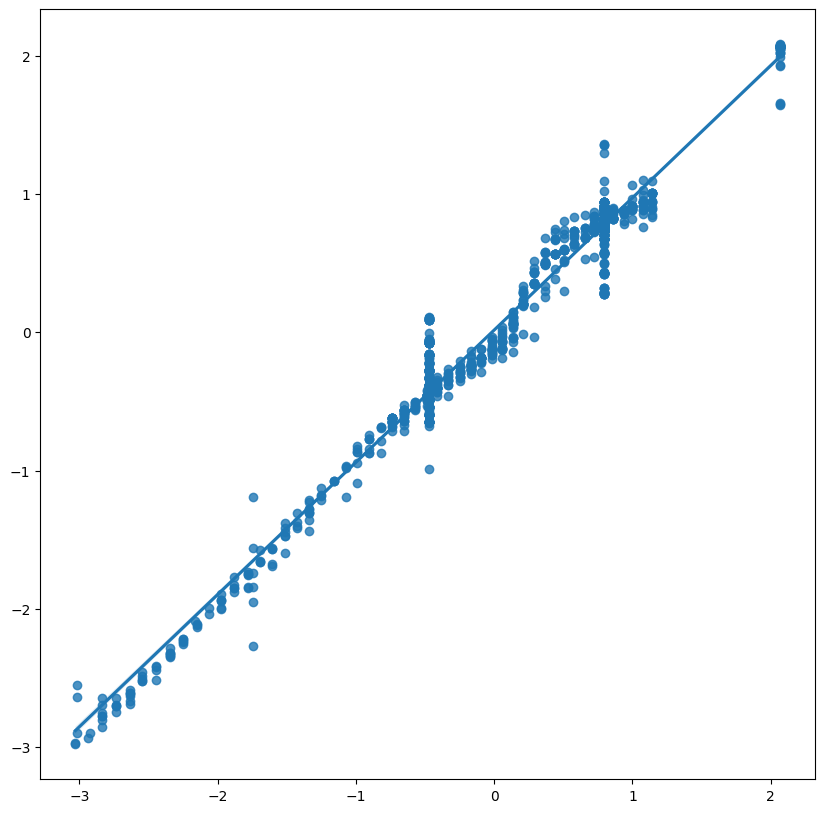

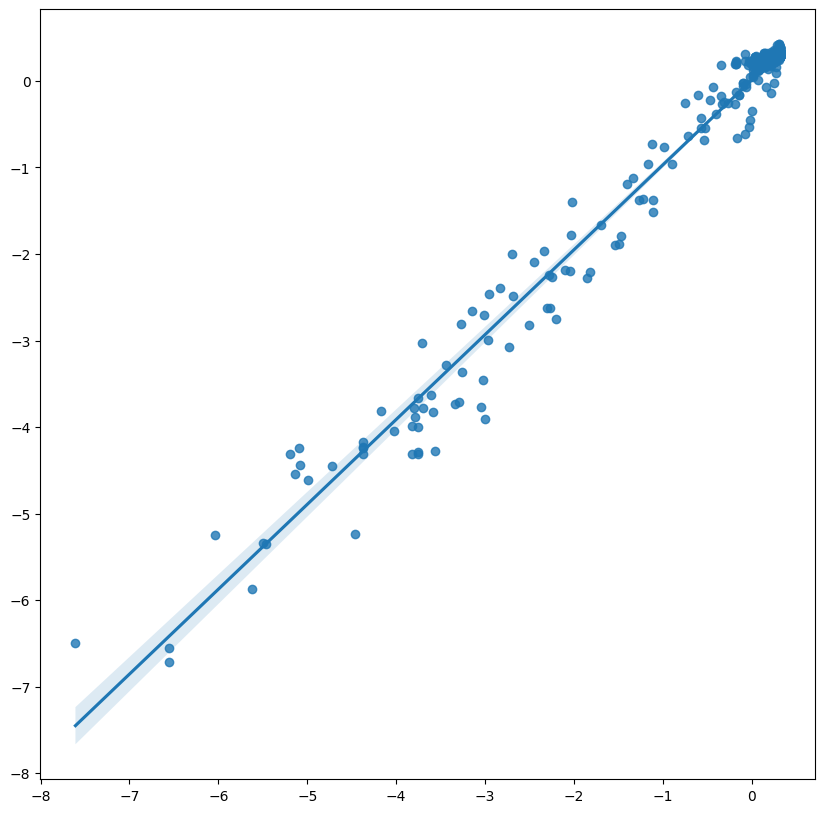

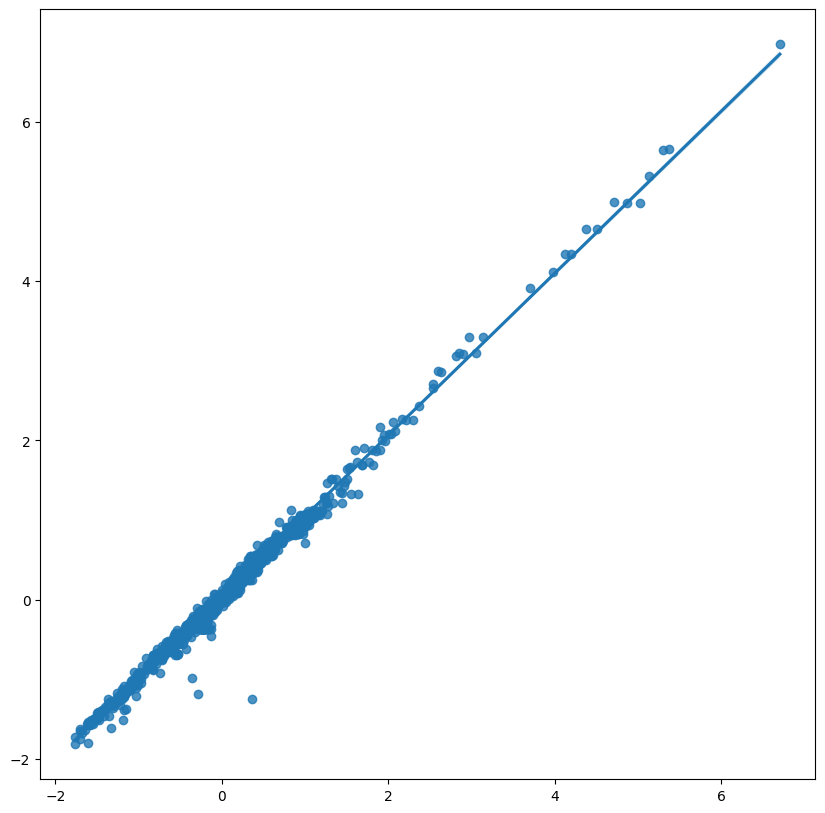

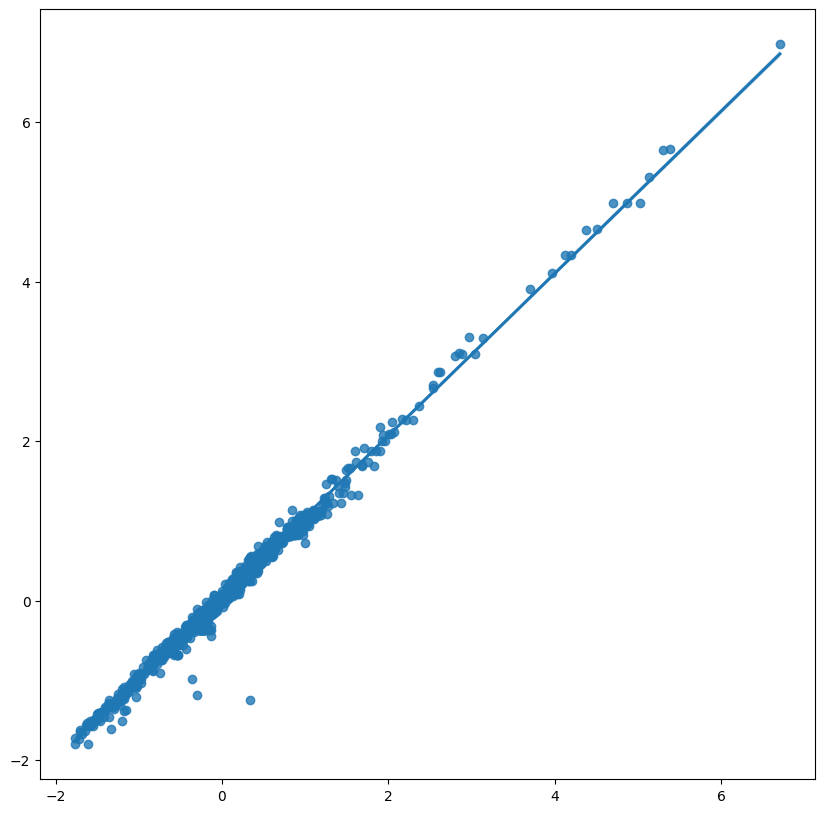

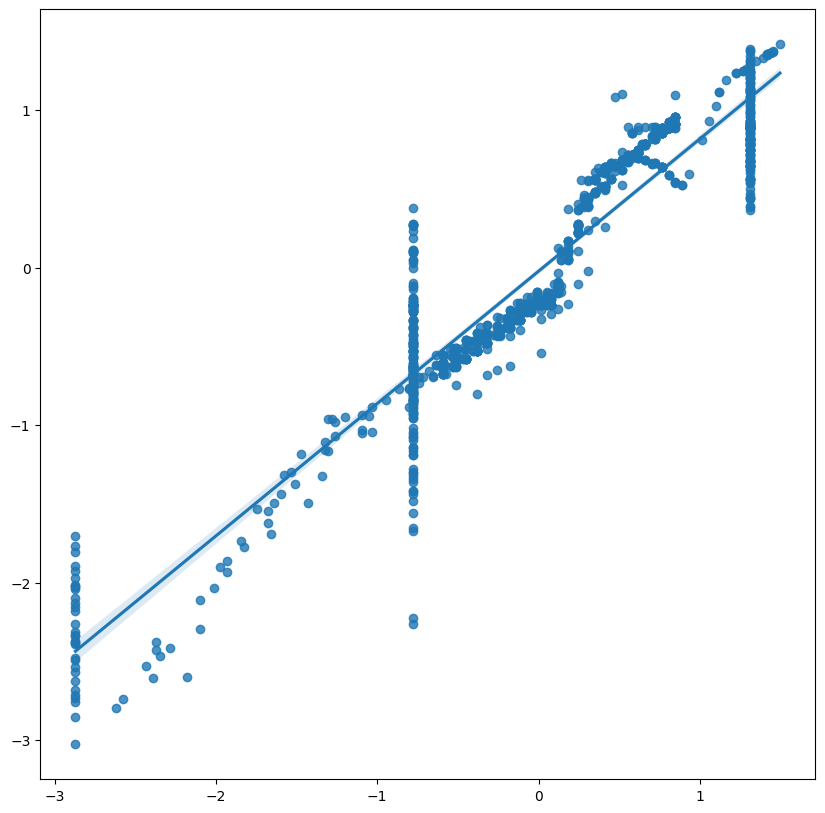

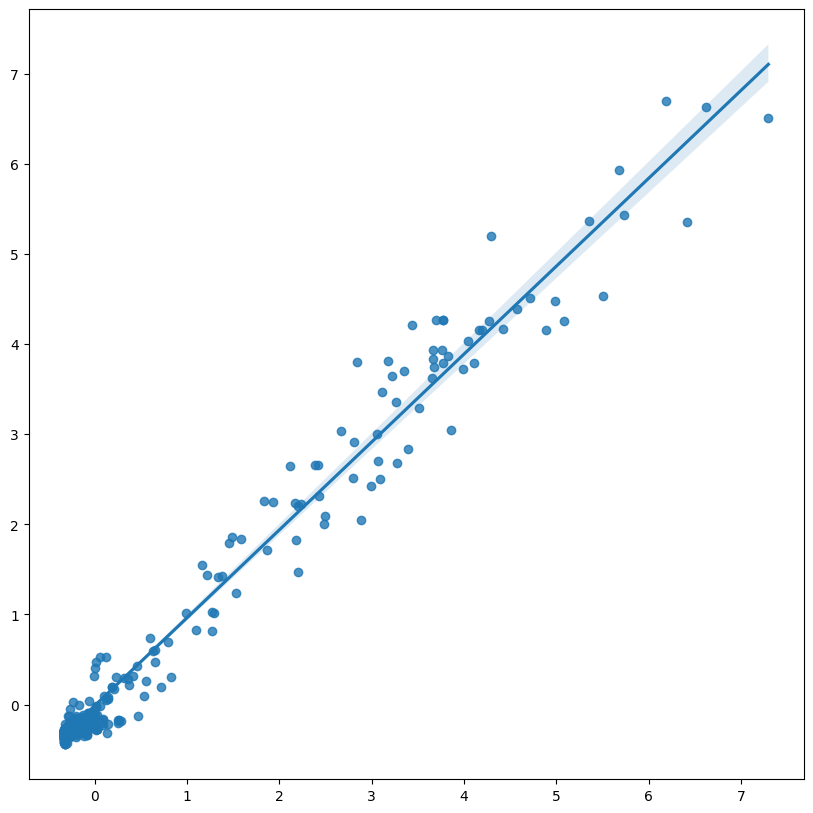

In [84]:
for l in range(6):
#     print(tar[l], metrics.r2_score(y[:,l], pre[:,l]))

    plt.figure(figsize=(10,10))
    sns.regplot(x=y[:,l], y=pre[:,l])

In [ ]:
y